In [2]:
import numpy as np
import torch
import torch.optim as optim
import math
import time
import matplotlib.pyplot as plt
from torch import Tensor
from torch.func import jacrev, vmap 

# Sampling Set Up

In [3]:
#arbitrary non-linear latent model function
def f(x): 
    return x**2

In [4]:
def sample_full_rank_matrix(n=3, lower=-10, upper=10):
    while True:
        matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
        matrix.requires_grad_(True)
        matrix.retain_grad()
        if torch.det(matrix).item() != 0:
            return matrix

In [5]:
def sample_full_rank_matrix_sparse(n=3, lower=-10, upper=10):
    matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
    # Set the diagonal elements to random values to ensure full rank
    diag = torch.FloatTensor(n).uniform_(lower, upper)
    matrix.fill_diagonal_(0)  # Set diagonal to zero before filling with random values
    matrix += torch.diag(diag)
    
    # Get the indices of the off-diagonal elements
    triu_indices = torch.triu_indices(n, n, offset=1)
    tril_indices = torch.tril_indices(n, n, offset=-1)
    off_diagonal_indices = torch.cat((triu_indices, tril_indices), dim=1)
    
    # Randomly select half of the off-diagonal elements to set to zero
    num_off_diagonal_elements = off_diagonal_indices.shape[1]
#     num_elements_to_zero = num_zero
    num_elements_to_zero = torch.randint(0, n**2-n+1, (1,)).item()
#     print(num_elements_to_zero)
    
    # Generate random indices to zero out without replacement
    indices_to_zero = torch.randperm(num_off_diagonal_elements)[:num_elements_to_zero]
    
    # Zero out the selected off-diagonal elements
    matrix[off_diagonal_indices[0, indices_to_zero], off_diagonal_indices[1, indices_to_zero]] = 0.0
    
    matrix.requires_grad_(True)
    return matrix

In [6]:
def sample(G, f, variances):
    noise = [torch.normal(0, torch.sqrt(variance)).requires_grad_() for variance in variances]
    U = [noise[0]]
    for i in range(1, len(variances)):
        U.append(f(U[i-1]) + noise[i])
#     U.append(f(U[0]) + noise[1])
#     U.append(f(U[1]) + noise[2])
#     U.append(f(U[1]) + noise[3])
    U_tensor = torch.stack(U)  # Convert list of tensors to a tensor
    X = torch.matmul(G, U_tensor.unsqueeze(1)).squeeze(1)  # Matrix multiplication and remove extra dimension
    return U_tensor, X

In [7]:
def sample_n(G, f, variances, n):
    U_list, X_list = [], []
    for _ in range(n):
        U, X = sample(G, f, variances)
        U_list.append(U)
        X_list.append(X)
    U_stacked = torch.stack(U_list)
    X_stacked = torch.stack(X_list)
    return U_stacked, X_stacked

In [8]:
def estimate_latent(G_hat, U):
    return (torch.inverse(G)@X.T).T

In [9]:
variances = torch.rand(4)*5
G = sample_full_rank_matrix(4)
U, X = sample(G, f, variances)
U,X

(tensor([-0.7166,  1.2655,  1.6120,  3.1420], grad_fn=<StackBackward0>),
 tensor([ -1.9388, -32.7171, -36.3447,  29.4964], grad_fn=<SqueezeBackward1>))

In [10]:
torch.inverse(G)@X

tensor([-0.7166,  1.2655,  1.6120,  3.1420], grad_fn=<MvBackward0>)

In [11]:
U, X = sample_n(G,f,variances, 5)
U,X

(tensor([[ 1.2819e-01,  4.6137e-02,  1.1836e+00, -1.9881e+00],
         [-6.6647e-01,  1.2759e+00,  2.8132e+00,  8.7793e+00],
         [ 2.4955e-01, -1.2033e+00,  4.5182e+00,  1.8520e+01],
         [ 6.2188e-01, -1.3961e+00,  1.3067e+00, -2.9331e+00],
         [-2.7008e+00,  8.3648e+00,  7.1639e+01,  5.1328e+03]],
        grad_fn=<StackBackward0>),
 tensor([[ 3.0371e+00,  4.6377e+00,  2.7989e-01, -1.6680e+01],
         [ 9.2511e+00, -7.3027e+01, -7.3921e+01,  7.8334e+01],
         [ 4.8146e+01, -1.3811e+02, -1.1603e+02,  1.6470e+02],
         [ 1.4787e+01,  1.0573e+01,  1.5688e+01, -2.3301e+01],
         [ 5.7316e+03, -3.0167e+04, -2.6484e+04,  4.3686e+04]],
        grad_fn=<StackBackward0>))

In [12]:
estimate_latent(G, X)

tensor([[ 1.2819e-01,  4.6137e-02,  1.1836e+00, -1.9881e+00],
        [-6.6647e-01,  1.2759e+00,  2.8132e+00,  8.7793e+00],
        [ 2.4955e-01, -1.2033e+00,  4.5182e+00,  1.8520e+01],
        [ 6.2188e-01, -1.3961e+00,  1.3067e+00, -2.9331e+00],
        [-2.7009e+00,  8.3648e+00,  7.1639e+01,  5.1328e+03]],
       grad_fn=<PermuteBackward0>)

# Jacobian Estimation

In [13]:
def gaussian_pdf(x, mu, var):
    return (1/torch.sqrt(2*np.pi*var))*torch.exp(-0.5*((x-mu)**2/var))

In [14]:
def p_u(U, variances):
    # Calculate the product of Gaussian PDFs
    prod = gaussian_pdf(U[0], torch.tensor(0.0), variances[0])
    for i in range(1, len(U)):
        prod *= gaussian_pdf(U[i], f(U[i-1]), variances[i])
#     prod *= gaussian_pdf(U[1], f(U[0]), variances[1])
#     prod *= gaussian_pdf(U[2], f(U[1]), variances[2])
#     prod *= gaussian_pdf(U[3], f(U[1]), variances[3])
    return prod

In [15]:
def log_pu(U, variances):
    return torch.log(p_u(U, variances))

In [16]:
def score_u(U, variances):
    return torch.autograd.grad(outputs=log_pu(U, variances), inputs=U, create_graph=True)[0]

In [19]:
def jacobian_score_u(U, variances):
    grad_log_pu = score_u(U, variances)
    hessian = torch.zeros(U.size(0), U.size(0))
    for i in range(U.size(0)):
        grad_grad_log_pu = torch.autograd.grad(outputs=grad_log_pu[i], inputs=U, create_graph=True)
        hessian[i] = grad_grad_log_pu[0]
    return hessian

In [20]:
def estimate_jacobian_score_u(G, G_hat, U, variances):
    beta = torch.matmul(torch.inverse(G), G_hat)
    return torch.matmul(torch.matmul(beta.T, jacobian_score_u(U, variances)), beta)

In [21]:
def H(G,U,variances):
    jacobians = torch.zeros(U.shape[0], U.shape[1], U.shape[1])
    for i in range(len(U)):
        jacobians[i] = torch.inverse(G).T@jacobian_score_u(U[i], variances)@torch.inverse(G)
    jacobians.requires_grad_(True)
    jacobians.retain_grad()
    return jacobians

In [22]:
def H_U(U,variances):
    jacobians = torch.zeros(U.shape[0], U.shape[1], U.shape[1])
    for i in range(len(U)):
        jacobians[i] = jacobian_score_u(U[i], variances)
    jacobians.requires_grad_(True)
    jacobians.retain_grad()
    return jacobians

In [23]:
def diag_estimated_jacobian(G_hat, H_):
    result = torch.zeros((H_.shape[0], H_.shape[1]))
    for i in range(U.shape[0]):
        result[i] = torch.diag(G_hat.T @ H_[i] @ G_hat)
    return result.requires_grad_(True)

In [24]:
def jacobian_score_x(G, U, variances):
    grad_log_px = torch.matmul(torch.inverse(G).T, jacobian_score_u(U, variances), torch.inverse(G))

# Variance Estimation

In [25]:
#adjustable params
num_latent = 4
num_samples = 1000
variance_max = 1
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat
f = lambda x:  x**2

In [26]:
#unadjustable params (for now)
num_observed = num_latent

In [27]:
variances = torch.rand(num_latent)*variance_max
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
G_hat = sample_full_rank_matrix(num_latent, lower_G, upper_G)
U, X = sample_n(G, f, variances, num_samples)

In [28]:
def estimated_jacobian_variances(G_hat, G, U, X, variances):
    estimated_diag_jacobians = torch.zeros_like(U)
    for i in range(len(U)):
        estimated_diag_jacobians[i] = torch.diag(estimate_jacobian_score_u(G, G_hat, U[i], variances))
    return torch.var(estimated_diag_jacobians, dim=0, unbiased=True)

In [29]:
def smooth_L0_norm(tensor, sigma, epsilon=1e-5, alpha=1e15):
# #     return torch.sum(torch.sigmoid(alpha * (torch.abs(tensor) - epsilon)))
#     tensor.requires_grad_(True)
#     optimizer_ = optim.Adam([tensor], lr=1e-5)
#     sigma = 1e-1
#     for i in range(max_iters):
#         optimizer.zero_grad()
#         loss_=torch.sum(torch.exp(-tensor**2/(2*sigma**2)))
#         loss_.backward(retain_graph=True)
#         optimizer_.step()
#         sigma*=0.5
#     return torch.sum(torch.exp(-tensor**2/(2*sigma**2)))
    return -torch.sum(torch.exp(-tensor**2/(2*sigma)))

In [30]:
def diag_var(G_hat, H):
    diags = diag_estimated_jacobian(G_hat, H)
    return torch.var(diags, dim=0, unbiased=False)

In [31]:
def objective(G_hat, H_, sigma):
#     return smooth_L0_norm(estimated_jacobian_variances(G_hat, G, U, X, variances))
    return smooth_L0_norm(diag_var(G_hat, H), sigma)

In [32]:
def cov_vec_H(H_):
    H_ = H_.view(num_samples, -1)
    H_scaled = H_ - H_.mean(dim=0)
    return torch.mm(H_scaled.t(), H_scaled)/(len(H_scaled) - 1)


# Greedy Optimization

In [34]:
from scipy.linalg import null_space
from torch.optim import Adam, SGD
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [54]:
# num_samples = 500
# variances = torch.rand(num_latent)*variance_max
# G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
# G_hat = sample_full_rank_matrix(num_latent, lower_G, upper_G)
# U, X = sample_n(G, f, variances, num_samples)

In [55]:
H_ = H(G,U,variances)
H_U_ = H_U(U,variances)

In [62]:
H_U_

tensor([[[-5.5082e+00,  4.0391e-01, -2.2199e-07, -7.8404e-08],
         [ 4.0391e-01, -5.0612e+00, -1.5432e+00,  0.0000e+00],
         [ 0.0000e+00, -1.5432e+00, -7.9240e+00, -3.2159e+00],
         [ 0.0000e+00,  0.0000e+00, -3.2159e+00, -3.2320e+00]],

        [[-7.3915e+00, -8.0784e-01,  2.6405e-07,  1.4024e-07],
         [-8.0784e-01, -1.1582e+01, -4.2644e+00,  0.0000e+00],
         [ 3.6511e-07, -4.2644e+00, -4.4893e+00,  5.7710e-01],
         [ 1.3915e-07,  2.2055e-07,  5.7710e-01, -3.2320e+00]],

        [[-2.9816e+00,  5.5707e-01,  5.2691e-08, -5.9130e-08],
         [ 5.5707e-01, -9.5994e+00,  4.4223e+00,  1.1826e-07],
         [ 0.0000e+00,  4.4223e+00, -9.4565e+00,  4.1931e+00],
         [ 0.0000e+00,  0.0000e+00,  4.1931e+00, -3.2320e+00]],

        ...,

        [[-8.3558e+00,  2.5148e+00,  7.3991e-06, -7.2714e-07],
         [ 2.5148e+00, -3.6900e+01,  9.9555e+00,  1.4543e-06],
         [ 9.8684e-06,  9.9555e+00, -2.9287e+02,  3.0413e+01],
         [-4.6671e-07,  1.0017e-06,

In [63]:
jacrev(score_u)(U[0], variances)

tensor([[-5.5082e+00,  4.0391e-01, -2.2199e-07, -7.8404e-08],
        [ 4.0391e-01, -5.0612e+00, -1.5432e+00,  0.0000e+00],
        [ 0.0000e+00, -1.5432e+00, -7.9240e+00, -3.2159e+00],
        [ 0.0000e+00,  0.0000e+00, -3.2159e+00, -3.2320e+00]],
       grad_fn=<ViewBackward0>)

In [54]:
# U = U[0]
hessian = torch.zeros(U.size(0), U.size(0))
grad_grad_log_pu = torch.autograd.grad(outputs=sc_u[0], inputs=U, create_graph=True)


(tensor([-5.8843e+00,  8.7250e-01,  1.3679e-07, -2.0775e-07],
        grad_fn=<AddBackward0>),)

In [33]:
H_diff = H_ - torch.mean(H_, axis=0)

In [34]:
H_diff

tensor([[[-8.9508e+00, -9.2263e+01,  2.4123e+01,  4.8637e+01],
         [-9.2263e+01,  1.9038e+03, -6.7419e+02, -1.0827e+03],
         [ 2.4123e+01, -6.7419e+02,  2.1023e+02,  3.6974e+02],
         [ 4.8637e+01, -1.0827e+03,  3.6974e+02,  6.0862e+02]],

        [[ 1.3325e+01, -3.6241e+02,  1.4104e+02,  2.1782e+02],
         [-3.6241e+02,  1.1956e+04, -4.5592e+03, -7.1425e+03],
         [ 1.4104e+02, -4.5592e+03,  1.7361e+03,  2.7228e+03],
         [ 2.1782e+02, -7.1425e+03,  2.7228e+03,  4.2665e+03]],

        [[ 1.7880e+01, -4.7494e+02,  1.9197e+02,  2.8941e+02],
         [-4.7494e+02,  1.2555e+04, -4.8843e+03, -7.5734e+03],
         [ 1.9197e+02, -4.8843e+03,  1.9199e+03,  2.9550e+03],
         [ 2.8941e+02, -7.5734e+03,  2.9550e+03,  4.5721e+03]],

        ...,

        [[ 1.9608e+01, -5.2932e+02,  2.1977e+02,  3.2485e+02],
         [-5.2932e+02,  1.2885e+04, -4.9424e+03, -7.7441e+03],
         [ 2.1977e+02, -4.9424e+03,  1.9181e+03,  2.9808e+03],
         [ 3.2485e+02, -7.7441e+03,

In [35]:
H_matrices = H_.detach().numpy()
H_U_matrices = H_U_.detach().numpy()

In [36]:
sigma = cov_vec_H(H_).detach().numpy()

In [37]:
ns = null_space(sigma)
ns.shape

(16, 15)

In [38]:
H_bar = np.mean(H_matrices, axis=0)

In [39]:
H_diff = (H_matrices - H_bar)

In [40]:
def symmetrize(H_diff):
    return np.array([(H_diff[i]+H_diff[i].T)/2.0 for i in range(H_diff.shape[0])])

In [41]:
H_diff_sym = symmetrize(H_diff)

In [42]:
H_matrices.shape

(1000, 4, 4)

In [44]:
torch.var(H_U_, axis=0)

tensor([[1.0941e+02, 2.0603e+01, 1.3712e-11, 4.8678e-14],
        [2.0603e+01, 3.3889e+03, 6.9318e+01, 1.0703e-13],
        [1.0805e-11, 6.9318e+01, 2.6175e+05, 8.3572e+01],
        [3.9241e-14, 1.2109e-13, 8.3572e+01, 3.5879e-14]],
       grad_fn=<VarBackward1>)

In [45]:
torch.var(H_, axis=0)

tensor([[1.1771e+04, 7.5077e+06, 1.1769e+06, 2.7457e+06],
        [7.5077e+06, 6.6179e+09, 9.9615e+08, 2.3911e+09],
        [1.1769e+06, 9.9615e+08, 1.5092e+08, 3.6061e+08],
        [2.7457e+06, 2.3911e+09, 3.6061e+08, 8.6443e+08]],
       grad_fn=<VarBackward1>)

In [1006]:
G

tensor([[ 1.6673, -0.1783,  0.4013, -0.0833],
        [ 0.5482,  1.2134, -0.5774, -0.3552],
        [ 0.2338,  0.5292,  1.8979,  0.9406],
        [ 0.8828, -0.9139,  0.7319,  0.0322]], grad_fn=<AddBackward0>)

In [1007]:
G_inv = torch.inverse(G).detach()
G_inv

tensor([[ 1.3269, -0.5482, -0.0546, -1.0184],
        [-0.3744,  0.7766,  0.2547,  0.1574],
        [-2.2637,  1.8045,  0.3762,  3.0553],
        [ 4.4484, -3.9418,  0.1743, -6.0003]])

In [1008]:
G_inv[0]

tensor([ 1.3269, -0.5482, -0.0546, -1.0184])

In [1009]:
v = ((torch.randn(4)*2-1)/100).requires_grad_(True)
v

tensor([-0.0016,  0.0024, -0.0003,  0.0015], requires_grad=True)

In [1010]:
# G_inv[0]*v = 0
# G_inv[1]*v = 0
# G_inv[2]*v = 0

torch.dot(G_inv[0],v)

tensor(-0.0050, grad_fn=<DotBackward>)

In [1011]:
optimizer = Adam([v], lr=0.01)
max_iterations=100000

In [1021]:
for iteration in range(max_iterations):
    
    optimizer.zero_grad()  # Reset gradients to zero

    loss = (torch.dot(G_inv[0],v))**2 + torch.dot(G_inv[1],v)**2 + torch.dot(G_inv[2],v)**2  # Objective function

    loss.backward()  # Compute gradients

    optimizer.step()  # Update v based on gradients

    with torch.no_grad():
        v /= v.norm()

    if loss <= 1e-16:
        break
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")
    
# Check final solution
with torch.no_grad():
    print(f"Final v: {v}")
#     print(f"Check if in null space (should be close to 0): ||A(v ⊗ v)|| = {torch.norm(torch.matmul(sigma, torch.kron(v, v)))}")



Iteration 0, Loss: 1.7774176575002798e-10
Iteration 1000, Loss: 4.014930748974521e-14
Iteration 2000, Loss: 2.519190134275817e-10
Iteration 3000, Loss: 1.7599845192339814e-12
Iteration 4000, Loss: 3.992344510539425e-10
Iteration 5000, Loss: 8.938261998991948e-06
Iteration 6000, Loss: 3.1854111362528137e-12
Final v: tensor([ 0.0826,  0.3519, -0.9318, -0.0319], requires_grad=True)


In [1022]:
v_ = v.detach().numpy()
v_

array([ 0.08255719,  0.35190254, -0.93184197, -0.03192947], dtype=float32)

In [1023]:
G_inv@(-1*v)

tensor([-1.0058e-07,  5.5879e-08,  2.5332e-07,  9.9072e-01],
       grad_fn=<MvBackward>)

In [1024]:
(-v_.T)@H_diff[100]@(-v_)

-1.1011958e-05

In [1025]:
sum(np.abs((-v_).T@H_diff[i]@(-v_)) for i in range(len(H_diff)))   

0.007139353081583977

In [1026]:
torch.ger(-v,-v).flatten()@cov_vec_H(H_)@torch.ger(-v,-v).flatten()

tensor(-0.0361, grad_fn=<DotBackward>)

In [1027]:
v_.T@v_

1.0

In [1028]:
v_

array([ 0.08255719,  0.35190254, -0.93184197, -0.03192947], dtype=float32)

In [1091]:
def max_diff(x, H_diff_sym):
    max_diff = 0.0
    for mat in H_diff_sym:
        val = np.abs(x@mat@x)
        max_diff = max(max_diff, val)
    return max_diff

In [1030]:
max_diff(v_)

0.00024986267

# QCQP

In [703]:
import gurobipy as gp
from gurobipy import GRB
import random

In [704]:
def qcqp_solver(H_diff_sym, epsilon = 5e-4):
    
    m = gp.Model("qcqp")
    # m.setParam('FeasibilityTol', 1e-3)
    
    x = m.addMVar(shape=H_diff_sym.shape[1], lb=-GRB.INFINITY, name="x")
    
    m.setObjective(0, GRB.MINIMIZE)
    
    for i in range(H_diff_sym.shape[0]):
        m.addConstr(x @ H_diff_sym[i] @ x <= epsilon, name=f"qc{i}_upper")
        m.addConstr(x @ H_diff_sym[i] @ x >= -epsilon, name=f"qc{i}_lower")
        
    m.addConstr(x @ x <= 1+epsilon, name="norm_upper")
    m.addConstr(x @ x >= 1-epsilon, name="norm_lower")
    
    m.update()
    
    solutions = np.empty((H_diff_sym.shape[1],0))
    while True:
        m.Params.NonConvex = 2
        m.setParam('OutputFlag', 0)
        m.optimize()
        if m.status == GRB.OPTIMAL:
            print('Optimal solution found:')
            sol = x.X
            print(sol)
            print()
            solutions = np.hstack((solutions, sol.reshape(-1, 1)))
            m.addConstr(x @ sol == 0, name=f"orth_const_{solutions.shape[1]}")
            m.update()
        elif m.status == GRB.INFEASIBLE:
            print('No feasible solution found.')
            return solutions
        else:
            print('Optimization was stopped with status', m.status)
            return solutions
    

In [705]:
def fill_full_rank_matrix(A):
    """
    Given a matrix A (n x m) with m <= n, add column vectors of norm 1 such that the matrix is n x n and full rank.
    """
    n,m = A.shape
    if m == n: return A
    
    columns_to_add = n - m
    
    for _ in range(columns_to_add):
        while True:
            new_col = np.random.rand(n, 1)
            new_col /= np.linalg.norm(new_col)
            
            test_matrix = np.hstack((A, new_col))
            if np.linalg.matrix_rank(test_matrix) == A.shape[1] + 1:
                A = test_matrix
                break

    return A

In [706]:
def G_inv_estimator(H_diff_sym, epsilon = 5e-4):
    return fill_full_rank_matrix(qcqp_solver(H_diff_sym, epsilon))

In [711]:
G_hat = G_inv_estimator(H_diff_sym)
G_hat

Set parameter NonConvex to value 2
Optimal solution found:
[-0.16010869 -0.09290758  0.0715531   0.98010573]

No feasible solution found.


array([[-0.16010869,  0.20370156,  0.56940268,  0.29089119],
       [-0.09290758,  0.78197434,  0.70725278,  0.34918466],
       [ 0.0715531 ,  0.48580886,  0.30301337,  0.56542459],
       [ 0.98010573,  0.33318397,  0.28940799,  0.68829312]])

In [712]:
np.linalg.inv(G.detach().numpy())@G_hat

array([[ 1.59043124e-04, -3.35818364e+00, -4.66897839e+00,
        -3.19500032e+00],
       [-1.02304694e-04, -8.03961398e-01, -1.40159265e+00,
        -9.05147557e-01],
       [ 3.66757163e-08, -4.12809111e-01, -7.08388997e-01,
        -2.93222910e-01],
       [ 6.20708095e-01,  8.98091984e-01,  9.92535835e-01,
         1.05761966e+00]])

In [721]:
# Beta = (G inv)(G_hat)
# Z = Beta Z_hat

#J_Z_hat = Beta^T J_Z Beta = (G_hat^T)(G inv ^T) J_Z (G_inv)(G_hat)

In [719]:
J_X = H_.detach().numpy()
J_X.shape

(500, 4, 4)

In [722]:
G_hat

array([[-0.16010869,  0.20370156,  0.56940268,  0.29089119],
       [-0.09290758,  0.78197434,  0.70725278,  0.34918466],
       [ 0.0715531 ,  0.48580886,  0.30301337,  0.56542459],
       [ 0.98010573,  0.33318397,  0.28940799,  0.68829312]])

In [737]:
J_U_hat = np.matmul(np.matmul(G_hat.T, J_X),G_hat)

In [743]:
J_U_hat_var = np.var(J_U_hat, axis=0)

In [745]:
J_U_hat_var

array([[4.64343556e-13, 4.91528483e-01, 1.44744262e+00, 2.48800036e-01],
       [4.91528524e-01, 1.86140369e+03, 4.17637603e+03, 1.76330281e+03],
       [1.44744264e+00, 4.17637597e+03, 9.69843833e+03, 4.02173812e+03],
       [2.48800018e-01, 1.76330279e+03, 4.02173814e+03, 1.70375874e+03]])

In [747]:
# X = GU
# U_hat = (G_hat inv) X
# U_hat = (G_hat inv)(G) U
# U_hat = (Beta Inv) U

In [783]:
X_ = X.detach().numpy()

In [759]:
print('U_hat as a linear combination of U:')

np.linalg.inv(G_hat)@(G.detach().numpy())

U_hat as a linear combination of U:


array([[ 8.09252939e-01,  6.24536334e-02, -3.20032712e+00,
         1.61086644e+00],
       [-1.45470187e+00,  5.65320788e+00, -1.59549016e+00,
         1.30471790e-03],
       [ 8.71553996e-01, -2.11290417e+00, -2.97633529e+00,
        -5.71423588e-04],
       [-5.75843427e-02, -2.85427093e+00,  6.02625456e+00,
        -4.56117275e-04]])

In [793]:
U_hat = (np.linalg.inv(G_hat)@(X_.T)).T

array([[ 3.68284425,  0.58184412,  2.60449899, -4.4481825 ],
       [ 1.49041643,  0.77410487, -1.871435  ,  1.92474692],
       [ 0.43394817, -9.89075926, -1.65024706, 12.78825336],
       ...,
       [-3.02900222,  2.26605368, -4.18222779,  3.84578704],
       [-3.39776099, -2.190778  ,  0.37379549,  1.83996528],
       [-0.84839402, -1.73651935,  1.28170485, -0.08254809]])

# Full Simulation: Line Graph

In [1506]:
#adjustable params
num_latent = 4
num_samples = 500
variance_max = 1
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat
f = lambda x:  x**2

In [1507]:
# variances = torch.rand(num_latent)*variance_max
# G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
# U,_ = sample_n(G, f, variances, num_samples)

In [1432]:
def remove_layer(G,U,variances):
    #Estimate Jacobian of the score
    print('Calculating Jacobian Estimates...')
    X = ((G@(U.T)).T).detach().numpy()
    J_X = H(G,U,variances).detach().numpy()
    J_U = H_U(U,variances).detach().numpy() # might not need
    
    
    J_X_bar = np.mean(J_X, axis=0)
    J_X_diff = J_X - J_X_bar
    J_X_diff_sym = symmetrize(J_X_diff)
    print('Done.')
    print()
    
    print('Finding Optimal G_hat...')
    G_hat = G_inv_estimator(J_X_diff_sym)
    print('Done.')
    print()
    
    print('Diagonal of Estimated Jacobian:')
    J_U_hat = np.matmul(np.matmul(G_hat.T, J_X),G_hat)
    J_U_hat_var = np.var(J_U_hat, axis=0)
    print(np.diag(J_U_hat_var))
    num_zero_diag = (np.diag(J_U_hat_var) < 1e-4).sum()
    print()
    
    print('U_hat as a linear combination of U:')
    beta_inv = np.linalg.inv(G_hat)@(G.detach().numpy())
    print(beta_inv)
    U_hat = (np.linalg.inv(G_hat)@(X.T)).T
    print()
    
    leafs = U_hat[:,0:num_zero_diag]
    new_X = U_hat[:,num_zero_diag:]
    new_U = U[:,:-num_zero_diag]
    new_G = torch.from_numpy(beta_inv[num_zero_diag:, :-num_zero_diag].astype(np.float32))
    new_variances = variances[:-num_zero_diag]
    
    return leafs, new_G, new_U, new_variances

In [1480]:
def identify(G,U,variances):
    layer = 1
    U_estimates = np.empty((U.shape[0],0))
    while U.shape[1]:
        print('-----------------------------------------------------------')
        print(f'Removing Layer {layer}.')
        print('-----------------------------------------------------------')
        leafs, G, U, variances = remove_layer(G,U,variances)
        U_estimates = np.hstack((leafs, U_estimates))
        layer+=1
        
    return U_estimates

In [1481]:
id_layers = identify(G,U,variances)

-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2
Optimal solution found:
[-0.07911735 -0.34965039  0.93280471  0.03302936]

No feasible solution found.
Done.

Diagonal of Estimated Jacobian:
[5.90412413e-09 5.36856036e+06 1.27687067e+07 8.06839211e+06]

U_hat as a linear combination of U:
[[ 3.77675846e-02  1.83039343e+00  1.31318919e+00  1.00767060e+00]
 [ 7.43911931e+00 -6.75497597e-01  2.31728030e+00 -1.55953279e-02]
 [-8.71172366e+00  4.80195416e+00 -3.50364041e+00  1.47024055e-02]
 [ 3.05156671e+00 -4.75750908e+00  2.29089362e+00 -2.41976460e-03]]

-----------------------------------------------------------
Removing Layer 2.
-----------------------------------------------------------
Calculating Jacobian Estimates...
Done.

Finding Optimal G_hat...
Set parameter NonConvex to value 2
Optimal sol

In [1488]:
id_layers.shape[1]

4

LAYER 3:


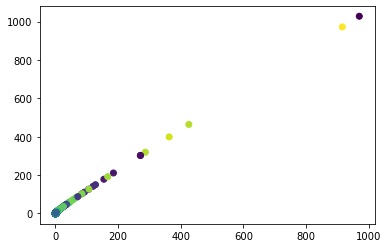

LAYER 2:


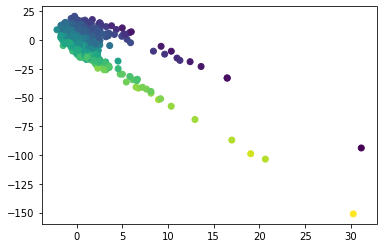

LAYER 1:


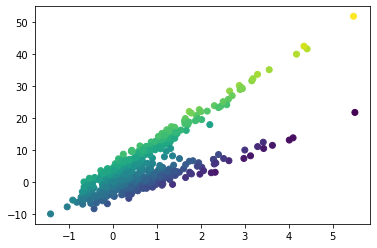

LAYER 0:


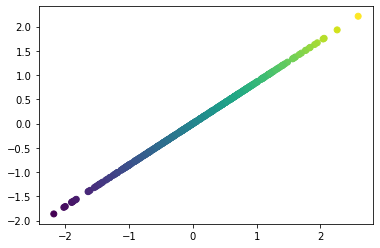

In [1518]:
for layer in range(id_layers.shape[1]-1,-1,-1):
    print(f'LAYER {layer}:')
    
    plt.scatter(U.detach().numpy()[:,layer], id_layers[:,layer], c = U.detach().numpy()[:,0])
    plt.show()

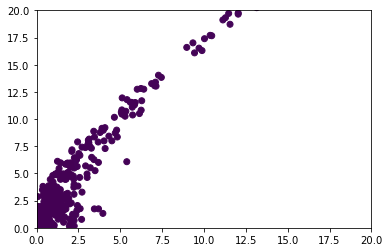

In [1516]:
plt.scatter(U.detach().numpy()[:,3], id_layers[:,3], c = U.detach().numpy()[:,3])
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

In [1505]:
# remove_layer(new_G_test, new_U_test, new_variances_test)

In [1418]:
# X = ((G@(U.T)).T).detach().numpy()

In [1419]:
# J_U = H_U(U,variances).detach().numpy()
# J_X = H(G,U,variances).detach().numpy()
# J_X_bar = np.mean(J_X, axis=0)
# J_X_diff = J_X - J_X_bar
# J_X_diff_sym = symmetrize(J_X_diff)

In [1420]:
# G_hat = G_inv_estimator(J_X_diff_sym)
# max_diff(G_hat[:,0], J_X_diff_sym)

In [1421]:
# print('Diagonal of Estimated Jacobian:')
# J_U_hat = np.matmul(np.matmul(G_hat.T, J_X),G_hat)
# J_U_hat_var = np.var(J_U_hat, axis=0)
# print(np.diag(J_U_hat_var))
# num_zero_diag = (np.diag(J_U_hat_var) < 1e-4).sum()
# # print('Num Zeros: ', (np.diag(J_U_hat_var) < 1e-4).sum())

In [1422]:
# print('U_hat as a linear combination of U:')
# beta_inv = np.linalg.inv(G_hat)@(G.detach().numpy())
# print(beta_inv)
# U_hat = (np.linalg.inv(G_hat)@(X.T)).T

In [1423]:
# new_G = torch.from_numpy(beta_inv[num_zero_diag:, :-num_zero_diag].astype(np.float32))
# new_G

In [1424]:
# leafs = U_hat[:,0:num_zero_diag]
# leafs

In [1425]:
# new_X = U_hat[:,num_zero_diag:]
# new_X

In [1426]:
# new_U = U[:,:-num_zero_diag]
# new_U

In [1427]:
# (new_G@(new_U.detach().numpy().T)).T - new_X

In [1428]:
# new_variances = variances[:-num_zero_diag]
# new_variances

In [ ]:
# remove_layer(new_G, new_U, new_variances)

In [374]:
def max_diff(x):
    max_diff = 0.0
    for mat in H_diff_sym:
        val = np.abs(x@mat@x)
        max_diff = max(max_diff, val)
    return max_diff

In [375]:
m = gp.Model("qcqp")
# m.setParam('FeasibilityTol', 1e-3)

In [376]:
epsilon = 1e-3

In [377]:
x = m.addMVar(shape=4, lb=-GRB.INFINITY, name="x")

In [378]:
m.setObjective(0, GRB.MINIMIZE)

In [379]:
for i in range(500):
    m.addConstr(x @ H_diff_sym[i] @ x <= epsilon, name=f"qc{i}_upper")
    m.addConstr(x @ H_diff_sym[i] @ x >= -epsilon, name=f"qc{i}_lower")
m.addConstr(x @ x <= 1+epsilon, name="norm_upper")
m.addConstr(x @ x >= 1-epsilon, name="norm_lower")

<MQConstr () *awaiting model update*>

In [386]:
m.addConstr(x @ sol == 0, name="orth_const")

<MConstr ()>

In [387]:
m.update()

In [388]:
m.Params.NonConvex = 2

In [389]:
m.setParam('OutputFlag', 1)
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x4b9387bd
Model has 1002 quadratic constraints
Variable types: 4 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  QMatrix range    [2e-04, 6e+02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [1e-03, 1e+00]

MIP start from previous solve did not produce a new incumbent solution

Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [390]:
# Print solution
if m.status == GRB.OPTIMAL:
    print('Optimal solution found:')
    print(x.X)
elif m.status == GRB.INFEASIBLE:
    print('No feasible solution found.')
else:
    print('Optimization was stopped with status', m.status)

No feasible solution found.


In [385]:
sol = x.X
sol

array([ 0.08743312,  0.08668908,  0.00577995, -0.9919829 ])

In [299]:
v_

array([-0.08616426, -0.08492818, -0.00554535,  0.992639  ], dtype=float32)

In [300]:
max_diff(x.X)

0.0005000691967764204

In [301]:
max_diff(v_)

0.00016799569

In [ ]:
import cvxpy as cp
from qcqp import *

In [103]:
x = cp.Variable(4)

In [106]:
constraints = [cp.quad_form(x, H_diff_sym[i]) == 0 for i in range(H_diff_sym.shape[0])] + [cp.quad_form(x, np.eye(4)) == 1]

In [107]:
objective = cp.Minimize(0)

In [108]:
problem = cp.Problem(objective, constraints)

In [110]:
problem.solve()

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
QuadForm(var2510, [[-12.5606041   -2.59253693  -1.93738067   0.47193831]
 [ -2.59253693 -13.90625381 -23.06140137   1.99975801]
 [ -1.93738067 -23.06140137  15.13179398   0.04543138]
 [  0.47193831   1.99975801   0.04543138  -0.10741901]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-12.5606041   -2.59253693  -1.93738067   0.47193831]
 [ -2.59253693 -13.90625381 -23.06140137   1.99975801]
 [ -1.93738067 -23.06140137  15.13179398   0.04543138]
 [  0.47193831   1.99975801   0.04543138  -0.10741901]])
QuadForm(var2510, [[-15.23624802  -6.54953527  -0.82066077   0.06333876]
 [ -6.54953527   7.76667595 -24.82371902   2.3535471 ]
 [ -0.82066077 -24.82371902 -17.7353878   11.62068558]
 [  0.06333876   2.3535471   11.62068558  -1.68688774]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.23624802  -6.54953527  -0.82066077   0.06333876]
 [ -6.54953527   7.76667595 -24.82371902   2.3535471 ]
 [ -0.82066077 -24.82371902 -17.7353878   11.62068558]
 [  0.06333876   2.3535471   11.62068558  -1.68688774]])
QuadForm(var2510, [[ 2.67207527 21.35687065  0.10540962 -0.56209528]
 [21.35687065 10.24880409 15.88557911 -1.70011377]
 [ 0.10540962 15.88557911 -6.53456688  6.92243624]
 [-0.56209528 -1.70011377  6.92243624 -1.00734329]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.67207527 21.35687065  0.10540962 -0.56209528]
 [21.35687065 10.24880409 15.88557911 -1.70011377]
 [ 0.10540962 15.88557911 -6.53456688  6.92243624]
 [-0.56209528 -1.70011377  6.92243624 -1.00734329]])
QuadForm(var2510, [[11.78134918  2.7572515   0.99159533 -0.14838761]
 [ 2.7572515  -6.53550339  3.22771072 -0.45561734]
 [ 0.99159533  3.22771072 -3.19272041 -5.65115547]
 [-0.14838761 -0.45561734 -5.65115547  0.89218998]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.78134918  2.7572515   0.99159533 -0.14838761]
 [ 2.7572515  -6.53550339  3.22771072 -0.45561734]
 [ 0.99159533  3.22771072 -3.19272041 -5.65115547]
 [-0.14838761 -0.45561734 -5.65115547  0.89218998]])
QuadForm(var2510, [[-15.79285431 -11.60197067  -0.46726453   0.80368066]
 [-11.60197067 -20.53607941 -19.63523674   1.84984565]
 [ -0.46726453 -19.63523674  -7.04325676  -4.31732893]
 [  0.80368066   1.84984565  -4.31732893   0.68201637]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.79285431 -11.60197067  -0.46726453   0.80368066]
 [-11.60197067 -20.53607941 -19.63523674   1.84984565]
 [ -0.46726453 -19.63523674  -7.04325676  -4.31732893]
 [  0.80368066   1.84984565  -4.31732893   0.68201637]])
QuadForm(var2510, [[17.20477867 -0.09236467  0.68613714 -0.59372687]
 [-0.09236467  5.33515549  9.13197327 -0.70459962]
 [ 0.68613714  9.13197327  6.67016983  0.77337503]
 [-0.59372687 -0.70459962  0.77337503 -0.14346123]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[17.20477867 -0.09236467  0.68613714 -0.59372687]
 [-0.09236467  5.33515549  9.13197327 -0.70459962]
 [ 0.68613714  9.13197327  6.67016983  0.77337503]
 [-0.59372687 -0.70459962  0.77337503 -0.14346123]])
QuadForm(var2510, [[14.54870415 -8.75070572  0.25658259 -0.40623635]
 [-8.75070572  0.52266693 11.77929211 -0.63935935]
 [ 0.25658259 11.77929211 18.62263298 -0.40734804]
 [-0.40623635 -0.63935935 -0.40734804 -0.03893948]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[14.54870415 -8.75070572  0.25658259 -0.40623635]
 [-8.75070572  0.52266693 11.77929211 -0.63935935]
 [ 0.25658259 11.77929211 18.62263298 -0.40734804]
 [-0.40623635 -0.63935935 -0.40734804 -0.03893948]])
QuadForm(var2510, [[-18.58888245  -9.98478699  -1.54322994   0.29858941]
 [ -9.98478699   3.82368469 -24.69369507   2.43118572]
 [ -1.54322994 -24.69369507  -3.30640602   9.27191544]
 [  0.29858941   2.43118572   9.27191544  -1.41654968]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-18.58888245  -9.98478699  -1.54322994   0.29858941]
 [ -9.98478699   3.82368469 -24.69369507   2.43118572]
 [ -1.54322994 -24.69369507  -3.30640602   9.27191544]
 [  0.29858941   2.43118572   9.27191544  -1.41654968]])
QuadForm(var2510, [[ 4.19866371  3.58456135 -0.21175632 -0.23366594]
 [ 3.58456135 13.64532089 -5.76189327  0.30741102]
 [-0.21175632 -5.76189327  1.81076431  2.13862848]
 [-0.23366594  0.30741102  2.13862848 -0.33184052]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.19866371  3.58456135 -0.21175632 -0.23366594]
 [ 3.58456135 13.64532089 -5.76189327  0.30741102]
 [-0.21175632 -5.76189327  1.81076431  2.13862848]
 [-0.23366594  0.30741102  2.13862848 -0.33184052]])
QuadForm(var2510, [[ 6.29778957  6.81206131 -0.45103803 -0.40606591]
 [ 6.81206131 20.09190178 -2.2906034  -0.03194954]
 [-0.45103803 -2.2906034   7.27926826  3.95901728]
 [-0.40606591 -0.03194954  3.95901728 -0.6384697 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.29778957  6.81206131 -0.45103803 -0.40606591]
 [ 6.81206131 20.09190178 -2.2906034  -0.03194954]
 [-0.45103803 -2.2906034   7.27926826  3.95901728]
 [-0.40606591 -0.03194954  3.95901728 -0.6384697 ]])
QuadForm(var2510, [[25.03287697  2.24768877  1.7263608  -0.90451431]
 [ 2.24768877 -8.85366821 17.87709427 -1.33686209]
 [ 1.7263608  17.87709427 -3.48623848  1.35492873]
 [-0.90451431 -1.33686209  1.35492873 -0.16671848]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[25.03287697  2.24768877  1.7263608  -0.90451431]
 [ 2.24768877 -8.85366821 17.87709427 -1.33686209]
 [ 1.7263608  17.87709427 -3.48623848  1.35492873]
 [-0.90451431 -1.33686209  1.35492873 -0.16671848]])
QuadForm(var2510, [[ 5.72637653 -7.11761427  0.78430498  0.11924458]
 [-7.11761427 -6.69370651 -0.02435803  0.06734046]
 [ 0.78430498 -0.02435803 -1.96727562 -5.82493305]
 [ 0.11924458  0.06734046 -5.82493305  0.90251827]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.72637653 -7.11761427  0.78430498  0.11924458]
 [-7.11761427 -6.69370651 -0.02435803  0.06734046]
 [ 0.78430498 -0.02435803 -1.96727562 -5.82493305]
 [ 0.11924458  0.06734046 -5.82493305  0.90251827]])
QuadForm(var2510, [[ -0.63309097   4.3382988    1.09381866   0.59011716]
 [  4.3382988  -29.87836838  -9.73118114   0.41806379]
 [  1.09381866  -9.73118114 -17.77881813 -13.2105751 ]
 [  0.59011716   0.41806379 -13.2105751    2.12207317]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.63309097   4.3382988    1.09381866   0.59011716]
 [  4.3382988  -29.87836838  -9.73118114   0.41806379]
 [  1.09381866  -9.73118114 -17.77881813 -13.2105751 ]
 [  0.59011716   0.41806379 -13.2105751    2.12207317]])
QuadForm(var2510, [[ 17.76205826 -10.08190727   0.95702142  -0.65471619]
 [-10.08190727  -2.37890244  16.43533325  -0.86394423]
 [  0.95702142  16.43533325   8.21492195   2.79469466]
 [ -0.65471619  -0.86394423   2.79469466  -0.46572208]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 17.76205826 -10.08190727   0.95702142  -0.65471619]
 [-10.08190727  -2.37890244  16.43533325  -0.86394423]
 [  0.95702142  16.43533325   8.21492195   2.79469466]
 [ -0.65471619  -0.86394423   2.79469466  -0.46572208]])
QuadForm(var2510, [[25.15940285  5.60629463  0.9965961  -0.9161588 ]
 [ 5.60629463 -8.82928085 19.4959259  -1.53052497]
 [ 0.9965961  19.4959259  10.36532974  1.08995891]
 [-0.9161588  -1.53052497  1.08995891 -0.20551777]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[25.15940285  5.60629463  0.9965961  -0.9161588 ]
 [ 5.60629463 -8.82928085 19.4959259  -1.53052497]
 [ 0.9965961  19.4959259  10.36532974  1.08995891]
 [-0.9161588  -1.53052497  1.08995891 -0.20551777]])
QuadForm(var2510, [[ 3.82025528e+00  7.92480516e+00 -1.43174827e-02  2.71064043e-03]
 [ 7.92480516e+00  4.99610901e-01 -3.49673557e+00 -6.43153042e-02]
 [-1.43174827e-02 -3.49673557e+00  1.71449661e+00 -3.71179628e+00]
 [ 2.71064043e-03 -6.43153042e-02 -3.71179628e+00  5.63632011e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.82025528e+00  7.92480516e+00 -1.43174827e-02  2.71064043e-03]
 [ 7.92480516e+00  4.99610901e-01 -3.49673557e+00 -6.43153042e-02]
 [-1.43174827e-02 -3.49673557e+00  1.71449661e+00 -3.71179628e+00]
 [ 2.71064043e-03 -6.43153042e-02 -3.71179628e+00  5.63632011e-01]])
QuadForm(var2510, [[ 5.35778618 17.37863731 -0.22796637 -0.4214392 ]
 [17.37863731 10.83717728 10.29637623 -1.26507854]
 [-0.22796637 10.29637623  4.81557846  2.76864219]
 [-0.4214392  -1.26507854  2.76864219 -0.43858814]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.35778618 17.37863731 -0.22796637 -0.4214392 ]
 [17.37863731 10.83717728 10.29637623 -1.26507854]
 [-0.22796637 10.29637623  4.81557846  2.76864219]
 [-0.4214392  -1.26507854  2.76864219 -0.43858814]])
QuadForm(var2510, [[ 28.08533859 -13.29645252   2.56020761  -1.10999894]
 [-13.29645252 -38.74618149  30.97393227  -1.5642693 ]
 [  2.56020761  30.97393227  -7.07876015   5.3240509 ]
 [ -1.10999894  -1.5642693    5.3240509   -0.75848198]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 28.08533859 -13.29645252   2.56020761  -1.10999894]
 [-13.29645252 -38.74618149  30.97393227  -1.5642693 ]
 [  2.56020761  30.97393227  -7.07876015   5.3240509 ]
 [ -1.10999894  -1.5642693    5.3240509   -0.75848198]])
QuadForm(var2510, [[ 5.19622612e+00 -9.32547951e+00  7.87779927e-01  1.89495921e-01]
 [-9.32547951e+00 -9.33707047e+00  1.56695449e+00  1.14396214e-03]
 [ 7.87779927e-01  1.56695449e+00  5.15270233e-02 -6.80263996e+00]
 [ 1.89495921e-01  1.14396214e-03 -6.80263996e+00  1.03862667e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.19622612e+00 -9.32547951e+00  7.87779927e-01  1.89495921e-01]
 [-9.32547951e+00 -9.33707047e+00  1.56695449e+00  1.14396214e-03]
 [ 7.87779927e-01  1.56695449e+00  5.15270233e-02 -6.80263996e+00]
 [ 1.89495921e-01  1.14396214e-03 -6.80263996e+00  1.03862667e+00]])
QuadForm(var2510, [[ 2.87691116e-01 -1.64138527e+01  6.88023686e-01  7.81717300e-02]
 [-1.64138527e+01  2.32553101e+00  5.97576332e+00 -3.29393893e-02]
 [ 6.88023686e-01  5.97576332e+00 -2.81635094e+00 -2.60167122e-02]
 [ 7.81717300e-02 -3.29393893e-02 -2.60167122e-02  1.36785507e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.87691116e-01 -1.64138527e+01  6.88023686e-01  7.81717300e-02]
 [-1.64138527e+01  2.32553101e+00  5.97576332e+00 -3.29393893e-02]
 [ 6.88023686e-01  5.97576332e+00 -2.81635094e+00 -2.60167122e-02]
 [ 7.81717300e-02 -3.29393893e-02 -2.60167122e-02  1.36785507e-02]])
QuadForm(var2510, [[  3.3918972  -11.81964207  -0.26414067  -0.28377411]
 [-11.81964207  21.1840477    2.90257978   0.1330975 ]
 [ -0.26414067   2.90257978  10.34776497   5.62825346]
 [ -0.28377411   0.1330975    5.62825346  -0.92176056]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  3.3918972  -11.81964207  -0.26414067  -0.28377411]
 [-11.81964207  21.1840477    2.90257978   0.1330975 ]
 [ -0.26414067   2.90257978  10.34776497   5.62825346]
 [ -0.28377411   0.1330975    5.62825346  -0.92176056]])
QuadForm(var2510, [[ -2.02036858  -8.61393642   0.57898253   0.6316523 ]
 [ -8.61393642 -21.91287613  -7.28378677   0.61519855]
 [  0.57898253  -7.28378677  -3.67362404 -11.3447628 ]
 [  0.6316523    0.61519855 -11.3447628    1.74833393]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.02036858  -8.61393642   0.57898253   0.6316523 ]
 [ -8.61393642 -21.91287613  -7.28378677   0.61519855]
 [  0.57898253  -7.28378677  -3.67362404 -11.3447628 ]
 [  0.6316523    0.61519855 -11.3447628    1.74833393]])
QuadForm(var2510, [[ 11.5452795    8.69540977   0.59346962  -0.03084016]
 [  8.69540977 -14.28926849   6.79730654  -0.91829765]
 [  0.59346962   6.79730654   6.38858223  -9.10926151]
 [ -0.03084016  -0.91829765  -9.10926151   1.36671925]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 11.5452795    8.69540977   0.59346962  -0.03084016]
 [  8.69540977 -14.28926849   6.79730654  -0.91829765]
 [  0.59346962   6.79730654   6.38858223  -9.10926151]
 [ -0.03084016  -0.91829765  -9.10926151   1.36671925]])
QuadForm(var2510, [[ -0.81702232  -1.86774075  -0.5278753    0.12204206]
 [ -1.86774075   2.3718338  -10.52488804   0.81945968]
 [ -0.5278753  -10.52488804   6.0421772   -1.29230702]
 [  0.12204206   0.81945968  -1.29230702   0.1607151 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.81702232  -1.86774075  -0.5278753    0.12204206]
 [ -1.86774075   2.3718338  -10.52488804   0.81945968]
 [ -0.5278753  -10.52488804   6.0421772   -1.29230702]
 [  0.12204206   0.81945968  -1.29230702   0.1607151 ]])
QuadForm(var2510, [[-2.24866676 11.16176796 -0.74745649  0.31370413]
 [11.16176796 -6.32882309 -6.54962826  0.06353036]
 [-0.74745649 -6.54962826  9.78927231 -6.66458035]
 [ 0.31370413  0.06353036 -6.66458035  0.96399784]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-2.24866676 11.16176796 -0.74745649  0.31370413]
 [11.16176796 -6.32882309 -6.54962826  0.06353036]
 [-0.74745649 -6.54962826  9.78927231 -6.66458035]
 [ 0.31370413  0.06353036 -6.66458035  0.96399784]])
QuadForm(var2510, [[14.35550308 -0.85610259  0.58123797 -0.76091444]
 [-0.85610259 21.45727539  5.52718067 -0.36205056]
 [ 0.58123797  5.52718067 -0.41150475  6.85767794]
 [-0.76091444 -0.36205056  6.85767794 -1.03349495]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[14.35550308 -0.85610259  0.58123797 -0.76091444]
 [-0.85610259 21.45727539  5.52718067 -0.36205056]
 [ 0.58123797  5.52718067 -0.41150475  6.85767794]
 [-0.76091444 -0.36205056  6.85767794 -1.03349495]])
QuadForm(var2510, [[-11.36735153  24.22543907  -0.99462569   0.4198572 ]
 [ 24.22543907  -6.67750549  10.62219143  -1.58537769]
 [ -0.99462569  10.62219143   8.15383148  -5.37867641]
 [  0.4198572   -1.58537769  -5.37867641   0.77607727]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.36735153  24.22543907  -0.99462569   0.4198572 ]
 [ 24.22543907  -6.67750549  10.62219143  -1.58537769]
 [ -0.99462569  10.62219143   8.15383148  -5.37867641]
 [  0.4198572   -1.58537769  -5.37867641   0.77607727]])
QuadForm(var2510, [[13.03793526  3.32340956  0.76457012 -0.59575629]
 [ 3.32340956 14.39020729  3.87759328 -0.40920043]
 [ 0.76457012  3.87759328 -5.07485008  3.49874997]
 [-0.59575629 -0.40920043  3.49874997 -0.49258518]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[13.03793526  3.32340956  0.76457012 -0.59575629]
 [ 3.32340956 14.39020729  3.87759328 -0.40920043]
 [ 0.76457012  3.87759328 -5.07485008  3.49874997]
 [-0.59575629 -0.40920043  3.49874997 -0.49258518]])
QuadForm(var2510, [[-11.374897     4.5422554   -1.90154266   0.33983445]
 [  4.5422554   -9.14395905 -22.02065468   1.70970488]
 [ -1.90154266 -22.02065468  12.10429764   1.10744429]
 [  0.33983445   1.70970488   1.10744429  -0.2476635 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.374897     4.5422554   -1.90154266   0.33983445]
 [  4.5422554   -9.14395905 -22.02065468   1.70970488]
 [ -1.90154266 -22.02065468  12.10429764   1.10744429]
 [  0.33983445   1.70970488   1.10744429  -0.2476635 ]])
QuadForm(var2510, [[ -2.69928741   5.83660555  -0.32585686   0.10745978]
 [  5.83660555   0.61103439 -12.41041279   0.75955516]
 [ -0.32585686 -12.41041279  -4.46134377  -0.69131505]
 [  0.10745978   0.75955516  -0.69131505   0.13201618]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.69928741   5.83660555  -0.32585686   0.10745978]
 [  5.83660555   0.61103439 -12.41041279   0.75955516]
 [ -0.32585686 -12.41041279  -4.46134377  -0.69131505]
 [  0.10745978   0.75955516  -0.69131505   0.13201618]])
QuadForm(var2510, [[ 1.82588959 10.51598263 -0.14199886  0.0540151 ]
 [10.51598263  0.40926361 -3.36499548 -0.15003192]
 [-0.14199886 -3.36499548  1.38835335 -3.83054447]
 [ 0.0540151  -0.15003192 -3.83054447  0.5832901 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.82588959 10.51598263 -0.14199886  0.0540151 ]
 [10.51598263  0.40926361 -3.36499548 -0.15003192]
 [-0.14199886 -3.36499548  1.38835335 -3.83054447]
 [ 0.0540151  -0.15003192 -3.83054447  0.5832901 ]])
QuadForm(var2510, [[-2.62999878e+01 -3.36370163e+01 -5.99066377e-01  1.03175974e+00]
 [-3.36370163e+01 -1.54828491e+01  1.71367130e+01 -2.66355008e-01]
 [-5.99066377e-01  1.71367130e+01  1.12544651e+01 -7.64179945e-01]
 [ 1.03175974e+00 -2.66355008e-01 -7.64179945e-01  1.53665543e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-2.62999878e+01 -3.36370163e+01 -5.99066377e-01  1.03175974e+00]
 [-3.36370163e+01 -1.54828491e+01  1.71367130e+01 -2.66355008e-01]
 [-5.99066377e-01  1.71367130e+01  1.12544651e+01 -7.64179945e-01]
 [ 1.03175974e+00 -2.66355008e-01 -7.64179945e-01  1.53665543e-02]])
QuadForm(var2510, [[ 3.90697289 -2.75289679 -0.21714586 -0.28898418]
 [-2.75289679 19.16403198 -5.25054836  0.47417492]
 [-0.21714586 -5.25054836  2.74445534  4.48195171]
 [-0.28898418  0.47417492  4.48195171 -0.6980648 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.90697289 -2.75289679 -0.21714586 -0.28898418]
 [-2.75289679 19.16403198 -5.25054836  0.47417492]
 [-0.21714586 -5.25054836  2.74445534  4.48195171]
 [-0.28898418  0.47417492  4.48195171 -0.6980648 ]])
QuadForm(var2510, [[ 9.35822773 -3.75380993  0.57393819 -0.42084783]
 [-3.75380993 14.86440659  1.31334853 -0.01975083]
 [ 0.57393819  1.31334853 -2.83236504  3.31185293]
 [-0.42084783 -0.01975083  3.31185293 -0.48307896]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 9.35822773 -3.75380993  0.57393819 -0.42084783]
 [-3.75380993 14.86440659  1.31334853 -0.01975083]
 [ 0.57393819  1.31334853 -2.83236504  3.31185293]
 [-0.42084783 -0.01975083  3.31185293 -0.48307896]])
QuadForm(var2510, [[16.1049099   7.13952923  0.36053795 -0.7041409 ]
 [ 7.13952923 11.58574677  9.28312302 -0.89515328]
 [ 0.36053795  9.28312302  7.03679085  3.04393005]
 [-0.7041409  -0.89515328  3.04393005 -0.48985672]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[16.1049099   7.13952923  0.36053795 -0.7041409 ]
 [ 7.13952923 11.58574677  9.28312302 -0.89515328]
 [ 0.36053795  9.28312302  7.03679085  3.04393005]
 [-0.7041409  -0.89515328  3.04393005 -0.48985672]])
QuadForm(var2510, [[-15.26849747 -21.91739655   0.11234942   0.17180157]
 [-21.91739655  26.74728394  -0.09945655   0.67421722]
 [  0.11234942  -0.09945655 -14.90762138   9.96953773]
 [  0.17180157   0.67421722   9.96953773  -1.45619392]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.26849747 -21.91739655   0.11234942   0.17180157]
 [-21.91739655  26.74728394  -0.09945655   0.67421722]
 [  0.11234942  -0.09945655 -14.90762138   9.96953773]
 [  0.17180157   0.67421722   9.96953773  -1.45619392]])
QuadForm(var2510, [[ 8.95147419 -0.12220597  0.05730876  0.07525772]
 [-0.12220597 -8.20855331  0.55554533 -0.18840726]
 [ 0.05730876  0.55554533 14.18092155 -8.00719261]
 [ 0.07525772 -0.18840726 -8.00719261  1.14717484]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.95147419 -0.12220597  0.05730876  0.07525772]
 [-0.12220597 -8.20855331  0.55554533 -0.18840726]
 [ 0.05730876  0.55554533 14.18092155 -8.00719261]
 [ 0.07525772 -0.18840726 -8.00719261  1.14717484]])
QuadForm(var2510, [[  2.12205505  10.92399979   0.32163927  -0.23565269]
 [ 10.92399979  12.84211349  -3.81474042  -0.06664819]
 [  0.32163927  -3.81474042 -12.8713665    2.38955522]
 [ -0.23565269  -0.06664819   2.38955522  -0.28282166]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  2.12205505  10.92399979   0.32163927  -0.23565269]
 [ 10.92399979  12.84211349  -3.81474042  -0.06664819]
 [  0.32163927  -3.81474042 -12.8713665    2.38955522]
 [ -0.23565269  -0.06664819   2.38955522  -0.28282166]])
QuadForm(var2510, [[-25.43664551 -15.55318928  -1.56382608   0.75318307]
 [-15.55318928  -7.85563278 -24.5765152    2.52553988]
 [ -1.56382608 -24.5765152   -2.90700722   4.60659933]
 [  0.75318307   2.52553988   4.60659933  -0.71436405]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-25.43664551 -15.55318928  -1.56382608   0.75318307]
 [-15.55318928  -7.85563278 -24.5765152    2.52553988]
 [ -1.56382608 -24.5765152   -2.90700722   4.60659933]
 [  0.75318307   2.52553988   4.60659933  -0.71436405]])
QuadForm(var2510, [[ 7.18323803 -2.37956476  0.10495922  0.04256451]
 [-2.37956476 -3.38467026 -1.08147752  0.02534497]
 [ 0.10495922 -1.08147752  9.81039047 -5.62768364]
 [ 0.04256451  0.02534497 -5.62768364  0.80698204]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.18323803 -2.37956476  0.10495922  0.04256451]
 [-2.37956476 -3.38467026 -1.08147752  0.02534497]
 [ 0.10495922 -1.08147752  9.81039047 -5.62768364]
 [ 0.04256451  0.02534497 -5.62768364  0.80698204]])
QuadForm(var2510, [[-22.23542786 -38.41741943   0.98741817   0.70978475]
 [-38.41741943 -57.46502304  33.16238403  -0.95852232]
 [  0.98741817  33.16238403  -9.41379738   3.30445933]
 [  0.70978475  -0.95852232   3.30445933  -0.48707199]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-22.23542786 -38.41741943   0.98741817   0.70978475]
 [-38.41741943 -57.46502304  33.16238403  -0.95852232]
 [  0.98741817  33.16238403  -9.41379738   3.30445933]
 [  0.70978475  -0.95852232   3.30445933  -0.48707199]])
QuadForm(var2510, [[19.90359879  1.99957371  1.43723929 -0.91642386]
 [ 1.99957371 10.57883263 11.36457062 -0.86361319]
 [ 1.43723929 11.36457062 -9.23487663  5.62897158]
 [-0.91642386 -0.86361319  5.62897158 -0.78925228]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[19.90359879  1.99957371  1.43723929 -0.91642386]
 [ 1.99957371 10.57883263 11.36457062 -0.86361319]
 [ 1.43723929 11.36457062 -9.23487663  5.62897158]
 [-0.91642386 -0.86361319  5.62897158 -0.78925228]])
QuadForm(var2510, [[-11.1404686  -12.70353508  -0.04951684   0.68518531]
 [-12.70353508 -12.10847092 -12.80036163   1.26135349]
 [ -0.04951684 -12.80036163  -6.05806541  -5.17420197]
 [  0.68518531   1.26135349  -5.17420197   0.81096649]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.1404686  -12.70353508  -0.04951684   0.68518531]
 [-12.70353508 -12.10847092 -12.80036163   1.26135349]
 [ -0.04951684 -12.80036163  -6.05806541  -5.17420197]
 [  0.68518531   1.26135349  -5.17420197   0.81096649]])
QuadForm(var2510, [[ -2.99647522  -2.28960705  -0.5273912    0.18179083]
 [ -2.28960705   0.2017746  -12.88463211   1.03381181]
 [ -0.5273912  -12.88463211   2.67012024  -0.93027699]
 [  0.18179083   1.03381181  -0.93027699   0.12304115]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.99647522  -2.28960705  -0.5273912    0.18179083]
 [ -2.28960705   0.2017746  -12.88463211   1.03381181]
 [ -0.5273912  -12.88463211   2.67012024  -0.93027699]
 [  0.18179083   1.03381181  -0.93027699   0.12304115]])
QuadForm(var2510, [[-1.16142349e+01  8.14458489e-01 -1.11351895e+00  1.46172643e-02]
 [ 8.14458489e-01  4.30720901e+00 -2.39730186e+01  2.05403233e+00]
 [-1.11351895e+00 -2.39730186e+01 -9.41592979e+00  9.12507629e+00]
 [ 1.46172643e-02  2.05403233e+00  9.12507629e+00 -1.34826851e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.16142349e+01  8.14458489e-01 -1.11351895e+00  1.46172643e-02]
 [ 8.14458489e-01  4.30720901e+00 -2.39730186e+01  2.05403233e+00]
 [-1.11351895e+00 -2.39730186e+01 -9.41592979e+00  9.12507629e+00]
 [ 1.46172643e-02  2.05403233e+00  9.12507629e+00 -1.34826851e+00]])
QuadForm(var2510, [[ 21.61070061   3.39175153   1.10003316  -0.58434618]
 [  3.39175153 -11.24953461  14.75751591  -1.22990131]
 [  1.10003316  14.75751591   7.40128708  -3.38245678]
 [ -0.58434618  -1.22990131  -3.38245678   0.49134541]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 21.61070061   3.39175153   1.10003316  -0.58434618]
 [  3.39175153 -11.24953461  14.75751591  -1.22990131]
 [  1.10003316  14.75751591   7.40128708  -3.38245678]
 [ -0.58434618  -1.22990131  -3.38245678   0.49134541]])
QuadForm(var2510, [[-5.69650841e+00  2.89421558e+00 -1.38786542e+00  2.24737883e-01]
 [ 2.89421558e+00 -1.66201401e+00 -1.62506351e+01  1.20349169e+00]
 [-1.38786542e+00 -1.62506351e+01  1.24370823e+01 -4.30188060e-01]
 [ 2.24737883e-01  1.20349169e+00 -4.30188060e-01 -1.04026794e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-5.69650841e+00  2.89421558e+00 -1.38786542e+00  2.24737883e-01]
 [ 2.89421558e+00 -1.66201401e+00 -1.62506351e+01  1.20349169e+00]
 [-1.38786542e+00 -1.62506351e+01  1.24370823e+01 -4.30188060e-01]
 [ 2.24737883e-01  1.20349169e+00 -4.30188060e-01 -1.04026794e-02]])
QuadForm(var2510, [[ 1.19711304e+00  9.65473366e+00 -3.02044719e-01 -7.42459297e-03]
 [ 9.65473366e+00  4.83157730e+00 -5.22701168e+00  4.71571088e-02]
 [-3.02044719e-01 -5.22701168e+00  1.62416840e+00 -1.75450349e+00]
 [-7.42459297e-03  4.71571088e-02 -1.75450349e+00  2.64031410e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.19711304e+00  9.65473366e+00 -3.02044719e-01 -7.42459297e-03]
 [ 9.65473366e+00  4.83157730e+00 -5.22701168e+00  4.71571088e-02]
 [-3.02044719e-01 -5.22701168e+00  1.62416840e+00 -1.75450349e+00]
 [-7.42459297e-03  4.71571088e-02 -1.75450349e+00  2.64031410e-01]])
QuadForm(var2510, [[ -6.07408142 -14.78225994   0.36326173   0.61243057]
 [-14.78225994 -11.00894928  -3.91627216   0.56746453]
 [  0.36326173  -3.91627216  -2.11791039  -7.31279755]
 [  0.61243057   0.56746453  -7.31279755   1.11799145]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.07408142 -14.78225994   0.36326173   0.61243057]
 [-14.78225994 -11.00894928  -3.91627216   0.56746453]
 [  0.36326173  -3.91627216  -2.11791039  -7.31279755]
 [  0.61243057   0.56746453  -7.31279755   1.11799145]])
QuadForm(var2510, [[ -2.57437515 -13.14989281   0.086431     0.17616671]
 [-13.14989281   6.96521568  -2.21292281   0.4752447 ]
 [  0.086431    -2.21292281   0.79105377  -0.18685603]
 [  0.17616671   0.4752447   -0.18685603   0.01657009]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.57437515 -13.14989281   0.086431     0.17616671]
 [-13.14989281   6.96521568  -2.21292281   0.4752447 ]
 [  0.086431    -2.21292281   0.79105377  -0.18685603]
 [  0.17616671   0.4752447   -0.18685603   0.01657009]])
QuadForm(var2510, [[ 7.56714344e+00  5.33923435e+00  3.25306654e-02 -5.82430959e-01]
 [ 5.33923435e+00  2.58064194e+01 -2.10405922e+00  2.45858729e-02]
 [ 3.25306654e-02 -2.10405922e+00 -2.84959984e+00  7.17261505e+00]
 [-5.82430959e-01  2.45858729e-02  7.17261505e+00 -1.06973362e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.56714344e+00  5.33923435e+00  3.25306654e-02 -5.82430959e-01]
 [ 5.33923435e+00  2.58064194e+01 -2.10405922e+00  2.45858729e-02]
 [ 3.25306654e-02 -2.10405922e+00 -2.84959984e+00  7.17261505e+00]
 [-5.82430959e-01  2.45858729e-02  7.17261505e+00 -1.06973362e+00]])
QuadForm(var2510, [[ 6.20255375 14.98997307 -0.14282338 -0.54394597]
 [14.98997307 20.12057877  6.10782051 -0.87533855]
 [-0.14282338  6.10782051  0.64776611  5.48318529]
 [-0.54394597 -0.87533855  5.48318529 -0.82898331]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.20255375 14.98997307 -0.14282338 -0.54394597]
 [14.98997307 20.12057877  6.10782051 -0.87533855]
 [-0.14282338  6.10782051  0.64776611  5.48318529]
 [-0.54394597 -0.87533855  5.48318529 -0.82898331]])
QuadForm(var2510, [[ 2.94060516 -6.26503801  0.20022547  0.17386013]
 [-6.26503801 -3.39493561 -3.71471548  0.3432956 ]
 [ 0.20022547 -3.71471548  3.81669807 -4.93949127]
 [ 0.17386013  0.3432956  -4.93949127  0.73180008]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.94060516 -6.26503801  0.20022547  0.17386013]
 [-6.26503801 -3.39493561 -3.71471548  0.3432956 ]
 [ 0.20022547 -3.71471548  3.81669807 -4.93949127]
 [ 0.17386013  0.3432956  -4.93949127  0.73180008]])
QuadForm(var2510, [[-26.77051163  29.70177078  -1.48069537   0.7278403 ]
 [ 29.70177078  -1.86990738  11.63098335  -1.77982712]
 [ -1.48069537  11.63098335  -1.0645771   -2.28874493]
 [  0.7278403   -1.77982712  -2.28874493   0.34860706]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-26.77051163  29.70177078  -1.48069537   0.7278403 ]
 [ 29.70177078  -1.86990738  11.63098335  -1.77982712]
 [ -1.48069537  11.63098335  -1.0645771   -2.28874493]
 [  0.7278403   -1.77982712  -2.28874493   0.34860706]])
QuadForm(var2510, [[ -3.24557304 -20.27733421   0.50753593  -0.21016631]
 [-20.27733421  18.56988525   9.59424973  -0.05314527]
 [  0.50753593   9.59424973  -6.83597374   9.37529373]
 [ -0.21016631  -0.05314527   9.37529373  -1.40290737]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -3.24557304 -20.27733421   0.50753593  -0.21016631]
 [-20.27733421  18.56988525   9.59424973  -0.05314527]
 [  0.50753593   9.59424973  -6.83597374   9.37529373]
 [ -0.21016631  -0.05314527   9.37529373  -1.40290737]])
QuadForm(var2510, [[ -67.44325256  -64.04533386    3.90616155    0.38520455]
 [ -64.04533386 -195.58126831   67.87530518   -0.81595707]
 [   3.90616155   67.87530518 -114.85914612   43.97690201]
 [   0.38520455   -0.81595707   43.97690201   -6.14112949]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -67.44325256  -64.04533386    3.90616155    0.38520455]
 [ -64.04533386 -195.58126831   67.87530518   -0.81595707]
 [   3.90616155   67.87530518 -114.85914612   43.97690201]
 [   0.38520455   -0.81595707   43.97690201   -6.14112949]])
QuadForm(var2510, [[ 2.62642288 -7.58741903 -0.68940663 -0.17230946]
 [-7.58741903 18.75159073 -2.77356052  0.41533488]
 [-0.68940663 -2.77356052 15.00783348  3.3968854 ]
 [-0.17230946  0.41533488  3.3968854  -0.60695171]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.62642288 -7.58741903 -0.68940663 -0.17230946]
 [-7.58741903 18.75159073 -2.77356052  0.41533488]
 [-0.68940663 -2.77356052 15.00783348  3.3968854 ]
 [-0.17230946  0.41533488  3.3968854  -0.60695171]])
QuadForm(var2510, [[-1.03813171e+00 -1.72557430e+01  2.35445201e-01  5.01970053e-02]
 [-1.72557430e+01  7.41778374e+00  6.24531794e+00 -1.30197406e-03]
 [ 2.35445201e-01  6.24531794e+00  3.81422615e+00  1.72181320e+00]
 [ 5.01970053e-02 -1.30197406e-03  1.72181320e+00 -2.93219566e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.03813171e+00 -1.72557430e+01  2.35445201e-01  5.01970053e-02]
 [-1.72557430e+01  7.41778374e+00  6.24531794e+00 -1.30197406e-03]
 [ 2.35445201e-01  6.24531794e+00  3.81422615e+00  1.72181320e+00]
 [ 5.01970053e-02 -1.30197406e-03  1.72181320e+00 -2.93219566e-01]])
QuadForm(var2510, [[  6.81500816  20.26008606   0.58375609  -0.34199408]
 [ 20.26008606 -16.45455551  20.64868927  -2.06393385]
 [  0.58375609  20.64868927  -2.56025887  -1.11451018]
 [ -0.34199408  -2.06393385  -1.11451018   0.19877052]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  6.81500816  20.26008606   0.58375609  -0.34199408]
 [ 20.26008606 -16.45455551  20.64868927  -2.06393385]
 [  0.58375609  20.64868927  -2.56025887  -1.11451018]
 [ -0.34199408  -2.06393385  -1.11451018   0.19877052]])
QuadForm(var2510, [[ 1.59241104  7.79760218  0.03382564 -0.02479696]
 [ 7.79760218  3.96445465 -6.49094057  0.200252  ]
 [ 0.03382564 -6.49094057 -4.6993351  -1.36442387]
 [-0.02479696  0.200252   -1.36442387  0.24075508]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.59241104  7.79760218  0.03382564 -0.02479696]
 [ 7.79760218  3.96445465 -6.49094057  0.200252  ]
 [ 0.03382564 -6.49094057 -4.6993351  -1.36442387]
 [-0.02479696  0.200252   -1.36442387  0.24075508]])
QuadForm(var2510, [[-11.65387344  16.46787643  -1.73893833   0.18483919]
 [ 16.46787643  12.82418823 -10.72245598   0.36516562]
 [ -1.73893833 -10.72245598   8.36527443   2.46366024]
 [  0.18483919   0.36516562   2.46366024  -0.4264431 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.65387344  16.46787643  -1.73893833   0.18483919]
 [ 16.46787643  12.82418823 -10.72245598   0.36516562]
 [ -1.73893833 -10.72245598   8.36527443   2.46366024]
 [  0.18483919   0.36516562   2.46366024  -0.4264431 ]])
QuadForm(var2510, [[-11.0541687    4.64469624  -1.69586086   0.3769179 ]
 [  4.64469624 -11.39829254 -21.58347321   1.64982343]
 [ -1.69586086 -21.58347321   9.52972984  -0.02856374]
 [  0.3769179    1.64982343  -0.02856374  -0.05886364]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.0541687    4.64469624  -1.69586086   0.3769179 ]
 [  4.64469624 -11.39829254 -21.58347321   1.64982343]
 [ -1.69586086 -21.58347321   9.52972984  -0.02856374]
 [  0.3769179    1.64982343  -0.02856374  -0.05886364]])
QuadForm(var2510, [[ 17.03252792  -4.92372417   1.74462891  -0.70735073]
 [ -4.92372417   5.8657093   10.36906433  -0.62179935]
 [  1.74462891  10.36906433 -13.93078804   3.91556859]
 [ -0.70735073  -0.62179935   3.91556859  -0.50554657]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 17.03252792  -4.92372417   1.74462891  -0.70735073]
 [ -4.92372417   5.8657093   10.36906433  -0.62179935]
 [  1.74462891  10.36906433 -13.93078804   3.91556859]
 [ -0.70735073  -0.62179935   3.91556859  -0.50554657]])
QuadForm(var2510, [[ 2.80879211 -3.36014175 -0.03129862 -0.43508786]
 [-3.36014175 27.37067413 -6.5355711   0.63461363]
 [-0.03129862 -6.5355711  -5.72665977  8.67401028]
 [-0.43508786  0.63461363  8.67401028 -1.28984833]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.80879211 -3.36014175 -0.03129862 -0.43508786]
 [-3.36014175 27.37067413 -6.5355711   0.63461363]
 [-0.03129862 -6.5355711  -5.72665977  8.67401028]
 [-0.43508786  0.63461363  8.67401028 -1.28984833]])
QuadForm(var2510, [[ 12.58054543  12.15089226   0.68403363  -0.18919405]
 [ 12.15089226 -14.39850235  11.77826786  -1.33645344]
 [  0.68403363  11.77826786   4.85164261  -7.02088737]
 [ -0.18919405  -1.33645344  -7.02088737   1.05894375]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 12.58054543  12.15089226   0.68403363  -0.18919405]
 [ 12.15089226 -14.39850235  11.77826786  -1.33645344]
 [  0.68403363  11.77826786   4.85164261  -7.02088737]
 [ -0.18919405  -1.33645344  -7.02088737   1.05894375]])
QuadForm(var2510, [[11.24295425  5.56173134  0.38211334 -0.39012834]
 [ 5.56173134  8.09698105  3.04872942 -0.45135385]
 [ 0.38211334  3.04872942  2.27040482 -0.10316277]
 [-0.39012834 -0.45135385 -0.10316277  0.01416492]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.24295425  5.56173134  0.38211334 -0.39012834]
 [ 5.56173134  8.09698105  3.04872942 -0.45135385]
 [ 0.38211334  3.04872942  2.27040482 -0.10316277]
 [-0.39012834 -0.45135385 -0.10316277  0.01416492]])
QuadForm(var2510, [[-16.09498215  19.41984558  -1.69672751   0.14503312]
 [ 19.41984558  20.37952995 -10.74300289   0.31395766]
 [ -1.69672751 -10.74300289  -0.7986145    6.04540825]
 [  0.14503312   0.31395766   6.04540825  -0.92192841]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-16.09498215  19.41984558  -1.69672751   0.14503312]
 [ 19.41984558  20.37952995 -10.74300289   0.31395766]
 [ -1.69672751 -10.74300289  -0.7986145    6.04540825]
 [  0.14503312   0.31395766   6.04540825  -0.92192841]])
QuadForm(var2510, [[  4.08825874 -14.71811008   0.49113208  -0.20550478]
 [-14.71811008   9.95273209   7.60176897  -0.14836374]
 [  0.49113208   7.60176897   1.75431252   3.42465544]
 [ -0.20550478  -0.14836374   3.42465544  -0.5361805 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.08825874 -14.71811008   0.49113208  -0.20550478]
 [-14.71811008   9.95273209   7.60176897  -0.14836374]
 [  0.49113208   7.60176897   1.75431252   3.42465544]
 [ -0.20550478  -0.14836374   3.42465544  -0.5361805 ]])
QuadForm(var2510, [[ -6.82968712  -1.52187479  -0.67186671   0.33950603]
 [ -1.52187479  -8.58706665 -17.40392113   1.40225172]
 [ -0.67186671 -17.40392113  -0.19177818  -1.65422964]
 [  0.33950603   1.40225172  -1.65422964   0.24714279]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.82968712  -1.52187479  -0.67186671   0.33950603]
 [ -1.52187479  -8.58706665 -17.40392113   1.40225172]
 [ -0.67186671 -17.40392113  -0.19177818  -1.65422964]
 [  0.33950603   1.40225172  -1.65422964   0.24714279]])
QuadForm(var2510, [[-1.40912666e+01 -2.46867409e+01  2.26579905e-02  2.25669861e-01]
 [-2.46867409e+01  1.75261650e+01  7.53491116e+00  1.95329428e-01]
 [ 2.26579905e-02  7.53491116e+00 -5.37539101e+00  7.95899248e+00]
 [ 2.25669861e-01  1.95329428e-01  7.95899248e+00 -1.20536995e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.40912666e+01 -2.46867409e+01  2.26579905e-02  2.25669861e-01]
 [-2.46867409e+01  1.75261650e+01  7.53491116e+00  1.95329428e-01]
 [ 2.26579905e-02  7.53491116e+00 -5.37539101e+00  7.95899248e+00]
 [ 2.25669861e-01  1.95329428e-01  7.95899248e+00 -1.20536995e+00]])
QuadForm(var2510, [[11.88155079 16.31227493  0.73813498 -0.71526039]
 [16.31227493  4.26122284 15.75721836 -1.57526898]
 [ 0.73813498 15.75721836 -6.22911644  4.54826069]
 [-0.71526039 -1.57526898  4.54826069 -0.64182663]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.88155079 16.31227493  0.73813498 -0.71526039]
 [16.31227493  4.26122284 15.75721836 -1.57526898]
 [ 0.73813498 15.75721836 -6.22911644  4.54826069]
 [-0.71526039 -1.57526898  4.54826069 -0.64182663]])
QuadForm(var2510, [[ -7.46298409 -18.39194298   0.16167799   0.46371675]
 [-18.39194298  -0.22751617   1.00424707   0.3520993 ]
 [  0.16167799   1.00424707   0.78185844  -2.67338037]
 [  0.46371675   0.3520993   -2.67338037   0.39016342]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -7.46298409 -18.39194298   0.16167799   0.46371675]
 [-18.39194298  -0.22751617   1.00424707   0.3520993 ]
 [  0.16167799   1.00424707   0.78185844  -2.67338037]
 [  0.46371675   0.3520993   -2.67338037   0.39016342]])
QuadForm(var2510, [[-29.41293335  28.41960526  -1.78393769   0.91934156]
 [ 28.41960526   0.75513077   3.34796596  -1.17921352]
 [ -1.78393769   3.34796596   0.28100395  -4.10926056]
 [  0.91934156  -1.17921352  -4.10926056   0.61638927]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-29.41293335  28.41960526  -1.78393769   0.91934156]
 [ 28.41960526   0.75513077   3.34796596  -1.17921352]
 [ -1.78393769   3.34796596   0.28100395  -4.10926056]
 [  0.91934156  -1.17921352  -4.10926056   0.61638927]])
QuadForm(var2510, [[-1.44115219e+01 -3.10759563e+01  2.65839428e-01  6.04409218e-01]
 [-3.10759563e+01 -2.60194740e+01  2.20777702e+01 -6.28645480e-01]
 [ 2.65839428e-01  2.20777702e+01  6.26424217e+00 -2.08155274e-01]
 [ 6.04409218e-01 -6.28645480e-01 -2.08155274e-01 -3.07807922e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.44115219e+01 -3.10759563e+01  2.65839428e-01  6.04409218e-01]
 [-3.10759563e+01 -2.60194740e+01  2.20777702e+01 -6.28645480e-01]
 [ 2.65839428e-01  2.20777702e+01  6.26424217e+00 -2.08155274e-01]
 [ 6.04409218e-01 -6.28645480e-01 -2.08155274e-01 -3.07807922e-02]])
QuadForm(var2510, [[-12.84689713  20.5171566   -0.62744999   0.61565971]
 [ 20.5171566   -8.49253464  -1.56516814  -0.62505698]
 [ -0.62744999  -1.56516814  -3.00573158  -7.67802143]
 [  0.61565971  -0.62505698  -7.67802143   1.18954182]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-12.84689713  20.5171566   -0.62744999   0.61565971]
 [ 20.5171566   -8.49253464  -1.56516814  -0.62505698]
 [ -0.62744999  -1.56516814  -3.00573158  -7.67802143]
 [  0.61565971  -0.62505698  -7.67802143   1.18954182]])
QuadForm(var2510, [[ 7.77433395 -8.45295525  0.30196512 -0.17395791]
 [-8.45295525  5.99099922  3.67472243 -0.09671307]
 [ 0.30196512  3.67472243  7.4098053  -0.54881072]
 [-0.17395791 -0.09671307 -0.54881072  0.043293  ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.77433395 -8.45295525  0.30196512 -0.17395791]
 [-8.45295525  5.99099922  3.67472243 -0.09671307]
 [ 0.30196512  3.67472243  7.4098053  -0.54881072]
 [-0.17395791 -0.09671307 -0.54881072  0.043293  ]])
QuadForm(var2510, [[ -0.47820473   5.16155148  -0.37474492  -0.0977478 ]
 [  5.16155148  10.41874313 -10.58753204   0.65912533]
 [ -0.37474492 -10.58753204  -2.75025368   2.39758921]
 [ -0.0977478    0.65912533   2.39758921  -0.34797001]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.47820473   5.16155148  -0.37474492  -0.0977478 ]
 [  5.16155148  10.41874313 -10.58753204   0.65912533]
 [ -0.37474492 -10.58753204  -2.75025368   2.39758921]
 [ -0.0977478    0.65912533   2.39758921  -0.34797001]])
QuadForm(var2510, [[15.35167122 -0.84970725  0.72841579 -0.52289867]
 [-0.84970725  6.41768074  7.12044954 -0.54748017]
 [ 0.72841579  7.12044954  3.5400219   0.67562008]
 [-0.52289867 -0.54748017  0.67562008 -0.11196613]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.35167122 -0.84970725  0.72841579 -0.52289867]
 [-0.84970725  6.41768074  7.12044954 -0.54748017]
 [ 0.72841579  7.12044954  3.5400219   0.67562008]
 [-0.52289867 -0.54748017  0.67562008 -0.11196613]])
QuadForm(var2510, [[ -1.48194313 -14.81385422   0.42067924   0.17140287]
 [-14.81385422   3.89051819   1.43923295   0.23789394]
 [  0.42067924   1.43923295  -1.56460381  -0.8479017 ]
 [  0.17140287   0.23789394  -0.8479017    0.13133335]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.48194313 -14.81385422   0.42067924   0.17140287]
 [-14.81385422   3.89051819   1.43923295   0.23789394]
 [  0.42067924   1.43923295  -1.56460381  -0.8479017 ]
 [  0.17140287   0.23789394  -0.8479017    0.13133335]])
QuadForm(var2510, [[11.80158615  0.58662999  0.87802583 -0.25246224]
 [ 0.58662999 -0.14835358  2.95216084 -0.34009171]
 [ 0.87802583  2.95216084 -2.37168312 -2.96747541]
 [-0.25246224 -0.34009171 -2.96747541  0.47672462]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.80158615  0.58662999  0.87802583 -0.25246224]
 [ 0.58662999 -0.14835358  2.95216084 -0.34009171]
 [ 0.87802583  2.95216084 -2.37168312 -2.96747541]
 [-0.25246224 -0.34009171 -2.96747541  0.47672462]])
QuadForm(var2510, [[ 7.96582413  2.31800938  0.58252817 -0.14779636]
 [ 2.31800938  1.85964203 -1.42278814 -0.05818322]
 [ 0.58252817 -1.42278814 -3.44202232 -2.61897421]
 [-0.14779636 -0.05818322 -2.61897421  0.42757988]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.96582413  2.31800938  0.58252817 -0.14779636]
 [ 2.31800938  1.85964203 -1.42278814 -0.05818322]
 [ 0.58252817 -1.42278814 -3.44202232 -2.61897421]
 [-0.14779636 -0.05818322 -2.61897421  0.42757988]])
QuadForm(var2510, [[ -0.68560791 -12.78339195   0.09786463   0.02970135]
 [-12.78339195  11.33413315  -0.58377689   0.36336994]
 [  0.09786463  -0.58377689   1.46596909   1.65952778]
 [  0.02970135   0.36336994   1.65952778  -0.26762104]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.68560791 -12.78339195   0.09786463   0.02970135]
 [-12.78339195  11.33413315  -0.58377689   0.36336994]
 [  0.09786463  -0.58377689   1.46596909   1.65952778]
 [  0.02970135   0.36336994   1.65952778  -0.26762104]])
QuadForm(var2510, [[  8.0359087  -11.14092255   0.59694409  -0.1402747 ]
 [-11.14092255   0.86102295   6.93958807  -0.26210845]
 [  0.59694409   6.93958807   5.36788368  -1.31975925]
 [ -0.1402747   -0.26210845  -1.31975925   0.17179203]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  8.0359087  -11.14092255   0.59694409  -0.1402747 ]
 [-11.14092255   0.86102295   6.93958807  -0.26210845]
 [  0.59694409   6.93958807   5.36788368  -1.31975925]
 [ -0.1402747   -0.26210845  -1.31975925   0.17179203]])
QuadForm(var2510, [[ -1.28167152   1.09463811  -1.08110213   0.26480901]
 [  1.09463811  -4.20679855 -11.11810017   0.76330036]
 [ -1.08110213 -11.11810017  17.38499451  -4.49240351]
 [  0.26480901   0.76330036  -4.49240351   0.58403683]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.28167152   1.09463811  -1.08110213   0.26480901]
 [  1.09463811  -4.20679855 -11.11810017   0.76330036]
 [ -1.08110213 -11.11810017  17.38499451  -4.49240351]
 [  0.26480901   0.76330036  -4.49240351   0.58403683]])
QuadForm(var2510, [[ -4.97149658  -7.26207781   0.05148444   0.30691159]
 [ -7.26207781  -2.82884216 -12.09751415   1.08493066]
 [  0.05148444 -12.09751415  -7.10371208  -1.79498935]
 [  0.30691159   1.08493066  -1.79498935   0.30838871]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.97149658  -7.26207781   0.05148444   0.30691159]
 [ -7.26207781  -2.82884216 -12.09751415   1.08493066]
 [  0.05148444 -12.09751415  -7.10371208  -1.79498935]
 [  0.30691159   1.08493066  -1.79498935   0.30838871]])
QuadForm(var2510, [[ 6.80069542 -8.71845245  0.53342056 -0.14602205]
 [-8.71845245  5.57504272  2.70896554 -0.02226749]
 [ 0.53342056  2.70896554  1.55887794 -0.44980478]
 [-0.14602205 -0.02226749 -0.44980478  0.06142902]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.80069542 -8.71845245  0.53342056 -0.14602205]
 [-8.71845245  5.57504272  2.70896554 -0.02226749]
 [ 0.53342056  2.70896554  1.55887794 -0.44980478]
 [-0.14602205 -0.02226749 -0.44980478  0.06142902]])
QuadForm(var2510, [[ 3.65976334e-01  2.58664489e+00  9.42826271e-04  1.47921085e-01]
 [ 2.58664489e+00 -3.53207397e+00 -9.75605869e+00  5.95075846e-01]
 [ 9.42826271e-04 -9.75605869e+00 -2.87838554e+00 -3.48013687e+00]
 [ 1.47921085e-01  5.95075846e-01 -3.48013687e+00  5.49676895e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.65976334e-01  2.58664489e+00  9.42826271e-04  1.47921085e-01]
 [ 2.58664489e+00 -3.53207397e+00 -9.75605869e+00  5.95075846e-01]
 [ 9.42826271e-04 -9.75605869e+00 -2.87838554e+00 -3.48013687e+00]
 [ 1.47921085e-01  5.95075846e-01 -3.48013687e+00  5.49676895e-01]])
QuadForm(var2510, [[15.67317009 -7.25417376  1.3248291  -0.57415736]
 [-7.25417376  2.92821121 10.96426201 -0.60917687]
 [ 1.3248291  10.96426201 -4.33645058  2.23883319]
 [-0.57415736 -0.60917687  2.23883319 -0.30758572]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.67317009 -7.25417376  1.3248291  -0.57415736]
 [-7.25417376  2.92821121 10.96426201 -0.60917687]
 [ 1.3248291  10.96426201 -4.33645058  2.23883319]
 [-0.57415736 -0.60917687  2.23883319 -0.30758572]])
QuadForm(var2510, [[-32.16399384 -19.59510612  -2.61061454   1.19062328]
 [-19.59510612 -16.56453705 -24.4700222    2.60805273]
 [ -2.61061454 -24.4700222   16.63814926   0.20258248]
 [  1.19062328   2.60805273   0.20258248  -0.16297531]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-32.16399384 -19.59510612  -2.61061454   1.19062328]
 [-19.59510612 -16.56453705 -24.4700222    2.60805273]
 [ -2.61061454 -24.4700222   16.63814926   0.20258248]
 [  1.19062328   2.60805273   0.20258248  -0.16297531]])
QuadForm(var2510, [[ -8.73546219 -14.05071926   0.16527802   0.39116174]
 [-14.05071926   3.3694191   -8.05082893   0.95260328]
 [  0.16527802  -8.05082893  -8.94552803  -0.30745125]
 [  0.39116174   0.95260328  -0.30745125   0.0864048 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.73546219 -14.05071926   0.16527802   0.39116174]
 [-14.05071926   3.3694191   -8.05082893   0.95260328]
 [  0.16527802  -8.05082893  -8.94552803  -0.30745125]
 [  0.39116174   0.95260328  -0.30745125   0.0864048 ]])
QuadForm(var2510, [[ 7.75487995 14.79071426 -0.39622632 -0.38847983]
 [14.79071426  9.22746468  8.74067116 -1.10316741]
 [-0.39622632  8.74067116 12.25441742  0.8224721 ]
 [-0.38847983 -1.10316741  0.8224721  -0.18404198]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.75487995 14.79071426 -0.39622632 -0.38847983]
 [14.79071426  9.22746468  8.74067116 -1.10316741]
 [-0.39622632  8.74067116 12.25441742  0.8224721 ]
 [-0.38847983 -1.10316741  0.8224721  -0.18404198]])
QuadForm(var2510, [[-9.61711311 20.73805618 -0.93561673  0.18893492]
 [20.73805618  9.62776566  0.88839257 -0.72988278]
 [-0.93561673  0.88839257  1.13865852 -0.40704453]
 [ 0.18893492 -0.72988278 -0.40704453  0.05793476]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-9.61711311 20.73805618 -0.93561673  0.18893492]
 [20.73805618  9.62776566  0.88839257 -0.72988278]
 [-0.93561673  0.88839257  1.13865852 -0.40704453]
 [ 0.18893492 -0.72988278 -0.40704453  0.05793476]])
QuadForm(var2510, [[-11.51415634 -20.07580948   0.09892082   0.80607688]
 [-20.07580948 -10.63560867  -0.42537332   0.45334932]
 [  0.09892082  -0.42537332   2.02419472  -7.23986053]
 [  0.80607688   0.45334932  -7.23986053   1.07623386]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.51415634 -20.07580948   0.09892082   0.80607688]
 [-20.07580948 -10.63560867  -0.42537332   0.45334932]
 [  0.09892082  -0.42537332   2.02419472  -7.23986053]
 [  0.80607688   0.45334932  -7.23986053   1.07623386]])
QuadForm(var2510, [[ 6.91811275 -1.48047578  0.18000525 -0.10947782]
 [-1.48047578  4.17375946 -2.02380705  0.10924488]
 [ 0.18000525 -2.02380705  4.33160973 -2.10175467]
 [-0.10947782  0.10924488 -2.10175467  0.3007946 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.91811275 -1.48047578  0.18000525 -0.10947782]
 [-1.48047578  4.17375946 -2.02380705  0.10924488]
 [ 0.18000525 -2.02380705  4.33160973 -2.10175467]
 [-0.10947782  0.10924488 -2.10175467  0.3007946 ]])
QuadForm(var2510, [[-1.03133919e+02  4.67225571e+01 -9.99596715e-03  6.95325077e-01]
 [ 4.67225571e+01 -2.29426682e+02  7.99347229e+01 -4.48112869e+00]
 [-9.99596715e-03  7.99347229e+01 -1.16188370e+02  4.61288033e+01]
 [ 6.95325077e-01 -4.48112869e+00  4.61288033e+01 -6.44279575e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.03133919e+02  4.67225571e+01 -9.99596715e-03  6.95325077e-01]
 [ 4.67225571e+01 -2.29426682e+02  7.99347229e+01 -4.48112869e+00]
 [-9.99596715e-03  7.99347229e+01 -1.16188370e+02  4.61288033e+01]
 [ 6.95325077e-01 -4.48112869e+00  4.61288033e+01 -6.44279575e+00]])
QuadForm(var2510, [[ 0.77100372 -5.75858784  0.33323929  0.05895925]
 [-5.75858784  3.99040985 -6.89717484  0.62230068]
 [ 0.33323929 -6.89717484 -6.07535744 -0.75526881]
 [ 0.05895925  0.62230068 -0.75526881  0.14908886]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 0.77100372 -5.75858784  0.33323929  0.05895925]
 [-5.75858784  3.99040985 -6.89717484  0.62230068]
 [ 0.33323929 -6.89717484 -6.07535744 -0.75526881]
 [ 0.05895925  0.62230068 -0.75526881  0.14908886]])
QuadForm(var2510, [[ -2.80353355   2.6212306   -1.3367697   -0.14907095]
 [  2.6212306   17.54830933 -13.74439716   1.05523455]
 [ -1.3367697  -13.74439716  10.37294006   5.88403177]
 [ -0.14907095   1.05523455   5.88403177  -0.95993805]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.80353355   2.6212306   -1.3367697   -0.14907095]
 [  2.6212306   17.54830933 -13.74439716   1.05523455]
 [ -1.3367697  -13.74439716  10.37294006   5.88403177]
 [ -0.14907095   1.05523455   5.88403177  -0.95993805]])
QuadForm(var2510, [[ 3.73645020e+00  3.46489668e+00 -3.49611044e-03 -5.18931508e-01]
 [ 3.46489668e+00  2.77852383e+01 -7.15250397e+00  4.91295338e-01]
 [-3.49611044e-03 -7.15250397e+00 -8.93836403e+00  8.95949936e+00]
 [-5.18931508e-01  4.91295338e-01  8.95949936e+00 -1.31098843e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.73645020e+00  3.46489668e+00 -3.49611044e-03 -5.18931508e-01]
 [ 3.46489668e+00  2.77852383e+01 -7.15250397e+00  4.91295338e-01]
 [-3.49611044e-03 -7.15250397e+00 -8.93836403e+00  8.95949936e+00]
 [-5.18931508e-01  4.91295338e-01  8.95949936e+00 -1.31098843e+00]])
QuadForm(var2510, [[ 13.28343582  12.19606018   1.14602363  -0.77647078]
 [ 12.19606018  12.92853737  10.10599041  -1.07722974]
 [  1.14602363  10.10599041 -14.85858345   5.75169134]
 [ -0.77647078  -1.07722974   5.75169134  -0.77562904]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 13.28343582  12.19606018   1.14602363  -0.77647078]
 [ 12.19606018  12.92853737  10.10599041  -1.07722974]
 [  1.14602363  10.10599041 -14.85858345   5.75169134]
 [ -0.77647078  -1.07722974   5.75169134  -0.77562904]])
QuadForm(var2510, [[  0.27903557   5.19211292   1.12332094   0.55351961]
 [  5.19211292 -28.5741539   -8.32688522   0.27672419]
 [  1.12332094  -8.32688522 -17.13820839 -13.22439766]
 [  0.55351961   0.27672419 -13.22439766   2.12163258]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  0.27903557   5.19211292   1.12332094   0.55351961]
 [  5.19211292 -28.5741539   -8.32688522   0.27672419]
 [  1.12332094  -8.32688522 -17.13820839 -13.22439766]
 [  0.55351961   0.27672419 -13.22439766   2.12163258]])
QuadForm(var2510, [[13.10020351  4.24389791  0.86480969 -0.31706762]
 [ 4.24389791 -0.83086014  4.89446306 -0.5859611 ]
 [ 0.86480969  4.89446306 -1.46484947 -3.04218888]
 [-0.31706762 -0.5859611  -3.04218888  0.48544598]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[13.10020351  4.24389791  0.86480969 -0.31706762]
 [ 4.24389791 -0.83086014  4.89446306 -0.5859611 ]
 [ 0.86480969  4.89446306 -1.46484947 -3.04218888]
 [-0.31706762 -0.5859611  -3.04218888  0.48544598]])
QuadForm(var2510, [[ 38.98747253  -3.03122473   2.67085361  -1.74613285]
 [ -3.03122473 -36.13828659  34.2522583   -1.96284413]
 [  2.67085361  34.2522583   -6.24273109  10.39071274]
 [ -1.74613285  -1.96284413  10.39071274  -1.52454948]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 38.98747253  -3.03122473   2.67085361  -1.74613285]
 [ -3.03122473 -36.13828659  34.2522583   -1.96284413]
 [  2.67085361  34.2522583   -6.24273109  10.39071274]
 [ -1.74613285  -1.96284413  10.39071274  -1.52454948]])
QuadForm(var2510, [[-10.38564301  18.81217194  -1.13025546   0.61828738]
 [ 18.81217194  -9.72950363  -2.29460907  -0.52342033]
 [ -1.13025546  -2.29460907  10.56873894  -9.09383202]
 [  0.61828738  -0.52342033  -9.09383202   1.32767487]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-10.38564301  18.81217194  -1.13025546   0.61828738]
 [ 18.81217194  -9.72950363  -2.29460907  -0.52342033]
 [ -1.13025546  -2.29460907  10.56873894  -9.09383202]
 [  0.61828738  -0.52342033  -9.09383202   1.32767487]])
QuadForm(var2510, [[-14.27095413  24.67828941  -0.93879563   0.16404152]
 [ 24.67828941  13.72303009   5.85684204  -1.17610955]
 [ -0.93879563   5.85684204  -4.77663994   2.60099339]
 [  0.16404152  -1.17610955   2.60099339  -0.3687048 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-14.27095413  24.67828941  -0.93879563   0.16404152]
 [ 24.67828941  13.72303009   5.85684204  -1.17610955]
 [ -0.93879563   5.85684204  -4.77663994   2.60099339]
 [  0.16404152  -1.17610955   2.60099339  -0.3687048 ]])
QuadForm(var2510, [[ 8.72725868 10.77477646 -0.50261706 -0.44612765]
 [10.77477646 16.03501511  4.04477119 -0.63597083]
 [-0.50261706  4.04477119 13.40945053  2.27613401]
 [-0.44612765 -0.63597083  2.27613401 -0.41361618]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.72725868 10.77477646 -0.50261706 -0.44612765]
 [10.77477646 16.03501511  4.04477119 -0.63597083]
 [-0.50261706  4.04477119 13.40945053  2.27613401]
 [-0.44612765 -0.63597083  2.27613401 -0.41361618]])
QuadForm(var2510, [[ 3.95912552  8.30417442  0.50431144 -0.02448356]
 [ 8.30417442 -0.40141678 -3.29854512 -0.09600791]
 [ 0.50431144 -3.29854512 -8.59370995 -3.3491025 ]
 [-0.02448356 -0.09600791 -3.3491025   0.56863403]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.95912552  8.30417442  0.50431144 -0.02448356]
 [ 8.30417442 -0.40141678 -3.29854512 -0.09600791]
 [ 0.50431144 -3.29854512 -8.59370995 -3.3491025 ]
 [-0.02448356 -0.09600791 -3.3491025   0.56863403]])
QuadForm(var2510, [[-16.64113617   6.45525885  -1.40137696   0.18860906]
 [  6.45525885  -9.01669312 -27.88151169   2.26928997]
 [ -1.40137696 -27.88151169 -12.26275826   8.16533852]
 [  0.18860906   2.26928997   8.16533852  -1.18726921]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-16.64113617   6.45525885  -1.40137696   0.18860906]
 [  6.45525885  -9.01669312 -27.88151169   2.26928997]
 [ -1.40137696 -27.88151169 -12.26275826   8.16533852]
 [  0.18860906   2.26928997   8.16533852  -1.18726921]])
QuadForm(var2510, [[  0.37289047  10.71829987   0.28689846   0.3218568 ]
 [ 10.71829987 -13.18846512  -4.07439899  -0.16445558]
 [  0.28689846  -4.07439899  -4.54456902  -8.92871857]
 [  0.3218568   -0.16445558  -8.92871857   1.39515781]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  0.37289047  10.71829987   0.28689846   0.3218568 ]
 [ 10.71829987 -13.18846512  -4.07439899  -0.16445558]
 [  0.28689846  -4.07439899  -4.54456902  -8.92871857]
 [  0.3218568   -0.16445558  -8.92871857   1.39515781]])
QuadForm(var2510, [[17.23106766  6.00981903  0.47122654 -0.55704641]
 [ 6.00981903  1.3923645  10.48339081 -0.99224716]
 [ 0.47122654 10.48339081 10.3380394  -0.98504126]
 [-0.55704641 -0.99224716 -0.98504126  0.1063242 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[17.23106766  6.00981903  0.47122654 -0.55704641]
 [ 6.00981903  1.3923645  10.48339081 -0.99224716]
 [ 0.47122654 10.48339081 10.3380394  -0.98504126]
 [-0.55704641 -0.99224716 -0.98504126  0.1063242 ]])
QuadForm(var2510, [[  1.25540924   3.28041315  -0.08059296  -0.4579747 ]
 [  3.28041315  26.89446831 -10.02864647   0.73625982]
 [ -0.08059296 -10.02864647 -11.59760857   9.51052666]
 [ -0.4579747    0.73625982   9.51052666  -1.38176346]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.25540924   3.28041315  -0.08059296  -0.4579747 ]
 [  3.28041315  26.89446831 -10.02864647   0.73625982]
 [ -0.08059296 -10.02864647 -11.59760857   9.51052666]
 [ -0.4579747    0.73625982   9.51052666  -1.38176346]])
QuadForm(var2510, [[-1.04143333 18.18922806 -0.35329053  0.0523327 ]
 [18.18922806  0.84573364  5.65949059 -1.04121852]
 [-0.35329053  5.65949059  3.66779137 -3.30951595]
 [ 0.0523327  -1.04121852 -3.30951595  0.49172211]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.04143333 18.18922806 -0.35329053  0.0523327 ]
 [18.18922806  0.84573364  5.65949059 -1.04121852]
 [-0.35329053  5.65949059  3.66779137 -3.30951595]
 [ 0.0523327  -1.04121852 -3.30951595  0.49172211]])
QuadForm(var2510, [[22.09478951 -0.72119915  1.44234467 -0.99050558]
 [-0.72119915  7.45894432 14.25600624 -0.96459556]
 [ 1.44234467 14.25600624 -5.01322746  6.01448441]
 [-0.99050558 -0.96459556  6.01448441 -0.87248325]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[22.09478951 -0.72119915  1.44234467 -0.99050558]
 [-0.72119915  7.45894432 14.25600624 -0.96459556]
 [ 1.44234467 14.25600624 -5.01322746  6.01448441]
 [-0.99050558 -0.96459556  6.01448441 -0.87248325]])
QuadForm(var2510, [[ 3.66050148e+00  1.03122635e+01 -6.51916862e-02  3.45170498e-04]
 [ 1.03122635e+01  5.10238647e-01 -1.47600448e+00 -2.92468697e-01]
 [-6.51916862e-02 -1.47600448e+00  2.77679253e+00 -3.98509026e+00]
 [ 3.45170498e-04 -2.92468697e-01 -3.98509026e+00  6.00159645e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.66050148e+00  1.03122635e+01 -6.51916862e-02  3.45170498e-04]
 [ 1.03122635e+01  5.10238647e-01 -1.47600448e+00 -2.92468697e-01]
 [-6.51916862e-02 -1.47600448e+00  2.77679253e+00 -3.98509026e+00]
 [ 3.45170498e-04 -2.92468697e-01 -3.98509026e+00  6.00159645e-01]])
QuadForm(var2510, [[18.05203438  3.15732837  0.82416266 -0.4380137 ]
 [ 3.15732837 -6.44645309 10.59592438 -0.95553648]
 [ 0.82416266 10.59592438  7.94254875 -3.90465736]
 [-0.4380137  -0.95553648 -3.90465736  0.56538105]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[18.05203438  3.15732837  0.82416266 -0.4380137 ]
 [ 3.15732837 -6.44645309 10.59592438 -0.95553648]
 [ 0.82416266 10.59592438  7.94254875 -3.90465736]
 [-0.4380137  -0.95553648 -3.90465736  0.56538105]])
QuadForm(var2510, [[ 2.58262825 20.36029434 -0.04648535 -0.35185766]
 [20.36029434  4.23913956 14.15233135 -1.61375165]
 [-0.04648535 14.15233135 -0.43064499  2.49056292]
 [-0.35185766 -1.61375165  2.49056292 -0.36662006]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.58262825 20.36029434 -0.04648535 -0.35185766]
 [20.36029434  4.23913956 14.15233135 -1.61375165]
 [-0.04648535 14.15233135 -0.43064499  2.49056292]
 [-0.35185766 -1.61375165  2.49056292 -0.36662006]])
QuadForm(var2510, [[-23.04616928 -14.34834862  -1.49650037   0.64944226]
 [-14.34834862  -4.7072525  -23.75158691   2.41811872]
 [ -1.49650037 -23.75158691  -2.44775581   5.04425669]
 [  0.64944226   2.41811872   5.04425669  -0.78134918]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-23.04616928 -14.34834862  -1.49650037   0.64944226]
 [-14.34834862  -4.7072525  -23.75158691   2.41811872]
 [ -1.49650037 -23.75158691  -2.44775581   5.04425669]
 [  0.64944226   2.41811872   5.04425669  -0.78134918]])
QuadForm(var2510, [[-3.42814064e+00  1.44825897e+01 -8.72347295e-01 -1.42160386e-01]
 [ 1.44825897e+01  1.89928036e+01 -5.42469597e+00 -7.96666741e-03]
 [-8.72347295e-01 -5.42469597e+00  1.53409004e+00  3.94501519e+00]
 [-1.42160386e-01 -7.96666741e-03  3.94501519e+00 -6.06996536e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-3.42814064e+00  1.44825897e+01 -8.72347295e-01 -1.42160386e-01]
 [ 1.44825897e+01  1.89928036e+01 -5.42469597e+00 -7.96666741e-03]
 [-8.72347295e-01 -5.42469597e+00  1.53409004e+00  3.94501519e+00]
 [-1.42160386e-01 -7.96666741e-03  3.94501519e+00 -6.06996536e-01]])
QuadForm(var2510, [[16.53184128 -0.30070782  0.44964793 -0.88784659]
 [-0.30070782 22.96461296  7.87843084 -0.5240109 ]
 [ 0.44964793  7.87843084  4.13260651  8.02356339]
 [-0.88784659 -0.5240109   8.02356339 -1.23615456]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[16.53184128 -0.30070782  0.44964793 -0.88784659]
 [-0.30070782 22.96461296  7.87843084 -0.5240109 ]
 [ 0.44964793  7.87843084  4.13260651  8.02356339]
 [-0.88784659 -0.5240109   8.02356339 -1.23615456]])
QuadForm(var2510, [[-12.4938736    9.81242561  -1.57708037   0.18691742]
 [  9.81242561   1.20372772 -20.54520798   1.44358802]
 [ -1.57708037 -20.54520798   0.51837158   4.4516468 ]
 [  0.18691742   1.44358802   4.4516468   -0.68892384]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-12.4938736    9.81242561  -1.57708037   0.18691742]
 [  9.81242561   1.20372772 -20.54520798   1.44358802]
 [ -1.57708037 -20.54520798   0.51837158   4.4516468 ]
 [  0.18691742   1.44358802   4.4516468   -0.68892384]])
QuadForm(var2510, [[ -4.33211708 -17.58465576   0.3599239    0.50966775]
 [-17.58465576  -8.74969864   2.89141512   0.15024757]
 [  0.3599239    2.89141512   3.29372406  -6.15342903]
 [  0.50966775   0.15024757  -6.15342903   0.90958118]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.33211708 -17.58465576   0.3599239    0.50966775]
 [-17.58465576  -8.74969864   2.89141512   0.15024757]
 [  0.3599239    2.89141512   3.29372406  -6.15342903]
 [  0.50966775   0.15024757  -6.15342903   0.90958118]])
QuadForm(var2510, [[-1.97830772 19.35754585 -0.54479909 -0.13036051]
 [19.35754585 11.28657532  6.11958313 -1.05195189]
 [-0.54479909  6.11958313  2.43543243  1.31623077]
 [-0.13036051 -1.05195189  1.31623077 -0.20753574]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.97830772 19.35754585 -0.54479909 -0.13036051]
 [19.35754585 11.28657532  6.11958313 -1.05195189]
 [-0.54479909  6.11958313  2.43543243  1.31623077]
 [-0.13036051 -1.05195189  1.31623077 -0.20753574]])
QuadForm(var2510, [[ -0.23570824 -11.42225075   0.19700685  -0.36957893]
 [-11.42225075  30.35962486  -2.1153326    0.5342828 ]
 [  0.19700685  -2.1153326   -8.47197151  10.22817516]
 [ -0.36957893   0.5342828   10.22817516  -1.51694584]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.23570824 -11.42225075   0.19700685  -0.36957893]
 [-11.42225075  30.35962486  -2.1153326    0.5342828 ]
 [  0.19700685  -2.1153326   -8.47197151  10.22817516]
 [ -0.36957893   0.5342828   10.22817516  -1.51694584]])
QuadForm(var2510, [[-15.34956741  19.18566895  -1.84659529   0.28481638]
 [ 19.18566895  13.59143066  -9.51925278   0.18335718]
 [ -1.84659529  -9.51925278   6.57011032   2.36143661]
 [  0.28481638   0.18335718   2.36143661  -0.40190697]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.34956741  19.18566895  -1.84659529   0.28481638]
 [ 19.18566895  13.59143066  -9.51925278   0.18335718]
 [ -1.84659529  -9.51925278   6.57011032   2.36143661]
 [  0.28481638   0.18335718   2.36143661  -0.40190697]])
QuadForm(var2510, [[ 3.57628059 10.16704845  0.16768894  0.08947092]
 [10.16704845 -4.78884125 -1.47687149 -0.31415138]
 [ 0.16768894 -1.47687149 -0.13816833 -5.95849323]
 [ 0.08947092 -0.31415138 -5.95849323  0.91830158]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.57628059 10.16704845  0.16768894  0.08947092]
 [10.16704845 -4.78884125 -1.47687149 -0.31415138]
 [ 0.16768894 -1.47687149 -0.13816833 -5.95849323]
 [ 0.08947092 -0.31415138 -5.95849323  0.91830158]])
QuadForm(var2510, [[  3.90465736  -5.27893877   1.00298369  -0.1406095 ]
 [ -5.27893877   7.85268593  -4.06648254   0.39643225]
 [  1.00298369  -4.06648254 -16.57015038   1.22563243]
 [ -0.1406095    0.39643225   1.22563243  -0.08941174]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  3.90465736  -5.27893877   1.00298369  -0.1406095 ]
 [ -5.27893877   7.85268593  -4.06648254   0.39643225]
 [  1.00298369  -4.06648254 -16.57015038   1.22563243]
 [ -0.1406095    0.39643225   1.22563243  -0.08941174]])
QuadForm(var2510, [[-19.25787354  15.804286    -2.4179523    0.67467594]
 [ 15.804286   -10.78728485 -18.46952057   1.02672124]
 [ -2.4179523  -18.46952057  14.92126751  -2.64991045]
 [  0.67467594   1.02672124  -2.64991045   0.30896473]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-19.25787354  15.804286    -2.4179523    0.67467594]
 [ 15.804286   -10.78728485 -18.46952057   1.02672124]
 [ -2.4179523  -18.46952057  14.92126751  -2.64991045]
 [  0.67467594   1.02672124  -2.64991045   0.30896473]])
QuadForm(var2510, [[ 13.51797867   8.27362442   0.91187346  -0.74189925]
 [  8.27362442  17.01343918   6.3879838   -0.7077778 ]
 [  0.91187346   6.3879838  -10.11528969   5.59794712]
 [ -0.74189925  -0.7077778    5.59794712  -0.78119183]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 13.51797867   8.27362442   0.91187346  -0.74189925]
 [  8.27362442  17.01343918   6.3879838   -0.7077778 ]
 [  0.91187346   6.3879838  -10.11528969   5.59794712]
 [ -0.74189925  -0.7077778    5.59794712  -0.78119183]])
QuadForm(var2510, [[ 17.26412773   9.23125362   1.55925679  -0.46405524]
 [  9.23125362 -12.40415192  13.09037399  -1.30707026]
 [  1.55925679  13.09037399  -8.48810005  -3.89028597]
 [ -0.46405524  -1.30707026  -3.89028597   0.66088104]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 17.26412773   9.23125362   1.55925679  -0.46405524]
 [  9.23125362 -12.40415192  13.09037399  -1.30707026]
 [  1.55925679  13.09037399  -8.48810005  -3.89028597]
 [ -0.46405524  -1.30707026  -3.89028597   0.66088104]])
QuadForm(var2510, [[22.24002647 -8.28233433  1.38724673 -1.02913272]
 [-8.28233433  1.38577271 19.22580147 -1.02678764]
 [ 1.38724673 19.22580147  0.57285118  7.6425705 ]
 [-1.02913272 -1.02678764  7.6425705  -1.15743637]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[22.24002647 -8.28233433  1.38724673 -1.02913272]
 [-8.28233433  1.38577271 19.22580147 -1.02678764]
 [ 1.38724673 19.22580147  0.57285118  7.6425705 ]
 [-1.02913272 -1.02678764  7.6425705  -1.15743637]])
QuadForm(var2510, [[-8.22071838 21.67791367 -1.0804646   0.26585263]
 [21.67791367  1.92315674  5.96630335 -1.16118956]
 [-1.0804646   5.96630335  9.94771385 -3.49124718]
 [ 0.26585263 -1.16118956 -3.49124718  0.47891426]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-8.22071838 21.67791367 -1.0804646   0.26585263]
 [21.67791367  1.92315674  5.96630335 -1.16118956]
 [-1.0804646   5.96630335  9.94771385 -3.49124718]
 [ 0.26585263 -1.16118956 -3.49124718  0.47891426]])
QuadForm(var2510, [[17.44134903 -6.50198698  0.86497885 -0.9422912 ]
 [-6.50198698 18.30149269 12.26881886 -0.62474608]
 [ 0.86497885 12.26881886  0.79599571  9.22144508]
 [-0.9422912  -0.62474608  9.22144508 -1.40197945]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[17.44134903 -6.50198698  0.86497885 -0.9422912 ]
 [-6.50198698 18.30149269 12.26881886 -0.62474608]
 [ 0.86497885 12.26881886  0.79599571  9.22144508]
 [-0.9422912  -0.62474608  9.22144508 -1.40197945]])
QuadForm(var2510, [[ -2.62080765   7.75550842  -0.86424232  -0.19578791]
 [  7.75550842  18.33016586 -11.93511391   0.74319214]
 [ -0.86424232 -11.93511391   0.06654549   5.89492369]
 [ -0.19578791   0.74319214   5.89492369  -0.89892387]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.62080765   7.75550842  -0.86424232  -0.19578791]
 [  7.75550842  18.33016586 -11.93511391   0.74319214]
 [ -0.86424232 -11.93511391   0.06654549   5.89492369]
 [ -0.19578791   0.74319214   5.89492369  -0.89892387]])
QuadForm(var2510, [[ -2.04771614 -16.7025013    0.59928572   0.17861879]
 [-16.7025013    2.67056656   3.87633753   0.11743161]
 [  0.59928572   3.87633753  -3.79396248  -0.49490964]
 [  0.17861879   0.11743161  -0.49490964   0.08910847]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.04771614 -16.7025013    0.59928572   0.17861879]
 [-16.7025013    2.67056656   3.87633753   0.11743161]
 [  0.59928572   3.87633753  -3.79396248  -0.49490964]
 [  0.17861879   0.11743161  -0.49490964   0.08910847]])
QuadForm(var2510, [[-1.92984009 13.45251942 -0.18668529 -0.03291857]
 [13.45251942  9.14068031 -4.76701832 -0.08018437]
 [-0.18668529 -4.76701832 -6.7149601   0.42320132]
 [-0.03291857 -0.08018437  0.42320132 -0.02051735]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.92984009 13.45251942 -0.18668529 -0.03291857]
 [13.45251942  9.14068031 -4.76701832 -0.08018437]
 [-0.18668529 -4.76701832 -6.7149601   0.42320132]
 [-0.03291857 -0.08018437  0.42320132 -0.02051735]])
QuadForm(var2510, [[ -3.22906876  -1.26047528  -0.0571917    0.02524424]
 [ -1.26047528   5.62909126 -14.01344585   1.12716317]
 [ -0.0571917  -14.01344585 -10.61718559   2.59796476]
 [  0.02524424   1.12716317   2.59796476  -0.33795166]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -3.22906876  -1.26047528  -0.0571917    0.02524424]
 [ -1.26047528   5.62909126 -14.01344585   1.12716317]
 [ -0.0571917  -14.01344585 -10.61718559   2.59796476]
 [  0.02524424   1.12716317   2.59796476  -0.33795166]])
QuadForm(var2510, [[ 4.11954689 -7.51609755  0.54900682  0.11646402]
 [-7.51609755 -3.02080536 -1.45833683  0.20520273]
 [ 0.54900682 -1.45833683 -0.55888557 -4.46428347]
 [ 0.11646402  0.20520273 -4.46428347  0.68515205]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.11954689 -7.51609755  0.54900682  0.11646402]
 [-7.51609755 -3.02080536 -1.45833683  0.20520273]
 [ 0.54900682 -1.45833683 -0.55888557 -4.46428347]
 [ 0.11646402  0.20520273 -4.46428347  0.68515205]])
QuadForm(var2510, [[-15.75902176  23.41413116  -1.08063698   0.60000753]
 [ 23.41413116  -3.22902298   2.63854074  -1.00184917]
 [ -1.08063698   2.63854074   2.47483063  -5.83528996]
 [  0.60000753  -1.00184917  -5.83528996   0.87537098]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.75902176  23.41413116  -1.08063698   0.60000753]
 [ 23.41413116  -3.22902298   2.63854074  -1.00184917]
 [ -1.08063698   2.63854074   2.47483063  -5.83528996]
 [  0.60000753  -1.00184917  -5.83528996   0.87537098]])
QuadForm(var2510, [[  6.30499458 -10.72846222   0.1953814   -0.28369793]
 [-10.72846222  13.85642242   4.57515812  -0.05022204]
 [  0.1953814    4.57515812   6.4282074    3.26257658]
 [ -0.28369793  -0.05022204   3.26257658  -0.53505802]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  6.30499458 -10.72846222   0.1953814   -0.28369793]
 [-10.72846222  13.85642242   4.57515812  -0.05022204]
 [  0.1953814    4.57515812   6.4282074    3.26257658]
 [ -0.28369793  -0.05022204   3.26257658  -0.53505802]])
QuadForm(var2510, [[-9.21287155 23.11315155 -0.78592396  0.16598219]
 [23.11315155  4.67071533  8.20641899 -1.33528543]
 [-0.78592396  8.20641899  1.68146896 -0.90905976]
 [ 0.16598219 -1.33528543 -0.90905976  0.13265896]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-9.21287155 23.11315155 -0.78592396  0.16598219]
 [23.11315155  4.67071533  8.20641899 -1.33528543]
 [-0.78592396  8.20641899  1.68146896 -0.90905976]
 [ 0.16598219 -1.33528543 -0.90905976  0.13265896]])
QuadForm(var2510, [[ 6.26329041 -5.23278856  0.21424484 -0.68970805]
 [-5.23278856 35.43826294 -1.50576735  0.33410472]
 [ 0.21424484 -1.50576735 -6.62542152 11.9745369 ]
 [-0.68970805  0.33410472 11.9745369  -1.78656483]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.26329041 -5.23278856  0.21424484 -0.68970805]
 [-5.23278856 35.43826294 -1.50576735  0.33410472]
 [ 0.21424484 -1.50576735 -6.62542152 11.9745369 ]
 [-0.68970805  0.33410472 11.9745369  -1.78656483]])
QuadForm(var2510, [[ -9.46315193 -20.80048752   0.18535024   0.41235542]
 [-20.80048752   4.19952774   3.60857868   0.26310208]
 [  0.18535024   3.60857868  -1.44607353   0.10228133]
 [  0.41235542   0.26310208   0.10228133  -0.02327919]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -9.46315193 -20.80048752   0.18535024   0.41235542]
 [-20.80048752   4.19952774   3.60857868   0.26310208]
 [  0.18535024   3.60857868  -1.44607353   0.10228133]
 [  0.41235542   0.26310208   0.10228133  -0.02327919]])
QuadForm(var2510, [[ 15.59515285 -12.53058815   1.21088743  -0.31056997]
 [-12.53058815 -17.53099442  16.98719406  -0.90466702]
 [  1.21088743  16.98719406   7.54118347  -3.1778574 ]
 [ -0.31056997  -0.90466702  -3.1778574    0.44726562]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 15.59515285 -12.53058815   1.21088743  -0.31056997]
 [-12.53058815 -17.53099442  16.98719406  -0.90466702]
 [  1.21088743  16.98719406   7.54118347  -3.1778574 ]
 [ -0.31056997  -0.90466702  -3.1778574    0.44726562]])
QuadForm(var2510, [[-3.63225746 14.03518772 -1.30654407 -0.1263344 ]
 [14.03518772 19.93803215 -6.15524912  0.07120857]
 [-1.30654407 -6.15524912  9.62766266  3.90753436]
 [-0.1263344   0.07120857  3.90753436 -0.64884567]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-3.63225746 14.03518772 -1.30654407 -0.1263344 ]
 [14.03518772 19.93803215 -6.15524912  0.07120857]
 [-1.30654407 -6.15524912  9.62766266  3.90753436]
 [-0.1263344   0.07120857  3.90753436 -0.64884567]])
QuadForm(var2510, [[ 6.57865906 21.97119522  0.38032895 -0.73845047]
 [21.97119522 -3.2454567  23.26369476 -2.15333772]
 [ 0.38032895 23.26369476 -5.54896355  7.66951895]
 [-0.73845047 -2.15333772  7.66951895 -1.1247263 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.57865906 21.97119522  0.38032895 -0.73845047]
 [21.97119522 -3.2454567  23.26369476 -2.15333772]
 [ 0.38032895 23.26369476 -5.54896355  7.66951895]
 [-0.73845047 -2.15333772  7.66951895 -1.1247263 ]])
QuadForm(var2510, [[ 6.16405964 -1.09136546 -0.28031808 -0.08691037]
 [-1.09136546  5.74411774 -2.81149578  0.16722098]
 [-0.28031808 -2.81149578 11.93616295 -2.01941252]
 [-0.08691037  0.16722098 -2.01941252  0.24347019]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.16405964 -1.09136546 -0.28031808 -0.08691037]
 [-1.09136546  5.74411774 -2.81149578  0.16722098]
 [-0.28031808 -2.81149578 11.93616295 -2.01941252]
 [-0.08691037  0.16722098 -2.01941252  0.24347019]])
QuadForm(var2510, [[20.05721664 -0.45547414  1.26520324 -0.84963822]
 [-0.45547414  7.67197037 11.99960518 -0.84670377]
 [ 1.26520324 11.99960518 -3.32374763  4.36475086]
 [-0.84963822 -0.84670377  4.36475086 -0.63171101]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[20.05721664 -0.45547414  1.26520324 -0.84963822]
 [-0.45547414  7.67197037 11.99960518 -0.84670377]
 [ 1.26520324 11.99960518 -3.32374763  4.36475086]
 [-0.84963822 -0.84670377  4.36475086 -0.63171101]])
QuadForm(var2510, [[ 5.00839996  5.55655193  0.28631088  0.04330063]
 [ 5.55655193 -3.69194031 -3.49552226 -0.01653835]
 [ 0.28631088 -3.49552226 -0.79323006 -5.17221451]
 [ 0.04330063 -0.01653835 -5.17221451  0.80106926]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.00839996  5.55655193  0.28631088  0.04330063]
 [ 5.55655193 -3.69194031 -3.49552226 -0.01653835]
 [ 0.28631088 -3.49552226 -0.79323006 -5.17221451]
 [ 0.04330063 -0.01653835 -5.17221451  0.80106926]])
QuadForm(var2510, [[ 5.99218273  5.68401623  0.35007408 -0.24355108]
 [ 5.68401623  9.37717247 -3.07923269  0.00990659]
 [ 0.35007408 -3.07923269 -5.68718147  0.56713986]
 [-0.24355108  0.00990659  0.56713986 -0.04580975]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.99218273  5.68401623  0.35007408 -0.24355108]
 [ 5.68401623  9.37717247 -3.07923269  0.00990659]
 [ 0.35007408 -3.07923269 -5.68718147  0.56713986]
 [-0.24355108  0.00990659  0.56713986 -0.04580975]])
QuadForm(var2510, [[ 1.69979095  7.7837038  -0.31567857 -0.25912237]
 [ 7.7837038  17.04755402 -7.01082516  0.30621544]
 [-0.31567857 -7.01082516 -2.43921471  3.9424789 ]
 [-0.25912237  0.30621544  3.9424789  -0.58256912]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.69979095  7.7837038  -0.31567857 -0.25912237]
 [ 7.7837038  17.04755402 -7.01082516  0.30621544]
 [-0.31567857 -7.01082516 -2.43921471  3.9424789 ]
 [-0.25912237  0.30621544  3.9424789  -0.58256912]])
QuadForm(var2510, [[12.07231903 -7.8298831   1.36896884 -0.13539469]
 [-7.8298831  -9.6490097   7.61330414 -0.45514131]
 [ 1.36896884  7.61330414 -4.05266762 -4.90568066]
 [-0.13539469 -0.45514131 -4.90568066  0.77872849]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.07231903 -7.8298831   1.36896884 -0.13539469]
 [-7.8298831  -9.6490097   7.61330414 -0.45514131]
 [ 1.36896884  7.61330414 -4.05266762 -4.90568066]
 [-0.13539469 -0.45514131 -4.90568066  0.77872849]])
QuadForm(var2510, [[ -3.81304359 -23.0839138    0.06234184   0.21056455]
 [-23.0839138   -5.92260361  14.74881649  -0.40787184]
 [  0.06234184  14.74881649  12.38570976   0.49427485]
 [  0.21056455  -0.40787184   0.49427485  -0.16107559]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -3.81304359 -23.0839138    0.06234184   0.21056455]
 [-23.0839138   -5.92260361  14.74881649  -0.40787184]
 [  0.06234184  14.74881649  12.38570976   0.49427485]
 [  0.21056455  -0.40787184   0.49427485  -0.16107559]])
QuadForm(var2510, [[  9.20030785   2.68425989   1.49405766   0.11111957]
 [  2.68425989 -17.0202446    0.43429756  -0.30216369]
 [  1.49405766   0.43429756 -13.443964    -9.63793755]
 [  0.11111957  -0.30216369  -9.63793755   1.55860329]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  9.20030785   2.68425989   1.49405766   0.11111957]
 [  2.68425989 -17.0202446    0.43429756  -0.30216369]
 [  1.49405766   0.43429756 -13.443964    -9.63793755]
 [  0.11111957  -0.30216369  -9.63793755   1.55860329]])
QuadForm(var2510, [[ 1.90141678 10.53272438  0.2393772   0.12342262]
 [10.53272438 -4.69720459 -3.10778093 -0.19608393]
 [ 0.2393772  -3.10778093 -4.42484856 -5.53266954]
 [ 0.12342262 -0.19608393 -5.53266954  0.87711334]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.90141678 10.53272438  0.2393772   0.12342262]
 [10.53272438 -4.69720459 -3.10778093 -0.19608393]
 [ 0.2393772  -3.10778093 -4.42484856 -5.53266954]
 [ 0.12342262 -0.19608393 -5.53266954  0.87711334]])
QuadForm(var2510, [[ 12.62833214   9.20979691   1.51304364  -0.24425507]
 [  9.20979691 -10.1822319    7.64350128  -0.95989084]
 [  1.51304364   7.64350128 -13.3988018   -5.32207251]
 [ -0.24425507  -0.95989084  -5.32207251   0.90484619]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 12.62833214   9.20979691   1.51304364  -0.24425507]
 [  9.20979691 -10.1822319    7.64350128  -0.95989084]
 [  1.51304364   7.64350128 -13.3988018   -5.32207251]
 [ -0.24425507  -0.95989084  -5.32207251   0.90484619]])
QuadForm(var2510, [[  4.43140411 -15.67359924   1.0274446    0.26593685]
 [-15.67359924 -17.24160767   9.16174984  -0.36371875]
 [  1.0274446    9.16174984   1.84804344  -7.49908829]
 [  0.26593685  -0.36371875  -7.49908829   1.13082123]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.43140411 -15.67359924   1.0274446    0.26593685]
 [-15.67359924 -17.24160767   9.16174984  -0.36371875]
 [  1.0274446    9.16174984   1.84804344  -7.49908829]
 [  0.26593685  -0.36371875  -7.49908829   1.13082123]])
QuadForm(var2510, [[-2.87996292e+00 -1.11511631e+01 -1.27322778e-01 -6.26718998e-03]
 [-1.11511631e+01  1.66731911e+01 -5.30914783e+00  7.08042443e-01]
 [-1.27322778e-01 -5.30914783e+00 -1.28896141e+00  4.05494499e+00]
 [-6.26718998e-03  7.08042443e-01  4.05494499e+00 -6.18323326e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-2.87996292e+00 -1.11511631e+01 -1.27322778e-01 -6.26718998e-03]
 [-1.11511631e+01  1.66731911e+01 -5.30914783e+00  7.08042443e-01]
 [-1.27322778e-01 -5.30914783e+00 -1.28896141e+00  4.05494499e+00]
 [-6.26718998e-03  7.08042443e-01  4.05494499e+00 -6.18323326e-01]])
QuadForm(var2510, [[-5.37122154 19.68218231 -1.30781221 -0.13195485]
 [19.68218231 21.30386543  2.29275632 -0.74465179]
 [-1.30781221  2.29275632  9.83115959  4.0092988 ]
 [-0.13195485 -0.74465179  4.0092988  -0.66419411]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-5.37122154 19.68218231 -1.30781221 -0.13195485]
 [19.68218231 21.30386543  2.29275632 -0.74465179]
 [-1.30781221  2.29275632  9.83115959  4.0092988 ]
 [-0.13195485 -0.74465179  4.0092988  -0.66419411]])
QuadForm(var2510, [[-25.98379135 -19.88106918  -1.54733455   0.75152373]
 [-19.88106918   9.97846603 -16.53797722   1.91301084]
 [ -1.54733455 -16.53797722   1.93867302   5.22557068]
 [  0.75152373   1.91301084   5.22557068  -0.8383007 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-25.98379135 -19.88106918  -1.54733455   0.75152373]
 [-19.88106918   9.97846603 -16.53797722   1.91301084]
 [ -1.54733455 -16.53797722   1.93867302   5.22557068]
 [  0.75152373   1.91301084   5.22557068  -0.8383007 ]])
QuadForm(var2510, [[ 3.61113167 -1.58776224  0.18979105  0.05119789]
 [-1.58776224 -0.06275177 -5.72340393  0.3872835 ]
 [ 0.18979105 -5.72340393  0.14165306 -3.20915604]
 [ 0.05119789  0.3872835  -3.20915604  0.49157524]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.61113167 -1.58776224  0.18979105  0.05119789]
 [-1.58776224 -0.06275177 -5.72340393  0.3872835 ]
 [ 0.18979105 -5.72340393  0.14165306 -3.20915604]
 [ 0.05119789  0.3872835  -3.20915604  0.49157524]])
QuadForm(var2510, [[-1.76022034e+01 -2.28156900e+00 -9.94306564e-01  1.25413537e-02]
 [-2.28156900e+00 -1.62435913e+00 -3.03633156e+01  2.80239654e+00]
 [-9.94306564e-01 -3.03633156e+01 -2.34830647e+01  1.41375608e+01]
 [ 1.25413537e-02  2.80239654e+00  1.41375608e+01 -2.03859901e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.76022034e+01 -2.28156900e+00 -9.94306564e-01  1.25413537e-02]
 [-2.28156900e+00 -1.62435913e+00 -3.03633156e+01  2.80239654e+00]
 [-9.94306564e-01 -3.03633156e+01 -2.34830647e+01  1.41375608e+01]
 [ 1.25413537e-02  2.80239654e+00  1.41375608e+01 -2.03859901e+00]])
QuadForm(var2510, [[ 10.30891132 -11.58193207   0.32576656  -0.37560534]
 [-11.58193207   7.00146866  10.18248558  -0.42082965]
 [  0.32576656  10.18248558  11.5239048    2.35104156]
 [ -0.37560534  -0.42082965   2.35104156  -0.42315102]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 10.30891132 -11.58193207   0.32576656  -0.37560534]
 [-11.58193207   7.00146866  10.18248558  -0.42082965]
 [  0.32576656  10.18248558  11.5239048    2.35104156]
 [ -0.37560534  -0.42082965   2.35104156  -0.42315102]])
QuadForm(var2510, [[ 3.16633797 18.22370529 -0.27998683 -0.09326559]
 [18.22370529 -2.91323853 10.95558929 -1.40719771]
 [-0.27998683 10.95558929  8.7266674  -3.254251  ]
 [-0.09326559 -1.40719771 -3.254251    0.45683765]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.16633797 18.22370529 -0.27998683 -0.09326559]
 [18.22370529 -2.91323853 10.95558929 -1.40719771]
 [-0.27998683 10.95558929  8.7266674  -3.254251  ]
 [-0.09326559 -1.40719771 -3.254251    0.45683765]])
QuadForm(var2510, [[ 3.96014404 11.03219128  0.17940626 -0.27403468]
 [11.03219128 12.84524155 -1.43832541 -0.25528765]
 [ 0.17940626 -1.43832541 -6.7992382   1.85519528]
 [-0.27403468 -0.25528765  1.85519528 -0.2351141 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.96014404 11.03219128  0.17940626 -0.27403468]
 [11.03219128 12.84524155 -1.43832541 -0.25528765]
 [ 0.17940626 -1.43832541 -6.7992382   1.85519528]
 [-0.27403468 -0.25528765  1.85519528 -0.2351141 ]])
QuadForm(var2510, [[11.90401268 -0.76241887  0.15656626 -0.3913734 ]
 [-0.76241887  9.83471489  3.3552022  -0.28058147]
 [ 0.15656626  3.3552022   9.7609272   0.39729714]
 [-0.3913734  -0.28058147  0.39729714 -0.10822487]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.90401268 -0.76241887  0.15656626 -0.3913734 ]
 [-0.76241887  9.83471489  3.3552022  -0.28058147]
 [ 0.15656626  3.3552022   9.7609272   0.39729714]
 [-0.3913734  -0.28058147  0.39729714 -0.10822487]])
QuadForm(var2510, [[ 3.99472237  2.24522161 -0.50733066 -0.09486461]
 [ 2.24522161  8.317379   -5.73724079  0.31971556]
 [-0.50733066 -5.73724079 10.2218895  -0.61087728]
 [-0.09486461  0.31971556 -0.61087728  0.03813839]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.99472237  2.24522161 -0.50733066 -0.09486461]
 [ 2.24522161  8.317379   -5.73724079  0.31971556]
 [-0.50733066 -5.73724079 10.2218895  -0.61087728]
 [-0.09486461  0.31971556 -0.61087728  0.03813839]])
QuadForm(var2510, [[-16.38945007  -1.34057724  -1.7958883    0.3708809 ]
 [ -1.34057724 -16.37151718 -28.23464203   2.5077219 ]
 [ -1.7958883  -28.23464203   1.36715698   5.08359718]
 [  0.3708809    2.5077219    5.08359718  -0.79962635]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-16.38945007  -1.34057724  -1.7958883    0.3708809 ]
 [ -1.34057724 -16.37151718 -28.23464203   2.5077219 ]
 [ -1.7958883  -28.23464203   1.36715698   5.08359718]
 [  0.3708809    2.5077219    5.08359718  -0.79962635]])
QuadForm(var2510, [[-10.5495491   10.52617455  -1.6070118   -0.02410376]
 [ 10.52617455  13.75642204 -18.33501053   1.25341654]
 [ -1.6070118  -18.33501053   1.14584923   7.64018869]
 [ -0.02410376   1.25341654   7.64018869  -1.17722702]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-10.5495491   10.52617455  -1.6070118   -0.02410376]
 [ 10.52617455  13.75642204 -18.33501053   1.25341654]
 [ -1.6070118  -18.33501053   1.14584923   7.64018869]
 [ -0.02410376   1.25341654   7.64018869  -1.17722702]])
QuadForm(var2510, [[16.52385521 -3.2044878   0.89861935 -0.63262773]
 [-3.2044878   7.82437325  9.21895027 -0.60169876]
 [ 0.89861935  9.21895027  1.85488129  2.5383575 ]
 [-0.63262773 -0.60169876  2.5383575  -0.38680363]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[16.52385521 -3.2044878   0.89861935 -0.63262773]
 [-3.2044878   7.82437325  9.21895027 -0.60169876]
 [ 0.89861935  9.21895027  1.85488129  2.5383575 ]
 [-0.63262773 -0.60169876  2.5383575  -0.38680363]])
QuadForm(var2510, [[15.20423317 -5.43208551  0.52135283 -0.51916087]
 [-5.43208551  6.16239548  9.36147404 -0.55751097]
 [ 0.52135283  9.36147404 10.04492569  1.27976084]
 [-0.51916087 -0.55751097  1.27976084 -0.24439335]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.20423317 -5.43208551  0.52135283 -0.51916087]
 [-5.43208551  6.16239548  9.36147404 -0.55751097]
 [ 0.52135283  9.36147404 10.04492569  1.27976084]
 [-0.51916087 -0.55751097  1.27976084 -0.24439335]])
QuadForm(var2510, [[15.71864128 -1.90213573  0.53785384 -0.73634362]
 [-1.90213573 16.94140625  7.6376729  -0.49376482]
 [ 0.53785384  7.6376729   4.4066658   5.39921761]
 [-0.73634362 -0.49376482  5.39921761 -0.83840942]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.71864128 -1.90213573  0.53785384 -0.73634362]
 [-1.90213573 16.94140625  7.6376729  -0.49376482]
 [ 0.53785384  7.6376729   4.4066658   5.39921761]
 [-0.73634362 -0.49376482  5.39921761 -0.83840942]])
QuadForm(var2510, [[12.26856422 -6.96954393  0.46876392 -0.24506223]
 [-6.96954393 -0.60100555  7.42120314 -0.42657572]
 [ 0.46876392  7.42120314 11.18945694 -2.52568507]
 [-0.24506223 -0.42657572 -2.52568507  0.3270874 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.26856422 -6.96954393  0.46876392 -0.24506223]
 [-6.96954393 -0.60100555  7.42120314 -0.42657572]
 [ 0.46876392  7.42120314 11.18945694 -2.52568507]
 [-0.24506223 -0.42657572 -2.52568507  0.3270874 ]])
QuadForm(var2510, [[ -4.80648041   0.34062827  -0.89873636   0.19192117]
 [  0.34062827  -0.78817749 -15.54514217   1.2063899 ]
 [ -0.89873636 -15.54514217   4.95017624  -0.06628203]
 [  0.19192117   1.2063899   -0.06628203  -0.0226593 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.80648041   0.34062827  -0.89873636   0.19192117]
 [  0.34062827  -0.78817749 -15.54514217   1.2063899 ]
 [ -0.89873636 -15.54514217   4.95017624  -0.06628203]
 [  0.19192117   1.2063899   -0.06628203  -0.0226593 ]])
QuadForm(var2510, [[ -8.53432274 -10.321105    -0.98211879   0.49507046]
 [-10.321105    -3.14585495 -12.42067146   1.20691061]
 [ -0.98211879 -12.42067146  11.75982857  -2.90998292]
 [  0.49507046   1.20691061  -2.90998292   0.36450195]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.53432274 -10.321105    -0.98211879   0.49507046]
 [-10.321105    -3.14585495 -12.42067146   1.20691061]
 [ -0.98211879 -12.42067146  11.75982857  -2.90998292]
 [  0.49507046   1.20691061  -2.90998292   0.36450195]])
QuadForm(var2510, [[-19.23679352 -17.51036263  -1.34765637   0.72767735]
 [-17.51036263   3.2323494  -13.54941463   1.5402751 ]
 [ -1.34765637 -13.54941463   8.71454811   0.50038433]
 [  0.72767735   1.5402751    0.50038433  -0.14989758]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-19.23679352 -17.51036263  -1.34765637   0.72767735]
 [-17.51036263   3.2323494  -13.54941463   1.5402751 ]
 [ -1.34765637 -13.54941463   8.71454811   0.50038433]
 [  0.72767735   1.5402751    0.50038433  -0.14989758]])
QuadForm(var2510, [[ 21.10354614  15.43868351   1.34128678  -1.12556946]
 [ 15.43868351 -12.98945236  25.78585815  -2.1145134 ]
 [  1.34128678  25.78585815  -6.09278679   6.88236809]
 [ -1.12556946  -2.1145134    6.88236809  -0.99354935]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 21.10354614  15.43868351   1.34128678  -1.12556946]
 [ 15.43868351 -12.98945236  25.78585815  -2.1145134 ]
 [  1.34128678  25.78585815  -6.09278679   6.88236809]
 [ -1.12556946  -2.1145134    6.88236809  -0.99354935]])
QuadForm(var2510, [[-1.31551933e+00  1.37428274e+01 -2.69907475e-01  1.40916109e-01]
 [ 1.37428274e+01  1.28936768e-02 -2.74730921e+00 -2.94395328e-01]
 [-2.69907475e-01 -2.74730921e+00  7.50999451e-02 -4.06538057e+00]
 [ 1.40916109e-01 -2.94395328e-01 -4.06538057e+00  6.25844002e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.31551933e+00  1.37428274e+01 -2.69907475e-01  1.40916109e-01]
 [ 1.37428274e+01  1.28936768e-02 -2.74730921e+00 -2.94395328e-01]
 [-2.69907475e-01 -2.74730921e+00  7.50999451e-02 -4.06538057e+00]
 [ 1.40916109e-01 -2.94395328e-01 -4.06538057e+00  6.25844002e-01]])
QuadForm(var2510, [[12.45449257  5.64992619  0.4500339  -0.25990641]
 [ 5.64992619 -1.46577835  5.00517654 -0.6404407 ]
 [ 0.4500339   5.00517654  6.2449131  -4.01782894]
 [-0.25990641 -0.6404407  -4.01782894  0.58960342]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.45449257  5.64992619  0.4500339  -0.25990641]
 [ 5.64992619 -1.46577835  5.00517654 -0.6404407 ]
 [ 0.4500339   5.00517654  6.2449131  -4.01782894]
 [-0.25990641 -0.6404407  -4.01782894  0.58960342]])
QuadForm(var2510, [[ -3.02058601 -16.16237831   0.21372542   0.39707708]
 [-16.16237831  -4.26747513   1.99708438   0.1944842 ]
 [  0.21372542   1.99708438   5.04796791  -4.66484547]
 [  0.39707708   0.1944842   -4.66484547   0.67374516]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -3.02058601 -16.16237831   0.21372542   0.39707708]
 [-16.16237831  -4.26747513   1.99708438   0.1944842 ]
 [  0.21372542   1.99708438   5.04796791  -4.66484547]
 [  0.39707708   0.1944842   -4.66484547   0.67374516]])
QuadForm(var2510, [[ 13.21309185 -11.66368294   1.48671985  -0.11723506]
 [-11.66368294 -18.50782013  13.08530235  -0.72081339]
 [  1.48671985  13.08530235  -0.11240959  -5.85501337]
 [ -0.11723506  -0.72081339  -5.85501337   0.89952087]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 13.21309185 -11.66368294   1.48671985  -0.11723506]
 [-11.66368294 -18.50782013  13.08530235  -0.72081339]
 [  1.48671985  13.08530235  -0.11240959  -5.85501337]
 [ -0.11723506  -0.72081339  -5.85501337   0.89952087]])
QuadForm(var2510, [[ 1.45329857 -8.23591995  0.38690278  0.07964498]
 [-8.23591995  3.4248085  -3.86692429  0.4448767 ]
 [ 0.38690278 -3.86692429 -3.22655296 -1.50796962]
 [ 0.07964498  0.4448767  -1.50796962  0.24693775]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.45329857 -8.23591995  0.38690278  0.07964498]
 [-8.23591995  3.4248085  -3.86692429  0.4448767 ]
 [ 0.38690278 -3.86692429 -3.22655296 -1.50796962]
 [ 0.07964498  0.4448767  -1.50796962  0.24693775]])
QuadForm(var2510, [[ -8.44634819   6.78828812  -1.21027339   0.25066042]
 [  6.78828812  -3.79652023 -18.00466919   1.25217366]
 [ -1.21027339 -18.00466919   3.1261673    0.41240287]
 [  0.25066042   1.25217366   0.41240287  -0.08535576]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.44634819   6.78828812  -1.21027339   0.25066042]
 [  6.78828812  -3.79652023 -18.00466919   1.25217366]
 [ -1.21027339 -18.00466919   3.1261673    0.41240287]
 [  0.25066042   1.25217366   0.41240287  -0.08535576]])
QuadForm(var2510, [[-0.76270103  7.80734825 -0.11057396  0.28826046]
 [ 7.80734825 -9.51755905 -8.29768944  0.29211316]
 [-0.11057396 -8.29768944 -0.65118599 -6.66783905]
 [ 0.28826046  0.29211316 -6.66783905  1.02490425]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-0.76270103  7.80734825 -0.11057396  0.28826046]
 [ 7.80734825 -9.51755905 -8.29768944  0.29211316]
 [-0.11057396 -8.29768944 -0.65118599 -6.66783905]
 [ 0.28826046  0.29211316 -6.66783905  1.02490425]])
QuadForm(var2510, [[ 7.64443684e+00  8.45602989e+00  2.94089317e-03 -2.72725105e-01]
 [ 8.45602989e+00  8.75519180e+00  8.41269135e-01 -3.73269975e-01]
 [ 2.94089317e-03  8.41269135e-01  4.23457718e+00 -4.72208023e-01]
 [-2.72725105e-01 -3.73269975e-01 -4.72208023e-01  5.76028824e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.64443684e+00  8.45602989e+00  2.94089317e-03 -2.72725105e-01]
 [ 8.45602989e+00  8.75519180e+00  8.41269135e-01 -3.73269975e-01]
 [ 2.94089317e-03  8.41269135e-01  4.23457718e+00 -4.72208023e-01]
 [-2.72725105e-01 -3.73269975e-01 -4.72208023e-01  5.76028824e-02]])
QuadForm(var2510, [[ 7.47503662 14.0685463   0.4112924  -0.1302076 ]
 [14.0685463  -5.77359009  8.10992527 -1.11634517]
 [ 0.4112924   8.10992527  0.95165062 -4.8191247 ]
 [-0.1302076  -1.11634517 -4.8191247   0.7426405 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.47503662 14.0685463   0.4112924  -0.1302076 ]
 [14.0685463  -5.77359009  8.10992527 -1.11634517]
 [ 0.4112924   8.10992527  0.95165062 -4.8191247 ]
 [-0.1302076  -1.11634517 -4.8191247   0.7426405 ]])
QuadForm(var2510, [[-27.5415535  -30.97487259   0.13479224   1.19642949]
 [-30.97487259 -11.24433517   7.91271353   0.20389983]
 [  0.13479224   7.91271353  -7.47616005  -3.66807532]
 [  1.19642949   0.20389983  -3.66807532   0.56886673]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-27.5415535  -30.97487259   0.13479224   1.19642949]
 [-30.97487259 -11.24433517   7.91271353   0.20389983]
 [  0.13479224   7.91271353  -7.47616005  -3.66807532]
 [  1.19642949   0.20389983  -3.66807532   0.56886673]])
QuadForm(var2510, [[12.72716808 -1.82696784  0.82080328 -0.80350411]
 [-1.82696784 26.35809326  3.71449471 -0.1834432 ]
 [ 0.82080328  3.71449471 -8.95088768  9.15200424]
 [-0.80350411 -0.1834432   9.15200424 -1.33564758]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.72716808 -1.82696784  0.82080328 -0.80350411]
 [-1.82696784 26.35809326  3.71449471 -0.1834432 ]
 [ 0.82080328  3.71449471 -8.95088768  9.15200424]
 [-0.80350411 -0.1834432   9.15200424 -1.33564758]])
QuadForm(var2510, [[ 0.3372345  -8.25460243  0.27610925 -0.18757346]
 [-8.25460243 18.91098404 -5.30268478  0.63444364]
 [ 0.27610925 -5.30268478 -8.52449989  5.40637112]
 [-0.18757346  0.63444364  5.40637112 -0.7787056 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 0.3372345  -8.25460243  0.27610925 -0.18757346]
 [-8.25460243 18.91098404 -5.30268478  0.63444364]
 [ 0.27610925 -5.30268478 -8.52449989  5.40637112]
 [-0.18757346  0.63444364  5.40637112 -0.7787056 ]])
QuadForm(var2510, [[ 0.31739235 -8.17707443  0.69609469  0.25135487]
 [-8.17707443 -5.29617691 -5.29890633  0.51566476]
 [ 0.69609469 -5.29890633 -8.51807213 -4.57877254]
 [ 0.25135487  0.51566476 -4.57877254  0.74570274]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 0.31739235 -8.17707443  0.69609469  0.25135487]
 [-8.17707443 -5.29617691 -5.29890633  0.51566476]
 [ 0.69609469 -5.29890633 -8.51807213 -4.57877254]
 [ 0.25135487  0.51566476 -4.57877254  0.74570274]])
QuadForm(var2510, [[-19.42416382  20.07418442  -1.92609441   0.74974424]
 [ 20.07418442  -5.50670624 -10.0718441    0.12219176]
 [ -1.92609441 -10.0718441   10.02787399  -5.36872768]
 [  0.74974424   0.12219176  -5.36872768   0.75528717]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-19.42416382  20.07418442  -1.92609441   0.74974424]
 [ 20.07418442  -5.50670624 -10.0718441    0.12219176]
 [ -1.92609441 -10.0718441   10.02787399  -5.36872768]
 [  0.74974424   0.12219176  -5.36872768   0.75528717]])
QuadForm(var2510, [[17.01981544 -4.55864     1.03343642 -0.43181142]
 [-4.55864    -4.73453903 10.81066608 -0.72790241]
 [ 1.03343642 10.81066608  5.02556038 -2.25341749]
 [-0.43181142 -0.72790241 -2.25341749  0.32598877]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[17.01981544 -4.55864     1.03343642 -0.43181142]
 [-4.55864    -4.73453903 10.81066608 -0.72790241]
 [ 1.03343642 10.81066608  5.02556038 -2.25341749]
 [-0.43181142 -0.72790241 -2.25341749  0.32598877]])
QuadForm(var2510, [[ 1.08342743 -5.51777935  0.04261521  0.02253902]
 [-5.51777935  6.5675087  -6.60631275  0.60429084]
 [ 0.04261521 -6.60631275 -0.59302521 -0.15124369]
 [ 0.02253902  0.60429084 -0.15124369  0.02527905]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.08342743 -5.51777935  0.04261521  0.02253902]
 [-5.51777935  6.5675087  -6.60631275  0.60429084]
 [ 0.04261521 -6.60631275 -0.59302521 -0.15124369]
 [ 0.02253902  0.60429084 -0.15124369  0.02527905]])
QuadForm(var2510, [[-18.69110489 -17.08709908  -1.0114429    0.68396908]
 [-17.08709908   3.04802704 -13.889328     1.5558393 ]
 [ -1.0114429  -13.889328     1.91262436   1.00356269]
 [  0.68396908   1.5558393    1.00356269  -0.18648338]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-18.69110489 -17.08709908  -1.0114429    0.68396908]
 [-17.08709908   3.04802704 -13.889328     1.5558393 ]
 [ -1.0114429  -13.889328     1.91262436   1.00356269]
 [  0.68396908   1.5558393    1.00356269  -0.18648338]])
QuadForm(var2510, [[ 6.11812115  4.91369724  0.02673841 -0.39456725]
 [ 4.91369724 18.38139343 -3.54165983  0.11250705]
 [ 0.02673841 -3.54165983 -2.08259773  4.08069134]
 [-0.39456725  0.11250705  4.08069134 -0.60349369]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.11812115  4.91369724  0.02673841 -0.39456725]
 [ 4.91369724 18.38139343 -3.54165983  0.11250705]
 [ 0.02673841 -3.54165983 -2.08259773  4.08069134]
 [-0.39456725  0.11250705  4.08069134 -0.60349369]])
QuadForm(var2510, [[ -6.38579369  -6.85125113   0.11650541   0.68477017]
 [ -6.85125113 -23.22269821 -13.80562592   1.14084685]
 [  0.11650541 -13.80562592  -4.56576347  -9.31984711]
 [  0.68477017   1.14084685  -9.31984711   1.44130707]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.38579369  -6.85125113   0.11650541   0.68477017]
 [ -6.85125113 -23.22269821 -13.80562592   1.14084685]
 [  0.11650541 -13.80562592  -4.56576347  -9.31984711]
 [  0.68477017   1.14084685  -9.31984711   1.44130707]])
QuadForm(var2510, [[-39.55921555 -28.63233566  -1.29885447   1.73793912]
 [-28.63233566 -14.25645828 -11.7863493    1.61263919]
 [ -1.29885447 -11.7863493    0.57601929  -6.5627079 ]
 [  1.73793912   1.61263919  -6.5627079    0.95545483]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-39.55921555 -28.63233566  -1.29885447   1.73793912]
 [-28.63233566 -14.25645828 -11.7863493    1.61263919]
 [ -1.29885447 -11.7863493    0.57601929  -6.5627079 ]
 [  1.73793912   1.61263919  -6.5627079    0.95545483]])
QuadForm(var2510, [[-17.17015457  -8.3035717   -1.4399786    0.41609406]
 [ -8.3035717   -6.52778244 -24.86579132   2.36366367]
 [ -1.4399786  -24.86579132  -1.6290226    5.37208366]
 [  0.41609406   2.36366367   5.37208366  -0.82919025]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-17.17015457  -8.3035717   -1.4399786    0.41609406]
 [ -8.3035717   -6.52778244 -24.86579132   2.36366367]
 [ -1.4399786  -24.86579132  -1.6290226    5.37208366]
 [  0.41609406   2.36366367   5.37208366  -0.82919025]])
QuadForm(var2510, [[ 6.37447929e+00 -6.56313658e+00  1.01380646e-02 -4.12705839e-01]
 [-6.56313658e+00  2.21405945e+01  1.40534520e-01  1.82992458e-01]
 [ 1.01380646e-02  1.40534520e-01  3.95819473e+00  5.78250980e+00]
 [-4.12705839e-01  1.82992458e-01  5.78250980e+00 -9.03402328e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.37447929e+00 -6.56313658e+00  1.01380646e-02 -4.12705839e-01]
 [-6.56313658e+00  2.21405945e+01  1.40534520e-01  1.82992458e-01]
 [ 1.01380646e-02  1.40534520e-01  3.95819473e+00  5.78250980e+00]
 [-4.12705839e-01  1.82992458e-01  5.78250980e+00 -9.03402328e-01]])
QuadForm(var2510, [[-1.10023575e+01  8.92615128e+00 -1.37723279e+00  3.43580902e-01]
 [ 8.92615128e+00 -7.21420670e+00 -1.90945816e+01  1.28745651e+00]
 [-1.37723279e+00 -1.90945816e+01  2.92709732e+00 -1.16001010e-01]
 [ 3.43580902e-01  1.28745651e+00 -1.16001010e-01 -4.69970703e-03]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.10023575e+01  8.92615128e+00 -1.37723279e+00  3.43580902e-01]
 [ 8.92615128e+00 -7.21420670e+00 -1.90945816e+01  1.28745651e+00]
 [-1.37723279e+00 -1.90945816e+01  2.92709732e+00 -1.16001010e-01]
 [ 3.43580902e-01  1.28745651e+00 -1.16001010e-01 -4.69970703e-03]])
QuadForm(var2510, [[ -2.6768055  -11.7742691    0.37209362   0.14890385]
 [-11.7742691    6.8434639   -4.45761776   0.61007857]
 [  0.37209362  -4.45761776  -7.05924797   0.36752284]
 [  0.14890385   0.61007857   0.36752284  -0.02182293]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.6768055  -11.7742691    0.37209362   0.14890385]
 [-11.7742691    6.8434639   -4.45761776   0.61007857]
 [  0.37209362  -4.45761776  -7.05924797   0.36752284]
 [  0.14890385   0.61007857   0.36752284  -0.02182293]])
QuadForm(var2510, [[14.29633617 -8.44215965  1.24218321 -0.36621296]
 [-8.44215965 -4.23496246 10.69476318 -0.5993377 ]
 [ 1.24218321 10.69476318 -0.70657158 -1.2943542 ]
 [-0.36621296 -0.5993377  -1.2943542   0.20912647]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[14.29633617 -8.44215965  1.24218321 -0.36621296]
 [-8.44215965 -4.23496246 10.69476318 -0.5993377 ]
 [ 1.24218321 10.69476318 -0.70657158 -1.2943542 ]
 [-0.36621296 -0.5993377  -1.2943542   0.20912647]])
QuadForm(var2510, [[  0.6998558  -20.59575272   0.65544927  -0.22295171]
 [-20.59575272   6.08129501  14.37088203  -0.38380754]
 [  0.65544927  14.37088203  -1.34266853   6.68080997]
 [ -0.22295171  -0.38380754   6.68080997  -1.02102566]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  0.6998558  -20.59575272   0.65544927  -0.22295171]
 [-20.59575272   6.08129501  14.37088203  -0.38380754]
 [  0.65544927  14.37088203  -1.34266853   6.68080997]
 [ -0.22295171  -0.38380754   6.68080997  -1.02102566]])
QuadForm(var2510, [[  8.74162769 -11.37547874   0.84336388  -0.37961304]
 [-11.37547874   9.61557579   7.8363843   -0.26196736]
 [  0.84336388   7.8363843   -2.22209358   3.53920746]
 [ -0.37961304  -0.26196736   3.53920746  -0.52543449]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  8.74162769 -11.37547874   0.84336388  -0.37961304]
 [-11.37547874   9.61557579   7.8363843   -0.26196736]
 [  0.84336388   7.8363843   -2.22209358   3.53920746]
 [ -0.37961304  -0.26196736   3.53920746  -0.52543449]])
QuadForm(var2510, [[ 2.76463509 -3.59600592  0.10026473  0.17330575]
 [-3.59600592 -4.13763046 -5.65274048  0.42018196]
 [ 0.10026473 -5.65274048  3.54307365 -5.07225609]
 [ 0.17330575  0.42018196 -5.07225609  0.75464535]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.76463509 -3.59600592  0.10026473  0.17330575]
 [-3.59600592 -4.13763046 -5.65274048  0.42018196]
 [ 0.10026473 -5.65274048  3.54307365 -5.07225609]
 [ 0.17330575  0.42018196 -5.07225609  0.75464535]])
QuadForm(var2510, [[ -1.25528336 -17.24181366   0.86078417  -0.05933779]
 [-17.24181366  10.83276176   5.66090393   0.06030619]
 [  0.86078417   5.66090393 -10.93583107   4.26864433]
 [ -0.05933779   0.06030619   4.26864433  -0.59624481]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.25528336 -17.24181366   0.86078417  -0.05933779]
 [-17.24181366  10.83276176   5.66090393   0.06030619]
 [  0.86078417   5.66090393 -10.93583107   4.26864433]
 [ -0.05933779   0.06030619   4.26864433  -0.59624481]])
QuadForm(var2510, [[ -2.38395691   1.90419364  -1.07990026  -0.0516226 ]
 [  1.90419364  11.78860855 -13.15859795   0.99476093]
 [ -1.07990026 -13.15859795   8.41985321   3.41721773]
 [ -0.0516226    0.99476093   3.41721773  -0.57189274]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.38395691   1.90419364  -1.07990026  -0.0516226 ]
 [  1.90419364  11.78860855 -13.15859795   0.99476093]
 [ -1.07990026 -13.15859795   8.41985321   3.41721773]
 [ -0.0516226    0.99476093   3.41721773  -0.57189274]])
QuadForm(var2510, [[ -5.00415039  -6.62711191  -0.38586363   0.4054724 ]
 [ -6.62711191  -7.04378891 -12.37822151   1.07756138]
 [ -0.38586363 -12.37822151   2.74759674  -3.99988627]
 [  0.4054724    1.07756138  -3.99988627   0.58779335]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -5.00415039  -6.62711191  -0.38586363   0.4054724 ]
 [ -6.62711191  -7.04378891 -12.37822151   1.07756138]
 [ -0.38586363 -12.37822151   2.74759674  -3.99988627]
 [  0.4054724    1.07756138  -3.99988627   0.58779335]])
QuadForm(var2510, [[ -6.88894653  -2.84821844  -0.52083004   0.46334314]
 [ -2.84821844 -14.32453918 -16.86147308   1.36176348]
 [ -0.52083004 -16.86147308  -0.16194916  -4.27305126]
 [  0.46334314   1.36176348  -4.27305126   0.64620209]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.88894653  -2.84821844  -0.52083004   0.46334314]
 [ -2.84821844 -14.32453918 -16.86147308   1.36176348]
 [ -0.52083004 -16.86147308  -0.16194916  -4.27305126]
 [  0.46334314   1.36176348  -4.27305126   0.64620209]])
QuadForm(var2510, [[-19.06102753  16.45142365  -1.67796957   0.22988844]
 [ 16.45142365   9.02240562 -19.46655846   1.17534053]
 [ -1.67796957 -19.46655846  -8.07352257   7.08939171]
 [  0.22988844   1.17534053   7.08939171  -1.04345703]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-19.06102753  16.45142365  -1.67796957   0.22988844]
 [ 16.45142365   9.02240562 -19.46655846   1.17534053]
 [ -1.67796957 -19.46655846  -8.07352257   7.08939171]
 [  0.22988844   1.17534053   7.08939171  -1.04345703]])
QuadForm(var2510, [[-7.97304916 20.87771416 -0.80296254  0.22911012]
 [20.87771416  3.73543549  3.77833939 -0.97431225]
 [-0.80296254  3.77833939  3.34037018 -2.65695906]
 [ 0.22911012 -0.97431225 -2.65695906  0.38991833]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-7.97304916 20.87771416 -0.80296254  0.22911012]
 [20.87771416  3.73543549  3.77833939 -0.97431225]
 [-0.80296254  3.77833939  3.34037018 -2.65695906]
 [ 0.22911012 -0.97431225 -2.65695906  0.38991833]])
QuadForm(var2510, [[-9.78145409e+00 -1.45160027e+01 -3.83696645e-01  4.19662416e-01]
 [-1.45160027e+01  5.50802231e+00 -8.22145271e+00  9.92267430e-01]
 [-3.83696645e-01 -8.22145271e+00  6.51500702e-01 -4.71103191e-02]
 [ 4.19662416e-01  9.92267430e-01 -4.71103191e-02 -1.03101730e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-9.78145409e+00 -1.45160027e+01 -3.83696645e-01  4.19662416e-01]
 [-1.45160027e+01  5.50802231e+00 -8.22145271e+00  9.92267430e-01]
 [-3.83696645e-01 -8.22145271e+00  6.51500702e-01 -4.71103191e-02]
 [ 4.19662416e-01  9.92267430e-01 -4.71103191e-02 -1.03101730e-02]])
QuadForm(var2510, [[ 4.48916054  3.03447008 -0.56659377 -0.13325787]
 [ 3.03447008  9.79522514 -5.10659122  0.25232959]
 [-0.56659377 -5.10659122 11.49514961 -0.22636104]
 [-0.13325787  0.25232959 -0.22636104 -0.02722549]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.48916054  3.03447008 -0.56659377 -0.13325787]
 [ 3.03447008  9.79522514 -5.10659122  0.25232959]
 [-0.56659377 -5.10659122 11.49514961 -0.22636104]
 [-0.13325787  0.25232959 -0.22636104 -0.02722549]])
QuadForm(var2510, [[ 5.15590668  8.01746178 -0.32861942 -0.1000863 ]
 [ 8.01746178  5.25576401 -1.97304845 -0.16415644]
 [-0.32861942 -1.97304845  8.68662643 -2.36340618]
 [-0.1000863  -0.16415644 -2.36340618  0.31824493]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.15590668  8.01746178 -0.32861942 -0.1000863 ]
 [ 8.01746178  5.25576401 -1.97304845 -0.16415644]
 [-0.32861942 -1.97304845  8.68662643 -2.36340618]
 [-0.1000863  -0.16415644 -2.36340618  0.31824493]])
QuadForm(var2510, [[ 8.59675598  6.79257965  0.31208518 -0.32503778]
 [ 6.79257965  9.36471176  0.57306218 -0.30129498]
 [ 0.31208518  0.57306218 -0.89142036  0.24204338]
 [-0.32503778 -0.30129498  0.24204338 -0.02157879]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.59675598  6.79257965  0.31208518 -0.32503778]
 [ 6.79257965  9.36471176  0.57306218 -0.30129498]
 [ 0.31208518  0.57306218 -0.89142036  0.24204338]
 [-0.32503778 -0.30129498  0.24204338 -0.02157879]])
QuadForm(var2510, [[10.2607069   9.33009148 -0.02518833 -0.4830637 ]
 [ 9.33009148 14.0255909   4.27035427 -0.61775041]
 [-0.02518833  4.27035427  6.39712334  2.15002823]
 [-0.4830637  -0.61775041  2.15002823 -0.35297394]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[10.2607069   9.33009148 -0.02518833 -0.4830637 ]
 [ 9.33009148 14.0255909   4.27035427 -0.61775041]
 [-0.02518833  4.27035427  6.39712334  2.15002823]
 [-0.4830637  -0.61775041  2.15002823 -0.35297394]])
QuadForm(var2510, [[-15.72536087  13.70194244  -1.06219673   0.36831027]
 [ 13.70194244  -4.37759018 -19.31074905   1.1779269 ]
 [ -1.06219673 -19.31074905 -11.4104557    1.90559006]
 [  0.36831027   1.1779269    1.90559006  -0.2312603 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.72536087  13.70194244  -1.06219673   0.36831027]
 [ 13.70194244  -4.37759018 -19.31074905   1.1779269 ]
 [ -1.06219673 -19.31074905 -11.4104557    1.90559006]
 [  0.36831027   1.1779269    1.90559006  -0.2312603 ]])
QuadForm(var2510, [[  4.17245102 -18.10302925   1.15193892   0.19704008]
 [-18.10302925 -18.6445694   12.91828346  -0.5199883 ]
 [  1.15193892  12.91828346   0.56140518  -5.61793137]
 [  0.19704008  -0.5199883   -5.61793137   0.84956264]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.17245102 -18.10302925   1.15193892   0.19704008]
 [-18.10302925 -18.6445694   12.91828346  -0.5199883 ]
 [  1.15193892  12.91828346   0.56140518  -5.61793137]
 [  0.19704008  -0.5199883   -5.61793137   0.84956264]])
QuadForm(var2510, [[ 1.59477234 -5.65813112  0.27999774  0.313833  ]
 [-5.65813112 -9.73269272 -5.66874886  0.45378819]
 [ 0.27999774 -5.66874886  1.57811737 -7.15882683]
 [ 0.313833    0.45378819 -7.15882683  1.0828352 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.59477234 -5.65813112  0.27999774  0.313833  ]
 [-5.65813112 -9.73269272 -5.66874886  0.45378819]
 [ 0.27999774 -5.66874886  1.57811737 -7.15882683]
 [ 0.313833    0.45378819 -7.15882683  1.0828352 ]])
QuadForm(var2510, [[ -5.78040695  -5.98694563  -0.58960772   0.054151  ]
 [ -5.98694563  11.40172386 -14.09788513   1.29759264]
 [ -0.58960772 -14.09788513  -2.18979836   4.51237774]
 [  0.054151     1.29759264   4.51237774  -0.68341923]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -5.78040695  -5.98694563  -0.58960772   0.054151  ]
 [ -5.98694563  11.40172386 -14.09788513   1.29759264]
 [ -0.58960772 -14.09788513  -2.18979836   4.51237774]
 [  0.054151     1.29759264   4.51237774  -0.68341923]])
QuadForm(var2510, [[ 5.22791481 -5.3208642   0.58606923 -0.06783071]
 [-5.3208642   4.00404739 -2.16334581  0.2304855 ]
 [ 0.58606923 -2.16334581 -4.12224007 -1.36571085]
 [-0.06783071  0.2304855  -1.36571085  0.23467922]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.22791481 -5.3208642   0.58606923 -0.06783071]
 [-5.3208642   4.00404739 -2.16334581  0.2304855 ]
 [ 0.58606923 -2.16334581 -4.12224007 -1.36571085]
 [-0.06783071  0.2304855  -1.36571085  0.23467922]])
QuadForm(var2510, [[11.59506798  3.11966658  0.69676679 -0.41605487]
 [ 3.11966658  8.54662704  2.50664902 -0.33796573]
 [ 0.69676679  2.50664902 -3.2757473   0.56124139]
 [-0.41605487 -0.33796573  0.56124139 -0.05576801]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.59506798  3.11966658  0.69676679 -0.41605487]
 [ 3.11966658  8.54662704  2.50664902 -0.33796573]
 [ 0.69676679  2.50664902 -3.2757473   0.56124139]
 [-0.41605487 -0.33796573  0.56124139 -0.05576801]])
QuadForm(var2510, [[11.25720501  1.33017755  0.65225708 -0.19052845]
 [ 1.33017755 -1.53125763  2.47936535 -0.33618373]
 [ 0.65225708  2.47936535  1.82295036 -4.02942181]
 [-0.19052845 -0.33618373 -4.02942181  0.61432743]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.25720501  1.33017755  0.65225708 -0.19052845]
 [ 1.33017755 -1.53125763  2.47936535 -0.33618373]
 [ 0.65225708  2.47936535  1.82295036 -4.02942181]
 [-0.19052845 -0.33618373 -4.02942181  0.61432743]])
QuadForm(var2510, [[ -4.51039124   1.47721958  -0.95215428   0.16407233]
 [  1.47721958   0.38062286 -15.2862072    1.1552217 ]
 [ -0.95215428 -15.2862072    5.69392586   0.18687773]
 [  0.16407233   1.1552217    0.18687773  -0.06488705]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.51039124   1.47721958  -0.95215428   0.16407233]
 [  1.47721958   0.38062286 -15.2862072    1.1552217 ]
 [ -0.95215428 -15.2862072    5.69392586   0.18687773]
 [  0.16407233   1.1552217    0.18687773  -0.06488705]])
QuadForm(var2510, [[ 7.7492857  10.64666843  0.54540533 -0.15292582]
 [10.64666843 -1.26764679  3.41834044 -0.67314184]
 [ 0.54540533  3.41834044 -3.12049675 -3.79182649]
 [-0.15292582 -0.67314184 -3.79182649  0.60833454]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.7492857  10.64666843  0.54540533 -0.15292582]
 [10.64666843 -1.26764679  3.41834044 -0.67314184]
 [ 0.54540533  3.41834044 -3.12049675 -3.79182649]
 [-0.15292582 -0.67314184 -3.79182649  0.60833454]])
QuadForm(var2510, [[-24.59121704  27.01403809  -1.02011752   0.88722807]
 [ 27.01403809  -7.61481476   4.57877827  -1.26683891]
 [ -1.02011752   4.57877827  -6.68782616  -6.75649214]
 [  0.88722807  -1.26683891  -6.75649214   1.06422424]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-24.59121704  27.01403809  -1.02011752   0.88722807]
 [ 27.01403809  -7.61481476   4.57877827  -1.26683891]
 [ -1.02011752   4.57877827  -6.68782616  -6.75649214]
 [  0.88722807  -1.26683891  -6.75649214   1.06422424]])
QuadForm(var2510, [[-7.78005028e+00 -8.68779659e+00  7.73364305e-03  7.12912977e-01]
 [-8.68779659e+00 -2.14525604e+01 -1.37220354e+01  1.19305444e+00]
 [ 7.73364305e-03 -1.37220354e+01 -3.40648460e+00 -8.69840813e+00]
 [ 7.12912977e-01  1.19305444e+00 -8.69840813e+00  1.33780003e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-7.78005028e+00 -8.68779659e+00  7.73364305e-03  7.12912977e-01]
 [-8.68779659e+00 -2.14525604e+01 -1.37220354e+01  1.19305444e+00]
 [ 7.73364305e-03 -1.37220354e+01 -3.40648460e+00 -8.69840813e+00]
 [ 7.12912977e-01  1.19305444e+00 -8.69840813e+00  1.33780003e+00]])
QuadForm(var2510, [[ -0.52138901  24.83634186  -0.11354513  -0.16313612]
 [ 24.83634186 -28.97914505  27.21972847  -2.5723052 ]
 [ -0.11354513  27.21972847   5.20456886  -0.86967492]
 [ -0.16313612  -2.5723052   -0.86967492   0.11170387]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.52138901  24.83634186  -0.11354513  -0.16313612]
 [ 24.83634186 -28.97914505  27.21972847  -2.5723052 ]
 [ -0.11354513  27.21972847   5.20456886  -0.86967492]
 [ -0.16313612  -2.5723052   -0.86967492   0.11170387]])
QuadForm(var2510, [[ 3.77850151  7.88475704 -0.03873466 -0.38178101]
 [ 7.88475704 20.12852287 -4.85029888  0.13960519]
 [-0.03873466 -4.85029888 -5.76421165  5.08228016]
 [-0.38178101  0.13960519  5.08228016 -0.73545933]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.77850151  7.88475704 -0.03873466 -0.38178101]
 [ 7.88475704 20.12852287 -4.85029888  0.13960519]
 [-0.03873466 -4.85029888 -5.76421165  5.08228016]
 [-0.38178101  0.13960519  5.08228016 -0.73545933]])
QuadForm(var2510, [[ -4.87975502  -6.73312473   0.55327272   0.62853312]
 [ -6.73312473 -22.31933212 -12.37447739   1.00622725]
 [  0.55327272 -12.37447739 -10.99467278  -9.27267838]
 [  0.62853312   1.00622725  -9.27267838   1.47294044]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.87975502  -6.73312473   0.55327272   0.62853312]
 [ -6.73312473 -22.31933212 -12.37447739   1.00622725]
 [  0.55327272 -12.37447739 -10.99467278  -9.27267838]
 [  0.62853312   1.00622725  -9.27267838   1.47294044]])
QuadForm(var2510, [[  1.52941513 -11.81662178   0.58248746   0.43827623]
 [-11.81662178 -14.84446716   0.47691643   0.1252372 ]
 [  0.58248746   0.47691643   3.32210732  -9.4008255 ]
 [  0.43827623   0.1252372   -9.4008255    1.41230297]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.52941513 -11.81662178   0.58248746   0.43827623]
 [-11.81662178 -14.84446716   0.47691643   0.1252372 ]
 [  0.58248746   0.47691643   3.32210732  -9.4008255 ]
 [  0.43827623   0.1252372   -9.4008255    1.41230297]])
QuadForm(var2510, [[ 7.11179733e+00 -6.31961250e+00  1.03058946e+00  2.47663260e-02]
 [-6.31961250e+00 -5.30782700e+00  7.38046527e-01 -4.70739603e-03]
 [ 1.03058946e+00  7.38046527e-01 -6.22721291e+00 -4.85851574e+00]
 [ 2.47663260e-02 -4.70739603e-03 -4.85851574e+00  7.81225204e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.11179733e+00 -6.31961250e+00  1.03058946e+00  2.47663260e-02]
 [-6.31961250e+00 -5.30782700e+00  7.38046527e-01 -4.70739603e-03]
 [ 1.03058946e+00  7.38046527e-01 -6.22721291e+00 -4.85851574e+00]
 [ 2.47663260e-02 -4.70739603e-03 -4.85851574e+00  7.81225204e-01]])
QuadForm(var2510, [[ -4.44480896  16.26124001   0.12961406   0.04326946]
 [ 16.26124001   7.06135559  -3.13185263  -0.30311811]
 [  0.12961406  -3.13185263 -15.1537571   -0.07718384]
 [  0.04326946  -0.30311811  -0.07718384   0.10444355]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.44480896  16.26124001   0.12961406   0.04326946]
 [ 16.26124001   7.06135559  -3.13185263  -0.30311811]
 [  0.12961406  -3.13185263 -15.1537571   -0.07718384]
 [  0.04326946  -0.30311811  -0.07718384   0.10444355]])
QuadForm(var2510, [[ 9.54800606  7.30754519  0.94768023 -0.16705215]
 [ 7.30754519 -3.28416824  2.41368151 -0.51319152]
 [ 0.94768023  2.41368151 -7.93425941 -4.27099514]
 [-0.16705215 -0.51319152 -4.27099514  0.70944214]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 9.54800606  7.30754519  0.94768023 -0.16705215]
 [ 7.30754519 -3.28416824  2.41368151 -0.51319152]
 [ 0.94768023  2.41368151 -7.93425941 -4.27099514]
 [-0.16705215 -0.51319152 -4.27099514  0.70944214]])
QuadForm(var2510, [[ 5.20361519 -4.6440115  -0.01148489 -0.02785391]
 [-4.6440115   4.16773605 -2.32292461  0.22385699]
 [-0.01148489 -2.32292461  7.80534363 -2.23842764]
 [-0.02785391  0.22385699 -2.23842764  0.29867554]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.20361519 -4.6440115  -0.01148489 -0.02785391]
 [-4.6440115   4.16773605 -2.32292461  0.22385699]
 [-0.01148489 -2.32292461  7.80534363 -2.23842764]
 [-0.02785391  0.22385699 -2.23842764  0.29867554]])
QuadForm(var2510, [[ 1.80105972 -1.23233712 -0.02343079  0.14178181]
 [-1.23233712 -2.48194122 -7.7620182   0.53708357]
 [-0.02343079 -7.7620182   1.96516609 -3.89566374]
 [ 0.14178181  0.53708357 -3.89566374  0.58441639]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.80105972 -1.23233712 -0.02343079  0.14178181]
 [-1.23233712 -2.48194122 -7.7620182   0.53708357]
 [-0.02343079 -7.7620182   1.96516609 -3.89566374]
 [ 0.14178181  0.53708357 -3.89566374  0.58441639]])
QuadForm(var2510, [[-11.01644135  17.84178734  -1.05710888   0.17619783]
 [ 17.84178734  11.96048546  -7.58556747   0.04324764]
 [ -1.05710888  -7.58556747  -2.65222359   1.73395514]
 [  0.17619783   0.04324764   1.73395514  -0.24948025]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.01644135  17.84178734  -1.05710888   0.17619783]
 [ 17.84178734  11.96048546  -7.58556747   0.04324764]
 [ -1.05710888  -7.58556747  -2.65222359   1.73395514]
 [  0.17619783   0.04324764   1.73395514  -0.24948025]])
QuadForm(var2510, [[ 4.46602249 11.71093559 -0.95030749 -0.5705232 ]
 [11.71093559 31.43485641 -0.80041242 -0.23251167]
 [-0.95030749 -0.80041242 10.37173462  8.26228333]
 [-0.5705232  -0.23251167  8.26228333 -1.31266785]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.46602249 11.71093559 -0.95030749 -0.5705232 ]
 [11.71093559 31.43485641 -0.80041242 -0.23251167]
 [-0.95030749 -0.80041242 10.37173462  8.26228333]
 [-0.5705232  -0.23251167  8.26228333 -1.31266785]])
QuadForm(var2510, [[ 6.95918369 13.93644142  0.14218494 -0.39941803]
 [13.93644142 11.1510849   5.98331928 -0.88255143]
 [ 0.14218494  5.98331928 -0.75750351  1.79658413]
 [-0.39941803 -0.88255143  1.79658413 -0.25782967]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.95918369 13.93644142  0.14218494 -0.39941803]
 [13.93644142 11.1510849   5.98331928 -0.88255143]
 [ 0.14218494  5.98331928 -0.75750351  1.79658413]
 [-0.39941803 -0.88255143  1.79658413 -0.25782967]])
QuadForm(var2510, [[ -0.19070816  -1.6055392   -0.32563275  -0.05429566]
 [ -1.6055392   10.17600441 -10.26023865   0.82213926]
 [ -0.32563275 -10.26023865  -0.12556458   2.16523576]
 [ -0.05429566   0.82213926   2.16523576  -0.33056068]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.19070816  -1.6055392   -0.32563275  -0.05429566]
 [ -1.6055392   10.17600441 -10.26023865   0.82213926]
 [ -0.32563275 -10.26023865  -0.12556458   2.16523576]
 [ -0.05429566   0.82213926   2.16523576  -0.33056068]])
QuadForm(var2510, [[ -1.01540184 -12.73804665   0.73994654   0.35687977]
 [-12.73804665  -7.2116394   -1.33835268   0.3269091 ]
 [  0.73994654  -1.33835268  -5.75858879  -5.57909918]
 [  0.35687977   0.3269091   -5.57909918   0.87938309]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.01540184 -12.73804665   0.73994654   0.35687977]
 [-12.73804665  -7.2116394   -1.33835268   0.3269091 ]
 [  0.73994654  -1.33835268  -5.75858879  -5.57909918]
 [  0.35687977   0.3269091   -5.57909918   0.87938309]])
QuadForm(var2510, [[-26.98203278 -19.04275513  -1.20382667   1.32269049]
 [-19.04275513 -27.36725235 -20.25903702   2.09749603]
 [ -1.20382667 -20.25903702   2.00940704  -6.9601903 ]
 [  1.32269049   2.09749603  -6.9601903    1.02071857]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-26.98203278 -19.04275513  -1.20382667   1.32269049]
 [-19.04275513 -27.36725235 -20.25903702   2.09749603]
 [ -1.20382667 -20.25903702   2.00940704  -6.9601903 ]
 [  1.32269049   2.09749603  -6.9601903    1.02071857]])
QuadForm(var2510, [[-1.99798584e-01  1.20499153e+01 -9.48753804e-02 -6.08342886e-03]
 [ 1.20499153e+01  5.48616600e+00 -4.37872601e+00 -8.86485577e-02]
 [-9.48753804e-02 -4.37872601e+00 -4.72871590e+00 -1.22975099e+00]
 [-6.08342886e-03 -8.86485577e-02 -1.22975099e+00  2.20978737e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.99798584e-01  1.20499153e+01 -9.48753804e-02 -6.08342886e-03]
 [ 1.20499153e+01  5.48616600e+00 -4.37872601e+00 -8.86485577e-02]
 [-9.48753804e-02 -4.37872601e+00 -4.72871590e+00 -1.22975099e+00]
 [-6.08342886e-03 -8.86485577e-02 -1.22975099e+00  2.20978737e-01]])
QuadForm(var2510, [[ 7.92617130e+00 -3.43783474e+00  1.23190689e+00 -7.10085928e-02]
 [-3.43783474e+00 -2.99296188e+00 -4.01843667e-01  8.14187527e-03]
 [ 1.23190689e+00 -4.01843667e-01 -1.22093296e+01 -3.65885949e+00]
 [-7.10085928e-02  8.14187527e-03 -3.65885949e+00  6.34847641e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.92617130e+00 -3.43783474e+00  1.23190689e+00 -7.10085928e-02]
 [-3.43783474e+00 -2.99296188e+00 -4.01843667e-01  8.14187527e-03]
 [ 1.23190689e+00 -4.01843667e-01 -1.22093296e+01 -3.65885949e+00]
 [-7.10085928e-02  8.14187527e-03 -3.65885949e+00  6.34847641e-01]])
QuadForm(var2510, [[ 5.76836967e+00  1.27295122e+01 -2.63151884e-01  1.23746991e-02]
 [ 1.27295122e+01 -4.53113556e+00  4.48706198e+00 -8.29843223e-01]
 [-2.63151884e-01  4.48706198e+00  1.25011425e+01 -6.35212040e+00]
 [ 1.23746991e-02 -8.29843223e-01 -6.35212040e+00  9.07581329e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.76836967e+00  1.27295122e+01 -2.63151884e-01  1.23746991e-02]
 [ 1.27295122e+01 -4.53113556e+00  4.48706198e+00 -8.29843223e-01]
 [-2.63151884e-01  4.48706198e+00  1.25011425e+01 -6.35212040e+00]
 [ 1.23746991e-02 -8.29843223e-01 -6.35212040e+00  9.07581329e-01]])
QuadForm(var2510, [[  1.73035049 -21.76567841   0.9495427    0.06053698]
 [-21.76567841 -15.37148285  17.41921997  -0.63000667]
 [  0.9495427   17.41921997   1.80496979  -0.47858334]
 [  0.06053698  -0.63000667  -0.47858334   0.05368423]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.73035049 -21.76567841   0.9495427    0.06053698]
 [-21.76567841 -15.37148285  17.41921997  -0.63000667]
 [  0.9495427   17.41921997   1.80496979  -0.47858334]
 [  0.06053698  -0.63000667  -0.47858334   0.05368423]])
QuadForm(var2510, [[10.05900574 13.06396389  0.87913549 -0.34883317]
 [13.06396389 -1.13623047  8.88888931 -1.10784388]
 [ 0.87913549  8.88888931 -7.52213478 -1.66671824]
 [-0.34883317 -1.10784388 -1.66671824  0.31222153]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[10.05900574 13.06396389  0.87913549 -0.34883317]
 [13.06396389 -1.13623047  8.88888931 -1.10784388]
 [ 0.87913549  8.88888931 -7.52213478 -1.66671824]
 [-0.34883317 -1.10784388 -1.66671824  0.31222153]])
QuadForm(var2510, [[-10.92333984  17.64334297  -1.11232054  -0.12530428]
 [ 17.64334297  26.66968155  -9.37334538   0.26992336]
 [ -1.11232054  -9.37334538  -7.99023247   8.6095314 ]
 [ -0.12530428   0.26992336   8.6095314   -1.2681675 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-10.92333984  17.64334297  -1.11232054  -0.12530428]
 [ 17.64334297  26.66968155  -9.37334538   0.26992336]
 [ -1.11232054  -9.37334538  -7.99023247   8.6095314 ]
 [ -0.12530428   0.26992336   8.6095314   -1.2681675 ]])
QuadForm(var2510, [[-18.04668045 -20.8310051   -0.91251743   0.88142365]
 [-20.8310051   -1.27873611  -5.70387506   0.93306613]
 [ -0.91251743  -5.70387506  10.4358902   -3.80791616]
 [  0.88142365   0.93306613  -3.80791616   0.49776936]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-18.04668045 -20.8310051   -0.91251743   0.88142365]
 [-20.8310051   -1.27873611  -5.70387506   0.93306613]
 [ -0.91251743  -5.70387506  10.4358902   -3.80791616]
 [  0.88142365   0.93306613  -3.80791616   0.49776936]])
QuadForm(var2510, [[ 13.0017519   21.26402283   1.28987777  -1.07497907]
 [ 21.26402283 -17.65592575  29.65176773  -2.45188665]
 [  1.28987777  29.65176773 -16.17325783  10.40491104]
 [ -1.07497907  -2.45188665  10.40491104  -1.4768877 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 13.0017519   21.26402283   1.28987777  -1.07497907]
 [ 21.26402283 -17.65592575  29.65176773  -2.45188665]
 [  1.28987777  29.65176773 -16.17325783  10.40491104]
 [ -1.07497907  -2.45188665  10.40491104  -1.4768877 ]])
QuadForm(var2510, [[ 3.19869995e-01 -7.16197634e+00  2.90172458e-01  3.89440060e-02]
 [-7.16197634e+00  6.57461166e+00 -6.24088430e+00  6.20534003e-01]
 [ 2.90172458e-01 -6.24088430e+00 -5.48179054e+00  1.89526677e-01]
 [ 3.89440060e-02  6.20534003e-01  1.89526677e-01  4.46319580e-04]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.19869995e-01 -7.16197634e+00  2.90172458e-01  3.89440060e-02]
 [-7.16197634e+00  6.57461166e+00 -6.24088430e+00  6.20534003e-01]
 [ 2.90172458e-01 -6.24088430e+00 -5.48179054e+00  1.89526677e-01]
 [ 3.89440060e-02  6.20534003e-01  1.89526677e-01  4.46319580e-04]])
QuadForm(var2510, [[ -0.01719475 -12.82556343   1.02875865   0.20342702]
 [-12.82556343  -2.22380066  -0.23823261   0.27267277]
 [  1.02875865  -0.23823261 -12.04924202  -2.90549088]
 [  0.20342702   0.27267277  -2.90549088   0.5086031 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.01719475 -12.82556343   1.02875865   0.20342702]
 [-12.82556343  -2.22380066  -0.23823261   0.27267277]
 [  1.02875865  -0.23823261 -12.04924202  -2.90549088]
 [  0.20342702   0.27267277  -2.90549088   0.5086031 ]])
QuadForm(var2510, [[ 20.67164612  -9.68637657   1.36271143  -0.61270452]
 [ -9.68637657 -15.40681458  19.16850662  -1.08576453]
 [  1.36271143  19.16850662   6.86735916  -0.45644903]
 [ -0.61270452  -1.08576453  -0.45644903   0.04063416]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 20.67164612  -9.68637657   1.36271143  -0.61270452]
 [ -9.68637657 -15.40681458  19.16850662  -1.08576453]
 [  1.36271143  19.16850662   6.86735916  -0.45644903]
 [ -0.61270452  -1.08576453  -0.45644903   0.04063416]])
QuadForm(var2510, [[ 8.3643837  13.41913605 -0.3732307  -0.32338935]
 [13.41913605  6.60010529  7.58621502 -1.00259781]
 [-0.3732307   7.58621502 13.74612808 -0.82389128]
 [-0.32338935 -1.00259781 -0.82389128  0.05852509]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.3643837  13.41913605 -0.3732307  -0.32338935]
 [13.41913605  6.60010529  7.58621502 -1.00259781]
 [-0.3732307   7.58621502 13.74612808 -0.82389128]
 [-0.32338935 -1.00259781 -0.82389128  0.05852509]])
QuadForm(var2510, [[  1.17657661 -19.25726318   0.55270797  -0.04815939]
 [-19.25726318   0.93517303  12.23678875  -0.33963606]
 [  0.55270797  12.23678875   3.05146027   2.32681227]
 [ -0.04815939  -0.33963606   2.32681227  -0.38070583]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.17657661 -19.25726318   0.55270797  -0.04815939]
 [-19.25726318   0.93517303  12.23678875  -0.33963606]
 [  0.55270797  12.23678875   3.05146027   2.32681227]
 [ -0.04815939  -0.33963606   2.32681227  -0.38070583]])
QuadForm(var2510, [[ -8.80588722  13.02911949  -0.88579512   0.17048413]
 [ 13.02911949   5.28571129 -12.84480476   0.61722887]
 [ -0.88579512 -12.84480476  -4.18797493   1.24947953]
 [  0.17048413   0.61722887   1.24947953  -0.16741371]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.80588722  13.02911949  -0.88579512   0.17048413]
 [ 13.02911949   5.28571129 -12.84480476   0.61722887]
 [ -0.88579512 -12.84480476  -4.18797493   1.24947953]
 [  0.17048413   0.61722887   1.24947953  -0.16741371]])
QuadForm(var2510, [[-11.84066772 -18.38984489   0.14608395   0.37677324]
 [-18.38984489  11.20621681  -3.89582396   0.77775514]
 [  0.14608395  -3.89582396  -9.81117821   2.61226392]
 [  0.37677324   0.77775514   2.61226392  -0.35846519]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.84066772 -18.38984489   0.14608395   0.37677324]
 [-18.38984489  11.20621681  -3.89582396   0.77775514]
 [  0.14608395  -3.89582396  -9.81117821   2.61226392]
 [  0.37677324   0.77775514   2.61226392  -0.35846519]])
QuadForm(var2510, [[ 1.32076836  5.33012724  0.11679122  0.21050966]
 [ 5.33012724 -8.01974487 -7.61347771  0.31030536]
 [ 0.11679122 -7.61347771 -2.18194389 -6.08987045]
 [ 0.21050966  0.31030536 -6.08987045  0.94613457]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.32076836  5.33012724  0.11679122  0.21050966]
 [ 5.33012724 -8.01974487 -7.61347771  0.31030536]
 [ 0.11679122 -7.61347771 -2.18194389 -6.08987045]
 [ 0.21050966  0.31030536 -6.08987045  0.94613457]])
QuadForm(var2510, [[ -8.79612732 -14.58385563  -0.19972172   0.06815249]
 [-14.58385563  22.22816467  -6.99708748   0.96969873]
 [ -0.19972172  -6.99708748  -7.24137688   7.11740112]
 [  0.06815249   0.96969873   7.11740112  -1.05730915]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.79612732 -14.58385563  -0.19972172   0.06815249]
 [-14.58385563  22.22816467  -6.99708748   0.96969873]
 [ -0.19972172  -6.99708748  -7.24137688   7.11740112]
 [  0.06815249   0.96969873   7.11740112  -1.05730915]])
QuadForm(var2510, [[11.80450058 18.56740189  0.83218229 -0.74604797]
 [18.56740189 -5.59594727 21.02845001 -1.96231616]
 [ 0.83218229 21.02845001 -6.65300941  4.69777489]
 [-0.74604797 -1.96231616  4.69777489 -0.66179943]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.80450058 18.56740189  0.83218229 -0.74604797]
 [18.56740189 -5.59594727 21.02845001 -1.96231616]
 [ 0.83218229 21.02845001 -6.65300941  4.69777489]
 [-0.74604797 -1.96231616  4.69777489 -0.66179943]])
QuadForm(var2510, [[ -1.36493301 -21.07484055   1.14796531   0.44918436]
 [-21.07484055 -22.05405807  12.36631584  -0.41698408]
 [  1.14796531  12.36631584  -2.34210777  -6.97304296]
 [  0.44918436  -0.41698408  -6.97304296   1.06782246]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.36493301 -21.07484055   1.14796531   0.44918436]
 [-21.07484055 -22.05405807  12.36631584  -0.41698408]
 [  1.14796531  12.36631584  -2.34210777  -6.97304296]
 [  0.44918436  -0.41698408  -6.97304296   1.06782246]])
QuadForm(var2510, [[ -2.98446846  15.9934082   -0.54505956   0.40422249]
 [ 15.9934082  -10.5731163    0.28847587  -0.64769673]
 [ -0.54505956   0.28847587   8.74042511  -9.27493477]
 [  0.40422249  -0.64769673  -9.27493477   1.37047005]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.98446846  15.9934082   -0.54505956   0.40422249]
 [ 15.9934082  -10.5731163    0.28847587  -0.64769673]
 [ -0.54505956   0.28847587   8.74042511  -9.27493477]
 [  0.40422249  -0.64769673  -9.27493477   1.37047005]])
QuadForm(var2510, [[-3.51699638 11.20172882 -1.31660271 -0.07090813]
 [11.20172882 15.76888084 -9.4030304   0.41136813]
 [-1.31660271 -9.4030304  10.09875298  3.15244198]
 [-0.07090813  0.41136813  3.15244198 -0.53768826]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-3.51699638 11.20172882 -1.31660271 -0.07090813]
 [11.20172882 15.76888084 -9.4030304   0.41136813]
 [-1.31660271 -9.4030304  10.09875298  3.15244198]
 [-0.07090813  0.41136813  3.15244198 -0.53768826]])
QuadForm(var2510, [[15.75131607  2.27418852  0.72410327 -0.70805192]
 [ 2.27418852 14.32493591  6.91181421 -0.58271408]
 [ 0.72410327  6.91181421 -0.32518005  4.13858604]
 [-0.70805192 -0.58271408  4.13858604 -0.61643314]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.75131607  2.27418852  0.72410327 -0.70805192]
 [ 2.27418852 14.32493591  6.91181421 -0.58271408]
 [ 0.72410327  6.91181421 -0.32518005  4.13858604]
 [-0.70805192 -0.58271408  4.13858604 -0.61643314]])
QuadForm(var2510, [[ 7.11757946  5.52140522 -0.17719607 -0.02009338]
 [ 5.52140522 -1.40986252 -0.88144326 -0.20922744]
 [-0.17719607 -0.88144326 11.59450531 -5.26786232]
 [-0.02009338 -0.20922744 -5.26786232  0.74513435]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.11757946  5.52140522 -0.17719607 -0.02009338]
 [ 5.52140522 -1.40986252 -0.88144326 -0.20922744]
 [-0.17719607 -0.88144326 11.59450531 -5.26786232]
 [-0.02009338 -0.20922744 -5.26786232  0.74513435]])
QuadForm(var2510, [[ 6.84917068 -9.20897293  0.38394931 -0.10916117]
 [-9.20897293  4.06047821  3.39815068 -0.06490587]
 [ 0.38394931  3.39815068  5.73295212 -1.25477839]
 [-0.10916117 -0.06490587 -1.25477839  0.15980625]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.84917068 -9.20897293  0.38394931 -0.10916117]
 [-9.20897293  4.06047821  3.39815068 -0.06490587]
 [ 0.38394931  3.39815068  5.73295212 -1.25477839]
 [-0.10916117 -0.06490587 -1.25477839  0.15980625]])
QuadForm(var2510, [[ 23.62168884   6.25677109   2.03628635  -0.77274191]
 [  6.25677109 -15.66913605  17.89848709  -1.49267673]
 [  2.03628635  17.89848709 -10.38624382  -1.26531959]
 [ -0.77274191  -1.49267673  -1.26531959   0.27425957]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 23.62168884   6.25677109   2.03628635  -0.77274191]
 [  6.25677109 -15.66913605  17.89848709  -1.49267673]
 [  2.03628635  17.89848709 -10.38624382  -1.26531959]
 [ -0.77274191  -1.49267673  -1.26531959   0.27425957]])
QuadForm(var2510, [[ 34.23951721  -2.08382607   1.91192758  -1.34044302]
 [ -2.08382607 -27.65203476  29.01321793  -1.79741693]
 [  1.91192758  29.01321793   5.84538651   4.79831982]
 [ -1.34044302  -1.79741693   4.79831982  -0.74328423]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 34.23951721  -2.08382607   1.91192758  -1.34044302]
 [ -2.08382607 -27.65203476  29.01321793  -1.79741693]
 [  1.91192758  29.01321793   5.84538651   4.79831982]
 [ -1.34044302  -1.79741693   4.79831982  -0.74328423]])
QuadForm(var2510, [[ 0.65335655 10.02650452 -0.66972196 -0.53522468]
 [10.02650452 33.34064865 -7.34572887  0.34657949]
 [-0.66972196 -7.34572887 -3.21159935 10.66801071]
 [-0.53522468  0.34657949 10.66801071 -1.6046648 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 0.65335655 10.02650452 -0.66972196 -0.53522468]
 [10.02650452 33.34064865 -7.34572887  0.34657949]
 [-0.66972196 -7.34572887 -3.21159935 10.66801071]
 [-0.53522468  0.34657949 10.66801071 -1.6046648 ]])
QuadForm(var2510, [[-10.26255989   7.99585247  -1.5272063    0.12804139]
 [  7.99585247   3.30858231 -19.6302681    1.41126966]
 [ -1.5272063  -19.6302681    2.91723251   4.42180252]
 [  0.12804139   1.41126966   4.42180252  -0.69730759]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-10.26255989   7.99585247  -1.5272063    0.12804139]
 [  7.99585247   3.30858231 -19.6302681    1.41126966]
 [ -1.5272063  -19.6302681    2.91723251   4.42180252]
 [  0.12804139   1.41126966   4.42180252  -0.69730759]])
QuadForm(var2510, [[ 15.84993744  -4.5726738    1.41568184  -0.06285968]
 [ -4.5726738  -21.42567444   9.7286911   -0.75080383]
 [  1.41568184   9.7286911    2.18615532  -9.77815533]
 [ -0.06285968  -0.75080383  -9.77815533   1.49054623]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 15.84993744  -4.5726738    1.41568184  -0.06285968]
 [ -4.5726738  -21.42567444   9.7286911   -0.75080383]
 [  1.41568184   9.7286911    2.18615532  -9.77815533]
 [ -0.06285968  -0.75080383  -9.77815533   1.49054623]])
QuadForm(var2510, [[15.8338356   4.53072166  0.92027372 -0.54611254]
 [ 4.53072166  3.96620178  7.83538151 -0.76362145]
 [ 0.92027372  7.83538151 -1.18376732  0.01654756]
 [-0.54611254 -0.76362145  0.01654756  0.01894093]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.8338356   4.53072166  0.92027372 -0.54611254]
 [ 4.53072166  3.96620178  7.83538151 -0.76362145]
 [ 0.92027372  7.83538151 -1.18376732  0.01654756]
 [-0.54611254 -0.76362145  0.01654756  0.01894093]])
QuadForm(var2510, [[  2.08977318 -19.84030914   0.73520094   0.06885397]
 [-19.84030914  -9.57069016  14.15685654  -0.48802289]
 [  0.73520094  14.15685654   4.29389191  -0.99953902]
 [  0.06885397  -0.48802289  -0.99953902   0.12019634]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  2.08977318 -19.84030914   0.73520094   0.06885397]
 [-19.84030914  -9.57069016  14.15685654  -0.48802289]
 [  0.73520094  14.15685654   4.29389191  -0.99953902]
 [  0.06885397  -0.48802289  -0.99953902   0.12019634]])
QuadForm(var2510, [[  0.96194267  -6.13413191   0.30531791  -0.44496736]
 [ -6.13413191  30.05552864  -6.85839128   0.75238156]
 [  0.30531791  -6.85839128 -14.47313881  10.55128574]
 [ -0.44496736   0.75238156  10.55128574  -1.52813339]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  0.96194267  -6.13413191   0.30531791  -0.44496736]
 [ -6.13413191  30.05552864  -6.85839128   0.75238156]
 [  0.30531791  -6.85839128 -14.47313881  10.55128574]
 [ -0.44496736   0.75238156  10.55128574  -1.52813339]])
QuadForm(var2510, [[-16.87957382 -15.61173439  -0.3330082    0.63320315]
 [-15.61173439  -0.94140625 -14.81213379   1.5765481 ]
 [ -0.3330082  -14.81213379 -10.38475227   0.59785748]
 [  0.63320315   1.5765481    0.59785748  -0.05088615]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-16.87957382 -15.61173439  -0.3330082    0.63320315]
 [-15.61173439  -0.94140625 -14.81213379   1.5765481 ]
 [ -0.3330082  -14.81213379 -10.38475227   0.59785748]
 [  0.63320315   1.5765481    0.59785748  -0.05088615]])
QuadForm(var2510, [[15.15101242  0.8090111   0.87375122 -0.75530732]
 [ 0.8090111  17.96096992  6.03316641 -0.46114001]
 [ 0.87375122  6.03316641 -5.0067234   5.85704184]
 [-0.75530732 -0.46114001  5.85704184 -0.85260296]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.15101242  0.8090111   0.87375122 -0.75530732]
 [ 0.8090111  17.96096992  6.03316641 -0.46114001]
 [ 0.87375122  6.03316641 -5.0067234   5.85704184]
 [-0.75530732 -0.46114001  5.85704184 -0.85260296]])
QuadForm(var2510, [[  0.8054409  -14.98395634   0.1834774    0.11246622]
 [-14.98395634   3.00938797   4.45719719   0.02593541]
 [  0.1834774    4.45719719   7.05353165  -1.20757294]
 [  0.11246622   0.02593541  -1.20757294   0.13764477]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  0.8054409  -14.98395634   0.1834774    0.11246622]
 [-14.98395634   3.00938797   4.45719719   0.02593541]
 [  0.1834774    4.45719719   7.05353165  -1.20757294]
 [  0.11246622   0.02593541  -1.20757294   0.13764477]])
QuadForm(var2510, [[-12.69766998 -11.08176041  -0.72393274   0.71962106]
 [-11.08176041 -14.80775452 -16.48667145   1.55509853]
 [ -0.72393274 -16.48667145   2.62965202  -4.78517294]
 [  0.71962106   1.55509853  -4.78517294   0.7000494 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-12.69766998 -11.08176041  -0.72393274   0.71962106]
 [-11.08176041 -14.80775452 -16.48667145   1.55509853]
 [ -0.72393274 -16.48667145   2.62965202  -4.78517294]
 [  0.71962106   1.55509853  -4.78517294   0.7000494 ]])
QuadForm(var2510, [[ -8.28251648  -6.29318285  -1.04852331   0.2055974 ]
 [ -6.29318285   5.5189209  -16.45468521   1.50657582]
 [ -1.04852331 -16.45468521   4.46746826   3.09271169]
 [  0.2055974    1.50657582   3.09271169  -0.50781822]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.28251648  -6.29318285  -1.04852331   0.2055974 ]
 [ -6.29318285   5.5189209  -16.45468521   1.50657582]
 [ -1.04852331 -16.45468521   4.46746826   3.09271169]
 [  0.2055974    1.50657582   3.09271169  -0.50781822]])
QuadForm(var2510, [[17.07571793  2.34498167  1.14577472 -0.49668327]
 [ 2.34498167 -1.65176773  8.92209148 -0.7975148 ]
 [ 1.14577472  8.92209148 -1.46810341 -1.7488215 ]
 [-0.49668327 -0.7975148  -1.7488215   0.29004669]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[17.07571793  2.34498167  1.14577472 -0.49668327]
 [ 2.34498167 -1.65176773  8.92209148 -0.7975148 ]
 [ 1.14577472  8.92209148 -1.46810341 -1.7488215 ]
 [-0.49668327 -0.7975148  -1.7488215   0.29004669]])
QuadForm(var2510, [[ -8.61279106 -16.01370621  -0.46877867   0.19240123]
 [-16.01370621  17.70738602  -4.19704723   0.76469833]
 [ -0.46877867  -4.19704723   2.54348373   4.29163647]
 [  0.19240123   0.76469833   4.29163647  -0.68333817]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.61279106 -16.01370621  -0.46877867   0.19240123]
 [-16.01370621  17.70738602  -4.19704723   0.76469833]
 [ -0.46877867  -4.19704723   2.54348373   4.29163647]
 [  0.19240123   0.76469833   4.29163647  -0.68333817]])
QuadForm(var2510, [[  1.34112358  10.79312611   0.34863555  -0.10740823]
 [ 10.79312611   7.17256737  -4.46498108  -0.03809425]
 [  0.34863555  -4.46498108 -12.50084496   0.08771479]
 [ -0.10740823  -0.03809425   0.08771479   0.06576538]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.34112358  10.79312611   0.34863555  -0.10740823]
 [ 10.79312611   7.17256737  -4.46498108  -0.03809425]
 [  0.34863555  -4.46498108 -12.50084496   0.08771479]
 [ -0.10740823  -0.03809425   0.08771479   0.06576538]])
QuadForm(var2510, [[ -4.22966194 -17.81058121   0.45200607   0.22367978]
 [-17.81058121   4.58298874   3.49463558   0.18573609]
 [  0.45200607   3.49463558  -3.24915504   0.22206759]
 [  0.22367978   0.18573609   0.22206759  -0.0256958 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.22966194 -17.81058121   0.45200607   0.22367978]
 [-17.81058121   4.58298874   3.49463558   0.18573609]
 [  0.45200607   3.49463558  -3.24915504   0.22206759]
 [  0.22367978   0.18573609   0.22206759  -0.0256958 ]])
QuadForm(var2510, [[-12.83045959  13.8353529   -1.29225254   0.39826089]
 [ 13.8353529   -3.35200882 -15.49067497   0.80885988]
 [ -1.29225254 -15.49067497   0.07268333  -0.98101783]
 [  0.39826089   0.80885988  -0.98101783   0.14523697]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-12.83045959  13.8353529   -1.29225254   0.39826089]
 [ 13.8353529   -3.35200882 -15.49067497   0.80885988]
 [ -1.29225254 -15.49067497   0.07268333  -0.98101783]
 [  0.39826089   0.80885988  -0.98101783   0.14523697]])
QuadForm(var2510, [[-33.99892044 -31.51195717  -1.06754851   1.49225473]
 [-31.51195717  -7.34355927   2.93537617   0.56024975]
 [ -1.06754851   2.93537617   8.98981667  -5.28837538]
 [  1.49225473   0.56024975  -5.28837538   0.71527958]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-33.99892044 -31.51195717  -1.06754851   1.49225473]
 [-31.51195717  -7.34355927   2.93537617   0.56024975]
 [ -1.06754851   2.93537617   8.98981667  -5.28837538]
 [  1.49225473   0.56024975  -5.28837538   0.71527958]])
QuadForm(var2510, [[13.92375183 -0.49949205  0.6598404  -0.52796972]
 [-0.49949205 10.34513092  5.2924366  -0.41598734]
 [ 0.6598404   5.2924366   1.51911926  1.84463906]
 [-0.52796972 -0.41598734  1.84463906 -0.27954292]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[13.92375183 -0.49949205  0.6598404  -0.52796972]
 [-0.49949205 10.34513092  5.2924366  -0.41598734]
 [ 0.6598404   5.2924366   1.51911926  1.84463906]
 [-0.52796972 -0.41598734  1.84463906 -0.27954292]])
QuadForm(var2510, [[ 10.93581486 -10.37783051   0.69793636  -0.14672658]
 [-10.37783051  -5.7732811    9.307024    -0.47123757]
 [  0.69793636   9.307024     8.69594574  -3.45391178]
 [ -0.14672658  -0.47123757  -3.45391178   0.48068905]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 10.93581486 -10.37783051   0.69793636  -0.14672658]
 [-10.37783051  -5.7732811    9.307024    -0.47123757]
 [  0.69793636   9.307024     8.69594574  -3.45391178]
 [ -0.14672658  -0.47123757  -3.45391178   0.48068905]])
QuadForm(var2510, [[ -5.94000816  -9.52326775   0.77605188   0.71319652]
 [ -9.52326775 -23.64393997 -11.04770851   0.95816869]
 [  0.77605188 -11.04770851 -13.67065239 -10.14628983]
 [  0.71319652   0.95816869 -10.14628983   1.61997795]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -5.94000816  -9.52326775   0.77605188   0.71319652]
 [ -9.52326775 -23.64393997 -11.04770851   0.95816869]
 [  0.77605188 -11.04770851 -13.67065239 -10.14628983]
 [  0.71319652   0.95816869 -10.14628983   1.61997795]])
QuadForm(var2510, [[18.57284927  5.74652576  1.38711286 -0.49762473]
 [ 5.74652576 -9.20726776 11.93744946 -1.12158203]
 [ 1.38711286 11.93744946 -3.34263039 -3.46022415]
 [-0.49762473 -1.12158203 -3.46022415  0.56475925]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[18.57284927  5.74652576  1.38711286 -0.49762473]
 [ 5.74652576 -9.20726776 11.93744946 -1.12158203]
 [ 1.38711286 11.93744946 -3.34263039 -3.46022415]
 [-0.49762473 -1.12158203 -3.46022415  0.56475925]])
QuadForm(var2510, [[ -4.77210045  -1.0809201   -0.88923228   0.38880724]
 [ -1.0809201  -10.01185608 -14.86812019   1.14398074]
 [ -0.88923228 -14.86812019   9.31007957  -4.3695035 ]
 [  0.38880724   1.14398074  -4.3695035    0.60833645]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.77210045  -1.0809201   -0.88923228   0.38880724]
 [ -1.0809201  -10.01185608 -14.86812019   1.14398074]
 [ -0.88923228 -14.86812019   9.31007957  -4.3695035 ]
 [  0.38880724   1.14398074  -4.3695035    0.60833645]])
QuadForm(var2510, [[ 5.50221157 16.35621643  0.04147655 -0.64585465]
 [16.35621643 23.99683189  7.09828997 -0.95771861]
 [ 0.04147655  7.09828997 -5.75076866  7.99834919]
 [-0.64585465 -0.95771861  7.99834919 -1.17566013]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.50221157 16.35621643  0.04147655 -0.64585465]
 [16.35621643 23.99683189  7.09828997 -0.95771861]
 [ 0.04147655  7.09828997 -5.75076866  7.99834919]
 [-0.64585465 -0.95771861  7.99834919 -1.17566013]])
QuadForm(var2510, [[ 1.6472187   6.51396084 -0.19406076  0.19403732]
 [ 6.51396084 -6.23300171 -6.4952693   0.19115341]
 [-0.19406076 -6.4952693   4.24737549 -6.1214695 ]
 [ 0.19403732  0.19115341 -6.1214695   0.91431999]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.6472187   6.51396084 -0.19406076  0.19403732]
 [ 6.51396084 -6.23300171 -6.4952693   0.19115341]
 [-0.19406076 -6.4952693   4.24737549 -6.1214695 ]
 [ 0.19403732  0.19115341 -6.1214695   0.91431999]])
QuadForm(var2510, [[ 4.92698097  3.87151527 -0.39273986 -0.10674551]
 [ 3.87151527  7.0860157  -4.39268208  0.15690452]
 [-0.39273986 -4.39268208  9.42519951 -1.31962156]
 [-0.10674551  0.15690452 -1.31962156  0.15248299]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.92698097  3.87151527 -0.39273986 -0.10674551]
 [ 3.87151527  7.0860157  -4.39268208  0.15690452]
 [-0.39273986 -4.39268208  9.42519951 -1.31962156]
 [-0.10674551  0.15690452 -1.31962156  0.15248299]])
QuadForm(var2510, [[ 9.37809467 -5.33572578 -0.01795134 -0.25275829]
 [-5.33572578  8.65217018  2.89316201 -0.12110682]
 [-0.01795134  2.89316201 13.10805702 -0.24908352]
 [-0.25275829 -0.12110682 -0.24908352 -0.03303432]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 9.37809467 -5.33572578 -0.01795134 -0.25275829]
 [-5.33572578  8.65217018  2.89316201 -0.12110682]
 [-0.01795134  2.89316201 13.10805702 -0.24908352]
 [-0.25275829 -0.12110682 -0.24908352 -0.03303432]])
QuadForm(var2510, [[ 31.17313004   2.59910631   1.88518393  -1.009094  ]
 [  2.59910631 -30.28221512  25.69387436  -1.83386886]
 [  1.88518393  25.69387436   4.73187828  -1.04896235]
 [ -1.009094    -1.83386886  -1.04896235   0.15630436]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 31.17313004   2.59910631   1.88518393  -1.009094  ]
 [  2.59910631 -30.28221512  25.69387436  -1.83386886]
 [  1.88518393  25.69387436   4.73187828  -1.04896235]
 [ -1.009094    -1.83386886  -1.04896235   0.15630436]])
QuadForm(var2510, [[-19.04232025  10.25818062  -1.28644466   0.15190315]
 [ 10.25818062  -4.96948624 -27.90466881   2.17550325]
 [ -1.28644466 -27.90466881 -19.97937202  10.11089325]
 [  0.15190315   2.17550325  10.11089325  -1.43943882]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-19.04232025  10.25818062  -1.28644466   0.15190315]
 [ 10.25818062  -4.96948624 -27.90466881   2.17550325]
 [ -1.28644466 -27.90466881 -19.97937202  10.11089325]
 [  0.15190315   2.17550325  10.11089325  -1.43943882]])
QuadForm(var2510, [[-32.08917236 -39.4590683    0.54942834   0.93231577]
 [-39.4590683  -34.42284012  27.23430252  -0.59380043]
 [  0.54942834  27.23430252 -14.35206032   5.69906044]
 [  0.93231577  -0.59380043   5.69906044  -0.83084488]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-32.08917236 -39.4590683    0.54942834   0.93231577]
 [-39.4590683  -34.42284012  27.23430252  -0.59380043]
 [  0.54942834  27.23430252 -14.35206032   5.69906044]
 [  0.93231577  -0.59380043   5.69906044  -0.83084488]])
QuadForm(var2510, [[-13.52006912  -8.68730927  -1.43941391   0.61141449]
 [ -8.68730927 -12.3250885  -19.9344368    1.84596086]
 [ -1.43941391 -19.9344368   10.43599129  -1.80486429]
 [  0.61141449   1.84596086  -1.80486429   0.19951248]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-13.52006912  -8.68730927  -1.43941391   0.61141449]
 [ -8.68730927 -12.3250885  -19.9344368    1.84596086]
 [ -1.43941391 -19.9344368   10.43599129  -1.80486429]
 [  0.61141449   1.84596086  -1.80486429   0.19951248]])
QuadForm(var2510, [[-20.2519989  -15.28541279  -2.05146766   0.65720308]
 [-15.28541279   3.04767227 -18.44617844   1.94841933]
 [ -2.05146766 -18.44617844  15.94625759   2.86097193]
 [  0.65720308   1.94841933   2.86097193  -0.55279922]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-20.2519989  -15.28541279  -2.05146766   0.65720308]
 [-15.28541279   3.04767227 -18.44617844   1.94841933]
 [ -2.05146766 -18.44617844  15.94625759   2.86097193]
 [  0.65720308   1.94841933   2.86097193  -0.55279922]])
QuadForm(var2510, [[ 17.87244415   6.94688559   1.26309049  -0.36869565]
 [  6.94688559 -14.65358353  12.27235699  -1.20916891]
 [  1.26309049  12.27235699   0.19980431  -6.05041885]
 [ -0.36869565  -1.20916891  -6.05041885   0.93956566]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 17.87244415   6.94688559   1.26309049  -0.36869565]
 [  6.94688559 -14.65358353  12.27235699  -1.20916891]
 [  1.26309049  12.27235699   0.19980431  -6.05041885]
 [ -0.36869565  -1.20916891  -6.05041885   0.93956566]])
QuadForm(var2510, [[ -6.10908508  -9.9173069   -0.43484694   0.44419831]
 [ -9.9173069   -4.09587097 -10.33223343   1.00092626]
 [ -0.43484694 -10.33223343   4.95602608  -3.72266579]
 [  0.44419831   1.00092626  -3.72266579   0.53045654]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.10908508  -9.9173069   -0.43484694   0.44419831]
 [ -9.9173069   -4.09587097 -10.33223343   1.00092626]
 [ -0.43484694 -10.33223343   4.95602608  -3.72266579]
 [  0.44419831   1.00092626  -3.72266579   0.53045654]])
QuadForm(var2510, [[  0.35876083 -18.10867119  -0.05640861   0.18222523]
 [-18.10867119  -2.71156311   9.44944572  -0.23780672]
 [ -0.05640861   9.44944572  16.00481796  -2.22765017]
 [  0.18222523  -0.23780672  -2.22765017   0.2392664 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  0.35876083 -18.10867119  -0.05640861   0.18222523]
 [-18.10867119  -2.71156311   9.44944572  -0.23780672]
 [ -0.05640861   9.44944572  16.00481796  -2.22765017]
 [  0.18222523  -0.23780672  -2.22765017   0.2392664 ]])
QuadForm(var2510, [[ 2.13216019  2.81034899 -0.98439455 -0.08325759]
 [ 2.81034899 10.97395897 -7.73011589  0.48477793]
 [-0.98439455 -7.73011589 15.54527664  0.5363884 ]
 [-0.08325759  0.48477793  0.5363884  -0.16933155]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.13216019  2.81034899 -0.98439455 -0.08325759]
 [ 2.81034899 10.97395897 -7.73011589  0.48477793]
 [-0.98439455 -7.73011589 15.54527664  0.5363884 ]
 [-0.08325759  0.48477793  0.5363884  -0.16933155]])
QuadForm(var2510, [[-8.20643234 20.38684273 -0.93368387  0.35920453]
 [20.38684273 -1.40454865  2.96895003 -0.92894733]
 [-0.93368387  2.96895003  7.64266396 -5.29801321]
 [ 0.35920453 -0.92894733 -5.29801321  0.76767063]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-8.20643234 20.38684273 -0.93368387  0.35920453]
 [20.38684273 -1.40454865  2.96895003 -0.92894733]
 [-0.93368387  2.96895003  7.64266396 -5.29801321]
 [ 0.35920453 -0.92894733 -5.29801321  0.76767063]])
QuadForm(var2510, [[-29.90803146  27.12608719  -2.2400527    0.91485101]
 [ 27.12608719   4.57159805  -2.29395866  -0.69489026]
 [ -2.2400527   -2.29395866   5.54327011  -3.10886192]
 [  0.91485101  -0.69489026  -3.10886192   0.4319582 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-29.90803146  27.12608719  -2.2400527    0.91485101]
 [ 27.12608719   4.57159805  -2.29395866  -0.69489026]
 [ -2.2400527   -2.29395866   5.54327011  -3.10886192]
 [  0.91485101  -0.69489026  -3.10886192   0.4319582 ]])
QuadForm(var2510, [[ 1.28364754  1.63566458 -0.33110404 -0.05692112]
 [ 1.63566458  7.964468   -9.05519485  0.615004  ]
 [-0.33110404 -9.05519485  1.79314423  0.66166496]
 [-0.05692112  0.615004    0.66166496 -0.10954285]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.28364754  1.63566458 -0.33110404 -0.05692112]
 [ 1.63566458  7.964468   -9.05519485  0.615004  ]
 [-0.33110404 -9.05519485  1.79314423  0.66166496]
 [-0.05692112  0.615004    0.66166496 -0.10954285]])
QuadForm(var2510, [[ 3.13050842  5.71679258  0.42142478  0.14492357]
 [ 5.71679258 -7.40250015 -5.49700832  0.12338334]
 [ 0.42142478 -5.49700832 -5.49542809 -6.094697  ]
 [ 0.14492357  0.12338334 -6.094697    0.96786404]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.13050842  5.71679258  0.42142478  0.14492357]
 [ 5.71679258 -7.40250015 -5.49700832  0.12338334]
 [ 0.42142478 -5.49700832 -5.49542809 -6.094697  ]
 [ 0.14492357  0.12338334 -6.094697    0.96786404]])
QuadForm(var2510, [[-15.13150787 -14.62921047  -0.68413317   0.81446254]
 [-14.62921047 -11.81587601 -14.24349976   1.45407867]
 [ -0.68413317 -14.24349976   2.38090324  -4.83296108]
 [  0.81446254   1.45407867  -4.83296108   0.70560646]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.13150787 -14.62921047  -0.68413317   0.81446254]
 [-14.62921047 -11.81587601 -14.24349976   1.45407867]
 [ -0.68413317 -14.24349976   2.38090324  -4.83296108]
 [  0.81446254   1.45407867  -4.83296108   0.70560646]])
QuadForm(var2510, [[12.91286278 -4.86692667  0.94757825 -0.41686454]
 [-4.86692667  5.46102524  6.12932682 -0.3673352 ]
 [ 0.94757825  6.12932682 -1.6441021   0.58265948]
 [-0.41686454 -0.3673352   0.58265948 -0.07120419]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.91286278 -4.86692667  0.94757825 -0.41686454]
 [-4.86692667  5.46102524  6.12932682 -0.3673352 ]
 [ 0.94757825  6.12932682 -1.6441021   0.58265948]
 [-0.41686454 -0.3673352   0.58265948 -0.07120419]])
QuadForm(var2510, [[-14.01742935  -6.72620678  -1.32745183   0.39669114]
 [ -6.72620678  -6.35235214 -22.6307621    2.08695626]
 [ -1.32745183 -22.6307621    1.366642     3.23401093]
 [  0.39669114   2.08695626   3.23401093  -0.51676941]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-14.01742935  -6.72620678  -1.32745183   0.39669114]
 [ -6.72620678  -6.35235214 -22.6307621    2.08695626]
 [ -1.32745183 -22.6307621    1.366642     3.23401093]
 [  0.39669114   2.08695626   3.23401093  -0.51676941]])
QuadForm(var2510, [[-23.75405884 -20.30079651  -1.24633598   0.98408806]
 [-20.30079651  -2.76452255 -13.38215446   1.57556248]
 [ -1.24633598 -13.38215446   5.72652435  -1.74709821]
 [  0.98408806   1.57556248  -1.74709821   0.20594406]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-23.75405884 -20.30079651  -1.24633598   0.98408806]
 [-20.30079651  -2.76452255 -13.38215446   1.57556248]
 [ -1.24633598 -13.38215446   5.72652435  -1.74709821]
 [  0.98408806   1.57556248  -1.74709821   0.20594406]])
QuadForm(var2510, [[-0.64659309 10.69303322 -0.67594421  0.02974302]
 [10.69303322  6.20907021 -6.21027184  0.10627171]
 [-0.67594421 -6.21027184  5.87821007 -1.33588934]
 [ 0.02974302  0.10627171 -1.33588934  0.17431831]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-0.64659309 10.69303322 -0.67594421  0.02974302]
 [10.69303322  6.20907021 -6.21027184  0.10627171]
 [-0.67594421 -6.21027184  5.87821007 -1.33588934]
 [ 0.02974302  0.10627171 -1.33588934  0.17431831]])
QuadForm(var2510, [[ 5.1697216  16.55489731 -0.46167064 -0.42253125]
 [16.55489731 14.55003548  8.31501675 -1.09809542]
 [-0.46167064  8.31501675  8.21035767  3.1830833 ]
 [-0.42253125 -1.09809542  3.1830833  -0.5220623 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.1697216  16.55489731 -0.46167064 -0.42253125]
 [16.55489731 14.55003548  8.31501675 -1.09809542]
 [-0.46167064  8.31501675  8.21035767  3.1830833 ]
 [-0.42253125 -1.09809542  3.1830833  -0.5220623 ]])
QuadForm(var2510, [[-3.97870636 -9.38402939 -0.43859866  0.43662369]
 [-9.38402939 -5.55212021 -8.41445541  0.81290144]
 [-0.43859866 -8.41445541  8.99491692 -5.22096109]
 [ 0.43662369  0.81290144 -5.22096109  0.73765659]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-3.97870636 -9.38402939 -0.43859866  0.43662369]
 [-9.38402939 -5.55212021 -8.41445541  0.81290144]
 [-0.43859866 -8.41445541  8.99491692 -5.22096109]
 [ 0.43662369  0.81290144 -5.22096109  0.73765659]])
QuadForm(var2510, [[14.21813393  8.5181942   0.28924686 -0.62167645]
 [ 8.5181942  11.23081779  8.15305996 -0.86638522]
 [ 0.28924686  8.15305996  6.06545258  2.37404323]
 [-0.62167645 -0.86638522  2.37404323 -0.3826952 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[14.21813393  8.5181942   0.28924686 -0.62167645]
 [ 8.5181942  11.23081779  8.15305996 -0.86638522]
 [ 0.28924686  8.15305996  6.06545258  2.37404323]
 [-0.62167645 -0.86638522  2.37404323 -0.3826952 ]])
QuadForm(var2510, [[ 7.59056568  6.39495659  0.28392574 -0.13926154]
 [ 6.39495659  1.8069725  -0.35026741 -0.25860924]
 [ 0.28392574 -0.35026741  1.2126503  -3.13996935]
 [-0.13926154 -0.25860924 -3.13996935  0.48153782]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.59056568  6.39495659  0.28392574 -0.13926154]
 [ 6.39495659  1.8069725  -0.35026741 -0.25860924]
 [ 0.28392574 -0.35026741  1.2126503  -3.13996935]
 [-0.13926154 -0.25860924 -3.13996935  0.48153782]])
QuadForm(var2510, [[ -3.7970562    3.73918772  -0.99209917   0.0284254 ]
 [  3.73918772   7.03008461 -14.46274757   1.04204464]
 [ -0.99209917 -14.46274757   4.76795387   2.38820672]
 [  0.0284254    1.04204464   2.38820672  -0.39391136]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -3.7970562    3.73918772  -0.99209917   0.0284254 ]
 [  3.73918772   7.03008461 -14.46274757   1.04204464]
 [ -0.99209917 -14.46274757   4.76795387   2.38820672]
 [  0.0284254    1.04204464   2.38820672  -0.39391136]])
QuadForm(var2510, [[ -7.478508     0.05648863  -0.94571733   0.0868023 ]
 [  0.05648863   3.93130875 -18.89538765   1.55755234]
 [ -0.94571733 -18.89538765  -1.93201637   4.40658379]
 [  0.0868023    1.55755234   4.40658379  -0.66796398]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -7.478508     0.05648863  -0.94571733   0.0868023 ]
 [  0.05648863   3.93130875 -18.89538765   1.55755234]
 [ -0.94571733 -18.89538765  -1.93201637   4.40658379]
 [  0.0868023    1.55755234   4.40658379  -0.66796398]])
QuadForm(var2510, [[ 9.8088398   6.40711021  0.3437961  -0.54111493]
 [ 6.40711021 18.32238579  1.21190035 -0.29137391]
 [ 0.3437961   1.21190035 -3.22856331  4.29109144]
 [-0.54111493 -0.29137391  4.29109144 -0.6253767 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 9.8088398   6.40711021  0.3437961  -0.54111493]
 [ 6.40711021 18.32238579  1.21190035 -0.29137391]
 [ 0.3437961   1.21190035 -3.22856331  4.29109144]
 [-0.54111493 -0.29137391  4.29109144 -0.6253767 ]])
QuadForm(var2510, [[ 5.48757172 19.52860641 -0.60048562 -0.26912749]
 [19.52860641 -5.07931137 16.94014168 -1.80686879]
 [-0.60048562 16.94014168 17.9179821  -1.33912587]
 [-0.26912749 -1.80686879 -1.33912587  0.11279774]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.48757172 19.52860641 -0.60048562 -0.26912749]
 [19.52860641 -5.07931137 16.94014168 -1.80686879]
 [-0.60048562 16.94014168 17.9179821  -1.33912587]
 [-0.26912749 -1.80686879 -1.33912587  0.11279774]])
QuadForm(var2510, [[ 24.00431442   5.55352306   1.22836113  -0.81156069]
 [  5.55352306 -10.69837189  18.14655304  -1.46881258]
 [  1.22836113  18.14655304   5.40888023  -0.42893529]
 [ -0.81156069  -1.46881258  -0.42893529   0.05449963]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 24.00431442   5.55352306   1.22836113  -0.81156069]
 [  5.55352306 -10.69837189  18.14655304  -1.46881258]
 [  1.22836113  18.14655304   5.40888023  -0.42893529]
 [ -0.81156069  -1.46881258  -0.42893529   0.05449963]])
QuadForm(var2510, [[16.7298584  -2.3933177   0.82739413 -0.72458768]
 [-2.3933177  12.41001511  8.96953392 -0.58541882]
 [ 0.82739413  8.96953392  1.43465233  4.37903118]
 [-0.72458768 -0.58541882  4.37903118 -0.66484547]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[16.7298584  -2.3933177   0.82739413 -0.72458768]
 [-2.3933177  12.41001511  8.96953392 -0.58541882]
 [ 0.82739413  8.96953392  1.43465233  4.37903118]
 [-0.72458768 -0.58541882  4.37903118 -0.66484547]])
QuadForm(var2510, [[ -0.2088356    3.58005285  -0.50560671  -0.2395612 ]
 [  3.58005285  18.12963676 -11.04520702   0.77993804]
 [ -0.50560671 -11.04520702  -2.21263695   5.68642282]
 [ -0.2395612    0.77993804   5.68642282  -0.85372925]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.2088356    3.58005285  -0.50560671  -0.2395612 ]
 [  3.58005285  18.12963676 -11.04520702   0.77993804]
 [ -0.50560671 -11.04520702  -2.21263695   5.68642282]
 [ -0.2395612    0.77993804   5.68642282  -0.85372925]])
QuadForm(var2510, [[-1.30616188e+00 -1.65756454e+01  8.97967756e-01  4.45224047e-01]
 [-1.65756454e+01 -1.30611496e+01  4.23996353e+00  6.97261095e-03]
 [ 8.97967756e-01  4.23996353e+00 -3.32160378e+00 -7.12607956e+00]
 [ 4.45224047e-01  6.97261095e-03 -7.12607956e+00  1.09938240e+00]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.30616188e+00 -1.65756454e+01  8.97967756e-01  4.45224047e-01]
 [-1.65756454e+01 -1.30611496e+01  4.23996353e+00  6.97261095e-03]
 [ 8.97967756e-01  4.23996353e+00 -3.32160378e+00 -7.12607956e+00]
 [ 4.45224047e-01  6.97261095e-03 -7.12607956e+00  1.09938240e+00]])
QuadForm(var2510, [[-5.42198563 20.44234848 -1.34988892 -0.22164243]
 [20.44234848 25.22580338  3.58486819 -0.83913088]
 [-1.34988892  3.58486819  9.36598396  5.90333557]
 [-0.22164243 -0.83913088  5.90333557 -0.95035839]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-5.42198563 20.44234848 -1.34988892 -0.22164243]
 [20.44234848 25.22580338  3.58486819 -0.83913088]
 [-1.34988892  3.58486819  9.36598396  5.90333557]
 [-0.22164243 -0.83913088  5.90333557 -0.95035839]])
QuadForm(var2510, [[  4.86328316   4.14530087   0.2783196    0.18059623]
 [  4.14530087 -10.14961624  -3.879107     0.02407038]
 [  0.2783196   -3.879107     1.92881012  -7.94731236]
 [  0.18059623   0.02407038  -7.94731236   1.20812035]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.86328316   4.14530087   0.2783196    0.18059623]
 [  4.14530087 -10.14961624  -3.879107     0.02407038]
 [  0.2783196   -3.879107     1.92881012  -7.94731236]
 [  0.18059623   0.02407038  -7.94731236   1.20812035]])
QuadForm(var2510, [[ -0.69332504  -2.1313839   -0.97824907   0.03023243]
 [ -2.1313839    8.99817085 -10.2222805    0.8327325 ]
 [ -0.97824907 -10.2222805   13.46070862   0.79487658]
 [  0.03023243   0.8327325    0.79487658  -0.20117664]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.69332504  -2.1313839   -0.97824907   0.03023243]
 [ -2.1313839    8.99817085 -10.2222805    0.8327325 ]
 [ -0.97824907 -10.2222805   13.46070862   0.79487658]
 [  0.03023243   0.8327325    0.79487658  -0.20117664]])
QuadForm(var2510, [[-6.30678749 22.7509613  -0.75325018  0.05894887]
 [22.7509613   3.37505341 10.69710541 -1.49015081]
 [-0.75325018 10.69710541  4.88655853 -0.60714281]
 [ 0.05894887 -1.49015081 -0.60714281  0.06983471]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-6.30678749 22.7509613  -0.75325018  0.05894887]
 [22.7509613   3.37505341 10.69710541 -1.49015081]
 [-0.75325018 10.69710541  4.88655853 -0.60714281]
 [ 0.05894887 -1.49015081 -0.60714281  0.06983471]])
QuadForm(var2510, [[ -1.92914009  -4.69407368  -0.68080717   0.31223243]
 [ -4.69407368  -4.10137177 -10.08673286   0.83330053]
 [ -0.68080717 -10.08673286  11.99865341  -4.39705801]
 [  0.31223243   0.83330053  -4.39705801   0.59790611]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.92914009  -4.69407368  -0.68080717   0.31223243]
 [ -4.69407368  -4.10137177 -10.08673286   0.83330053]
 [ -0.68080717 -10.08673286  11.99865341  -4.39705801]
 [  0.31223243   0.83330053  -4.39705801   0.59790611]])
QuadForm(var2510, [[-13.02772903  -0.50380576  -1.63193285   0.40793586]
 [ -0.50380576 -14.63500977 -24.44271088   2.07882357]
 [ -1.63193285 -24.44271088   5.88887024   1.53785944]
 [  0.40793586   2.07882357   1.53785944  -0.28102684]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-13.02772903  -0.50380576  -1.63193285   0.40793586]
 [ -0.50380576 -14.63500977 -24.44271088   2.07882357]
 [ -1.63193285 -24.44271088   5.88887024   1.53785944]
 [  0.40793586   2.07882357   1.53785944  -0.28102684]])
QuadForm(var2510, [[  7.54033756 -13.1513586    1.26188028  -0.26458293]
 [-13.1513586    3.18540955   8.70071602  -0.29414776]
 [  1.26188028   8.70071602  -8.9301281    1.92451644]
 [ -0.26458293  -0.29414776   1.92451644  -0.24159145]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  7.54033756 -13.1513586    1.26188028  -0.26458293]
 [-13.1513586    3.18540955   8.70071602  -0.29414776]
 [  1.26188028   8.70071602  -8.9301281    1.92451644]
 [ -0.26458293  -0.29414776   1.92451644  -0.24159145]])
QuadForm(var2510, [[ 7.2743187  15.92374611 -0.18638214 -0.70166838]
 [15.92374611 24.05710602  8.54101276 -1.03969014]
 [-0.18638214  8.54101276  1.18628693  8.04566956]
 [-0.70166838 -1.03969014  8.04566956 -1.22220802]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.2743187  15.92374611 -0.18638214 -0.70166838]
 [15.92374611 24.05710602  8.54101276 -1.03969014]
 [-0.18638214  8.54101276  1.18628693  8.04566956]
 [-0.70166838 -1.03969014  8.04566956 -1.22220802]])
QuadForm(var2510, [[-17.08977127  18.4071846   -0.45838556   0.867706  ]
 [ 18.4071846  -20.2965889  -10.56464386   0.13879198]
 [ -0.45838556 -10.56464386 -12.32589912  -9.65774441]
 [  0.867706     0.13879198  -9.65774441   1.54141712]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-17.08977127  18.4071846   -0.45838556   0.867706  ]
 [ 18.4071846  -20.2965889  -10.56464386   0.13879198]
 [ -0.45838556 -10.56464386 -12.32589912  -9.65774441]
 [  0.867706     0.13879198  -9.65774441   1.54141712]])
QuadForm(var2510, [[ -6.68065071 -13.47828674  -0.11730267   0.23274457]
 [-13.47828674  10.21221733  -6.37832165   0.83062726]
 [ -0.11730267  -6.37832165  -2.60266304   1.71020651]
 [  0.23274457   0.83062726   1.71020651  -0.25669289]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.68065071 -13.47828674  -0.11730267   0.23274457]
 [-13.47828674  10.21221733  -6.37832165   0.83062726]
 [ -0.11730267  -6.37832165  -2.60266304   1.71020651]
 [  0.23274457   0.83062726   1.71020651  -0.25669289]])
QuadForm(var2510, [[ 3.74145699 -6.56372738  0.4093371   0.16518718]
 [-6.56372738 -4.6889801  -2.62803936  0.25978097]
 [ 0.4093371  -2.62803936  1.52324677 -5.3536191 ]
 [ 0.16518718  0.25978097 -5.3536191   0.80890274]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.74145699 -6.56372738  0.4093371   0.16518718]
 [-6.56372738 -4.6889801  -2.62803936  0.25978097]
 [ 0.4093371  -2.62803936  1.52324677 -5.3536191 ]
 [ 0.16518718  0.25978097 -5.3536191   0.80890274]])
QuadForm(var2510, [[13.51366997  1.15127277  0.73951805 -0.17638105]
 [ 1.15127277 -7.21601486  5.2845912  -0.55695057]
 [ 0.73951805  5.2845912   5.38308525 -6.06230545]
 [-0.17638105 -0.55695057 -6.06230545  0.90555286]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[13.51366997  1.15127277  0.73951805 -0.17638105]
 [ 1.15127277 -7.21601486  5.2845912  -0.55695057]
 [ 0.73951805  5.2845912   5.38308525 -6.06230545]
 [-0.17638105 -0.55695057 -6.06230545  0.90555286]])
QuadForm(var2510, [[ -5.11544228  11.90158844  -0.83426559   0.44107443]
 [ 11.90158844 -10.22115707  -8.66718674   0.20716763]
 [ -0.83426559  -8.66718674   8.1011219   -7.51363516]
 [  0.44107443   0.20716763  -7.51363516   1.10145378]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -5.11544228  11.90158844  -0.83426559   0.44107443]
 [ 11.90158844 -10.22115707  -8.66718674   0.20716763]
 [ -0.83426559  -8.66718674   8.1011219   -7.51363516]
 [  0.44107443   0.20716763  -7.51363516   1.10145378]])
QuadForm(var2510, [[ -4.96643066   8.25297356  -0.66839635   0.31908929]
 [  8.25297356  -7.41952896 -12.77865314   0.69233364]
 [ -0.66839635 -12.77865314   1.69269371  -4.15185356]
 [  0.31908929   0.69233364  -4.15185356   0.62373066]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -4.96643066   8.25297356  -0.66839635   0.31908929]
 [  8.25297356  -7.41952896 -12.77865314   0.69233364]
 [ -0.66839635 -12.77865314   1.69269371  -4.15185356]
 [  0.31908929   0.69233364  -4.15185356   0.62373066]])
QuadForm(var2510, [[  4.82019234 -15.26075268   0.21242326  -0.48169741]
 [-15.26075268  21.48656082   9.4956131   -0.18708283]
 [  0.21242326   9.4956131    4.28046608   9.1830368 ]
 [ -0.48169741  -0.18708283   9.1830368   -1.42986202]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.82019234 -15.26075268   0.21242326  -0.48169741]
 [-15.26075268  21.48656082   9.4956131   -0.18708283]
 [  0.21242326   9.4956131    4.28046608   9.1830368 ]
 [ -0.48169741  -0.18708283   9.1830368   -1.42986202]])
QuadForm(var2510, [[-9.36325264 20.53919411 -0.90398955  0.40447038]
 [20.53919411 -1.93532181  2.02876425 -0.8671056 ]
 [-0.90398955  2.02876425  5.6097641  -5.48876667]
 [ 0.40447038 -0.8671056  -5.48876667  0.80782223]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-9.36325264 20.53919411 -0.90398955  0.40447038]
 [20.53919411 -1.93532181  2.02876425 -0.8671056 ]
 [-0.90398955  2.02876425  5.6097641  -5.48876667]
 [ 0.40447038 -0.8671056  -5.48876667  0.80782223]])
QuadForm(var2510, [[10.95775318  7.96623135  0.37969536 -0.48263317]
 [ 7.96623135 11.95529938  3.87609553 -0.55933774]
 [ 0.37969536  3.87609553 -0.1411972   1.79843259]
 [-0.48263317 -0.55933774  1.79843259 -0.26125908]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[10.95775318  7.96623135  0.37969536 -0.48263317]
 [ 7.96623135 11.95529938  3.87609553 -0.55933774]
 [ 0.37969536  3.87609553 -0.1411972   1.79843259]
 [-0.48263317 -0.55933774  1.79843259 -0.26125908]])
QuadForm(var2510, [[  1.43762779 -21.33347321   2.09777355   0.3994872 ]
 [-21.33347321 -32.5872612   15.33914375  -0.62127912]
 [  2.09777355  15.33914375 -15.71298409  -8.08850861]
 [  0.3994872   -0.62127912  -8.08850861   1.31781292]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.43762779 -21.33347321   2.09777355   0.3994872 ]
 [-21.33347321 -32.5872612   15.33914375  -0.62127912]
 [  2.09777355  15.33914375 -15.71298409  -8.08850861]
 [  0.3994872   -0.62127912  -8.08850861   1.31781292]])
QuadForm(var2510, [[-6.82676888 27.48205757 -0.41685572 -0.55352765]
 [27.48205757  4.41949463 24.41315079 -2.322294  ]
 [-0.41685572 24.41315079 -8.0116024  12.18134689]
 [-0.55352765 -2.322294   12.18134689 -1.80722141]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-6.82676888 27.48205757 -0.41685572 -0.55352765]
 [27.48205757  4.41949463 24.41315079 -2.322294  ]
 [-0.41685572 24.41315079 -8.0116024  12.18134689]
 [-0.55352765 -2.322294   12.18134689 -1.80722141]])
QuadForm(var2510, [[12.64139652 10.64886475  0.3084507  -0.57303816]
 [10.64886475 10.08832359  8.36396217 -0.94798803]
 [ 0.3084507   8.36396217  3.6718998   2.0598805 ]
 [-0.57303816 -0.94798803  2.0598805  -0.32104492]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.64139652 10.64886475  0.3084507  -0.57303816]
 [10.64886475 10.08832359  8.36396217 -0.94798803]
 [ 0.3084507   8.36396217  3.6718998   2.0598805 ]
 [-0.57303816 -0.94798803  2.0598805  -0.32104492]])
QuadForm(var2510, [[ 5.20194817  8.75051308 -0.01766463 -0.16889378]
 [ 8.75051308  7.24685097 -1.66428399 -0.19957058]
 [-0.01766463 -1.66428399  1.4185791  -1.01634991]
 [-0.16889378 -0.19957058 -1.01634991  0.15532017]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.20194817  8.75051308 -0.01766463 -0.16889378]
 [ 8.75051308  7.24685097 -1.66428399 -0.19957058]
 [-0.01766463 -1.66428399  1.4185791  -1.01634991]
 [-0.16889378 -0.19957058 -1.01634991  0.15532017]])
QuadForm(var2510, [[ 10.9477129  -16.56124878   0.95696294  -0.40052128]
 [-16.56124878  -7.43564606  17.95086098  -0.77089   ]
 [  0.95696294  17.95086098   5.56061935   2.69329524]
 [ -0.40052128  -0.77089      2.69329524  -0.44310474]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 10.9477129  -16.56124878   0.95696294  -0.40052128]
 [-16.56124878  -7.43564606  17.95086098  -0.77089   ]
 [  0.95696294  17.95086098   5.56061935   2.69329524]
 [ -0.40052128  -0.77089      2.69329524  -0.44310474]])
QuadForm(var2510, [[15.29738617 -4.16239166  0.86660838 -0.8388142 ]
 [-4.16239166 21.14519882  8.02929688 -0.42507815]
 [ 0.86660838  8.02929688 -3.54952049  8.26008892]
 [-0.8388142  -0.42507815  8.26008892 -1.23019314]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.29738617 -4.16239166  0.86660838 -0.8388142 ]
 [-4.16239166 21.14519882  8.02929688 -0.42507815]
 [ 0.86660838  8.02929688 -3.54952049  8.26008892]
 [-0.8388142  -0.42507815  8.26008892 -1.23019314]])
QuadForm(var2510, [[ 5.42469788 21.32082367 -0.04383639 -0.58906204]
 [21.32082367  0.64664078 20.13703156 -1.97633338]
 [-0.04383639 20.13703156  2.24737549  5.4226656 ]
 [-0.58906204 -1.97633338  5.4226656  -0.82786942]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.42469788 21.32082367 -0.04383639 -0.58906204]
 [21.32082367  0.64664078 20.13703156 -1.97633338]
 [-0.04383639 20.13703156  2.24737549  5.4226656 ]
 [-0.58906204 -1.97633338  5.4226656  -0.82786942]])
QuadForm(var2510, [[ 3.30908775  0.43008554 -0.80907708  0.02420908]
 [ 0.43008554  4.6835022  -6.14212799  0.38944581]
 [-0.80907708 -6.14212799 17.57307434 -2.48512506]
 [ 0.02420908  0.38944581 -2.48512506  0.28006363]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.30908775  0.43008554 -0.80907708  0.02420908]
 [ 0.43008554  4.6835022  -6.14212799  0.38944581]
 [-0.80907708 -6.14212799 17.57307434 -2.48512506]
 [ 0.02420908  0.38944581 -2.48512506  0.28006363]])
QuadForm(var2510, [[  1.84880447 -17.00119781  -0.2892836   -0.27734888]
 [-17.00119781  18.32683754   9.4186182   -0.15329663]
 [ -0.2892836    9.4186182   13.80991936   6.99187422]
 [ -0.27734888  -0.15329663   6.99187422  -1.15391541]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.84880447 -17.00119781  -0.2892836   -0.27734888]
 [-17.00119781  18.32683754   9.4186182   -0.15329663]
 [ -0.2892836    9.4186182   13.80991936   6.99187422]
 [ -0.27734888  -0.15329663   6.99187422  -1.15391541]])
QuadForm(var2510, [[ 0.50978279 -6.95123768 -0.40512094  0.02391887]
 [-6.95123768  9.7797184  -5.8717761   0.6011973 ]
 [-0.40512094 -5.8717761   8.07044601  0.46621585]
 [ 0.02391887  0.6011973   0.46621585 -0.12053585]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 0.50978279 -6.95123768 -0.40512094  0.02391887]
 [-6.95123768  9.7797184  -5.8717761   0.6011973 ]
 [-0.40512094 -5.8717761   8.07044601  0.46621585]
 [ 0.02391887  0.6011973   0.46621585 -0.12053585]])
QuadForm(var2510, [[  6.98002625   1.75953388   0.97983712   0.19689149]
 [  1.75953388 -15.69556808  -2.0379281   -0.08061463]
 [  0.97983712  -2.0379281   -6.33920097  -9.6706562 ]
 [  0.19689149  -0.08061463  -9.6706562    1.52003384]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  6.98002625   1.75953388   0.97983712   0.19689149]
 [  1.75953388 -15.69556808  -2.0379281   -0.08061463]
 [  0.97983712  -2.0379281   -6.33920097  -9.6706562 ]
 [  0.19689149  -0.08061463  -9.6706562    1.52003384]])
QuadForm(var2510, [[ -7.53813934   3.54671264  -0.6958338    0.39605564]
 [  3.54671264 -13.76490784 -18.1425209    1.31097984]
 [ -0.6958338  -18.1425209   -1.77990913  -3.12272072]
 [  0.39605564   1.31097984  -3.12272072   0.48218346]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -7.53813934   3.54671264  -0.6958338    0.39605564]
 [  3.54671264 -13.76490784 -18.1425209    1.31097984]
 [ -0.6958338  -18.1425209   -1.77990913  -3.12272072]
 [  0.39605564   1.31097984  -3.12272072   0.48218346]])
QuadForm(var2510, [[  2.85057449 -25.33930588   1.06887341  -0.18196931]
 [-25.33930588 -26.53554153  26.09917068  -0.96291608]
 [  1.06887341  26.09917068   2.3435154    4.2885561 ]
 [ -0.18196931  -0.96291608   4.2885561   -0.67926216]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  2.85057449 -25.33930588   1.06887341  -0.18196931]
 [-25.33930588 -26.53554153  26.09917068  -0.96291608]
 [  1.06887341  26.09917068   2.3435154    4.2885561 ]
 [ -0.18196931  -0.96291608   4.2885561   -0.67926216]])
QuadForm(var2510, [[28.20278931 -0.21872377  1.40478575 -1.28568697]
 [-0.21872377 -0.26412201 21.26898956 -1.37800157]
 [ 1.40478575 21.26898956  2.94609833  7.98886156]
 [-1.28568697 -1.37800157  7.98886156 -1.21615314]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[28.20278931 -0.21872377  1.40478575 -1.28568697]
 [-0.21872377 -0.26412201 21.26898956 -1.37800157]
 [ 1.40478575 21.26898956  2.94609833  7.98886156]
 [-1.28568697 -1.37800157  7.98886156 -1.21615314]])
QuadForm(var2510, [[ 5.81066132  4.93506145  0.50172722 -0.26034129]
 [ 4.93506145 10.05893326 -3.73104763  0.08621296]
 [ 0.50172722 -3.73104763 -9.32079887  1.18894172]
 [-0.26034129  0.08621296  1.18894172 -0.12004662]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.81066132  4.93506145  0.50172722 -0.26034129]
 [ 4.93506145 10.05893326 -3.73104763  0.08621296]
 [ 0.50172722 -3.73104763 -9.32079887  1.18894172]
 [-0.26034129  0.08621296  1.18894172 -0.12004662]])
QuadForm(var2510, [[-3.5812645  -8.57636642 -0.1323787   0.43266702]
 [-8.57636642 -7.70663071 -8.96734428  0.82615823]
 [-0.1323787  -8.96734428  3.04624748 -5.55116892]
 [ 0.43266702  0.82615823 -5.55116892  0.82337856]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-3.5812645  -8.57636642 -0.1323787   0.43266702]
 [-8.57636642 -7.70663071 -8.96734428  0.82615823]
 [-0.1323787  -8.96734428  3.04624748 -5.55116892]
 [ 0.43266702  0.82615823 -5.55116892  0.82337856]])
QuadForm(var2510, [[ 1.47814751 -3.21867418 -0.15044774  0.23943067]
 [-3.21867418 -5.62332153 -7.17473888  0.53024161]
 [-0.15044774 -7.17473888  6.70357323 -5.59674358]
 [ 0.23943067  0.53024161 -5.59674358  0.8153944 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.47814751 -3.21867418 -0.15044774  0.23943067]
 [-3.21867418 -5.62332153 -7.17473888  0.53024161]
 [-0.15044774 -7.17473888  6.70357323 -5.59674358]
 [ 0.23943067  0.53024161 -5.59674358  0.8153944 ]])
QuadForm(var2510, [[16.51093102 -6.93343353  1.19037867 -0.46586946]
 [-6.93343353 -3.99932861 11.84245014 -0.71193713]
 [ 1.19037867 11.84245014  1.90399551 -0.86224282]
 [-0.46586946 -0.71193713 -0.86224282  0.13024521]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[16.51093102 -6.93343353  1.19037867 -0.46586946]
 [-6.93343353 -3.99932861 11.84245014 -0.71193713]
 [ 1.19037867 11.84245014  1.90399551 -0.86224282]
 [-0.46586946 -0.71193713 -0.86224282  0.13024521]])
QuadForm(var2510, [[ 6.88164425 11.13194847 -0.18028866 -0.36961457]
 [11.13194847 14.18034172  2.21991467 -0.52465189]
 [-0.18028866  2.21991467  4.7312088   1.82728648]
 [-0.36961457 -0.52465189  1.82728648 -0.29575157]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.88164425 11.13194847 -0.18028866 -0.36961457]
 [11.13194847 14.18034172  2.21991467 -0.52465189]
 [-0.18028866  2.21991467  4.7312088   1.82728648]
 [-0.36961457 -0.52465189  1.82728648 -0.29575157]])
QuadForm(var2510, [[  1.03485489   0.97847617   0.30988154   0.2641989 ]
 [  0.97847617 -10.52584076  -8.90895557   0.53399265]
 [  0.30988154  -8.90895557  -4.68396187  -6.44086552]
 [  0.2641989    0.53399265  -6.44086552   1.01207066]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.03485489   0.97847617   0.30988154   0.2641989 ]
 [  0.97847617 -10.52584076  -8.90895557   0.53399265]
 [  0.30988154  -8.90895557  -4.68396187  -6.44086552]
 [  0.2641989    0.53399265  -6.44086552   1.01207066]])
QuadForm(var2510, [[ 2.29598427  2.37356329 -0.12948591  0.11131757]
 [ 2.37356329 -2.26692963 -7.46781063  0.41032359]
 [-0.12948591 -7.46781063  3.20755386 -4.07169056]
 [ 0.11131757  0.41032359 -4.07169056  0.60604763]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.29598427  2.37356329 -0.12948591  0.11131757]
 [ 2.37356329 -2.26692963 -7.46781063  0.41032359]
 [-0.12948591 -7.46781063  3.20755386 -4.07169056]
 [ 0.11131757  0.41032359 -4.07169056  0.60604763]])
QuadForm(var2510, [[ 6.08618069 -4.77800274  0.14588773 -0.12839556]
 [-4.77800274  7.4181881  -1.37708175  0.1710183 ]
 [ 0.14588773 -1.37708175  4.79201317 -0.64205766]
 [-0.12839556  0.1710183  -0.64205766  0.07315445]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.08618069 -4.77800274  0.14588773 -0.12839556]
 [-4.77800274  7.4181881  -1.37708175  0.1710183 ]
 [ 0.14588773 -1.37708175  4.79201317 -0.64205766]
 [-0.12839556  0.1710183  -0.64205766  0.07315445]])
QuadForm(var2510, [[-26.5350914   34.03177643  -0.69219553   0.04987389]
 [ 34.03177643 -31.49760818  35.10476685  -3.10355616]
 [ -0.69219553  35.10476685 -17.61281776  10.96218491]
 [  0.04987389  -3.10355616  10.96218491  -1.57917404]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-26.5350914   34.03177643  -0.69219553   0.04987389]
 [ 34.03177643 -31.49760818  35.10476685  -3.10355616]
 [ -0.69219553  35.10476685 -17.61281776  10.96218491]
 [  0.04987389  -3.10355616  10.96218491  -1.57917404]])
QuadForm(var2510, [[-11.34938812 -17.51447296  -0.10727218   0.75452441]
 [-17.51447296  -8.32462311  -5.07060909   0.75182843]
 [ -0.10727218  -5.07060909   1.90287781  -6.28839779]
 [  0.75452441   0.75182843  -6.28839779   0.93285275]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.34938812 -17.51447296  -0.10727218   0.75452441]
 [-17.51447296  -8.32462311  -5.07060909   0.75182843]
 [ -0.10727218  -5.07060909   1.90287781  -6.28839779]
 [  0.75452441   0.75182843  -6.28839779   0.93285275]])
QuadForm(var2510, [[-2.04325104e+01 -2.53493519e+01  1.95116103e-02  9.04480100e-01]
 [-2.53493519e+01 -2.09398270e+00  1.45618439e+00  5.14349222e-01]
 [ 1.95116103e-02  1.45618439e+00 -5.30087852e+00 -2.52762389e+00]
 [ 9.04480100e-01  5.14349222e-01 -2.52762389e+00  3.90278816e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-2.04325104e+01 -2.53493519e+01  1.95116103e-02  9.04480100e-01]
 [-2.53493519e+01 -2.09398270e+00  1.45618439e+00  5.14349222e-01]
 [ 1.95116103e-02  1.45618439e+00 -5.30087852e+00 -2.52762389e+00]
 [ 9.04480100e-01  5.14349222e-01 -2.52762389e+00  3.90278816e-01]])
QuadForm(var2510, [[ 2.10689163  3.0264945  -0.05403358 -0.41795644]
 [ 3.0264945  24.28120422 -8.93436813  0.63761103]
 [-0.05403358 -8.93436813 -9.39295387  7.98502207]
 [-0.41795644  0.63761103  7.98502207 -1.16110992]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.10689163  3.0264945  -0.05403358 -0.41795644]
 [ 3.0264945  24.28120422 -8.93436813  0.63761103]
 [-0.05403358 -8.93436813 -9.39295387  7.98502207]
 [-0.41795644  0.63761103  7.98502207 -1.16110992]])
QuadForm(var2510, [[ 1.57440567  7.31777573 -0.17833595  0.10380912]
 [ 7.31777573 -1.68064499 -6.35411167  0.17718768]
 [-0.17833595 -6.35411167  1.98269653 -4.15814686]
 [ 0.10380912  0.17718768 -4.15814686  0.62809467]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.57440567  7.31777573 -0.17833595  0.10380912]
 [ 7.31777573 -1.68064499 -6.35411167  0.17718768]
 [-0.17833595 -6.35411167  1.98269653 -4.15814686]
 [ 0.10380912  0.17718768 -4.15814686  0.62809467]])
QuadForm(var2510, [[-13.60707474 -31.27195549   0.82609105   0.72900033]
 [-31.27195549 -37.27918625  22.8028965   -0.71339273]
 [  0.82609105  22.8028965   -0.57205963  -3.69048977]
 [  0.72900033  -0.71339273  -3.69048977   0.54115868]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-13.60707474 -31.27195549   0.82609105   0.72900033]
 [-31.27195549 -37.27918625  22.8028965   -0.71339273]
 [  0.82609105  22.8028965   -0.57205963  -3.69048977]
 [  0.72900033  -0.71339273  -3.69048977   0.54115868]])
QuadForm(var2510, [[-0.39844131  7.92896318 -0.76601171  0.11437058]
 [ 7.92896318  1.54804993 -8.1028862   0.32557219]
 [-0.76601171 -8.1028862   9.37407494 -2.909863  ]
 [ 0.11437058  0.32557219 -2.909863    0.39308548]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-0.39844131  7.92896318 -0.76601171  0.11437058]
 [ 7.92896318  1.54804993 -8.1028862   0.32557219]
 [-0.76601171 -8.1028862   9.37407494 -2.909863  ]
 [ 0.11437058  0.32557219 -2.909863    0.39308548]])
QuadForm(var2510, [[-10.84342194 -16.15312958  -0.50156689   0.54160625]
 [-16.15312958   2.47166061  -6.63590717   0.89276844]
 [ -0.50156689  -6.63590717   5.00333977  -1.88179064]
 [  0.54160625   0.89276844  -1.88179064   0.2429533 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-10.84342194 -16.15312958  -0.50156689   0.54160625]
 [-16.15312958   2.47166061  -6.63590717   0.89276844]
 [ -0.50156689  -6.63590717   5.00333977  -1.88179064]
 [  0.54160625   0.89276844  -1.88179064   0.2429533 ]])
QuadForm(var2510, [[-9.18653297 19.46178436 -0.73978424  0.10660237]
 [19.46178436 13.0486412  -2.1821382  -0.44104344]
 [-0.73978424 -2.1821382  -4.81591225  1.45736361]
 [ 0.10660237 -0.44104344  1.45736361 -0.19228458]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-9.18653297 19.46178436 -0.73978424  0.10660237]
 [19.46178436 13.0486412  -2.1821382  -0.44104344]
 [-0.73978424 -2.1821382  -4.81591225  1.45736361]
 [ 0.10660237 -0.44104344  1.45736361 -0.19228458]])
QuadForm(var2510, [[ -8.90435982   5.31277466  -1.55563688   0.41023254]
 [  5.31277466 -11.51383591 -18.72303009   1.33911157]
 [ -1.55563688 -18.72303009  12.1103363   -2.56026101]
 [  0.41023254   1.33911157  -2.56026101   0.31495953]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.90435982   5.31277466  -1.55563688   0.41023254]
 [  5.31277466 -11.51383591 -18.72303009   1.33911157]
 [ -1.55563688 -18.72303009  12.1103363   -2.56026101]
 [  0.41023254   1.33911157  -2.56026101   0.31495953]])
QuadForm(var2510, [[-0.070961   -5.7377429  -0.63077509  0.22950912]
 [-5.7377429  -0.2647438  -7.25609875  0.63574415]
 [-0.63077509 -7.25609875 14.20993233 -3.83570099]
 [ 0.22950912  0.63574415 -3.83570099  0.50046444]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-0.070961   -5.7377429  -0.63077509  0.22950912]
 [-5.7377429  -0.2647438  -7.25609875  0.63574415]
 [-0.63077509 -7.25609875 14.20993233 -3.83570099]
 [ 0.22950912  0.63574415 -3.83570099  0.50046444]])
QuadForm(var2510, [[11.08382702  7.67906189  0.05297083 -0.3235946 ]
 [ 7.67906189  5.01082993  4.47559738 -0.63098359]
 [ 0.05297083  4.47559738  9.72819138 -1.81551814]
 [-0.3235946  -0.63098359 -1.81551814  0.23293591]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.08382702  7.67906189  0.05297083 -0.3235946 ]
 [ 7.67906189  5.01082993  4.47559738 -0.63098359]
 [ 0.05297083  4.47559738  9.72819138 -1.81551814]
 [-0.3235946  -0.63098359 -1.81551814  0.23293591]])
QuadForm(var2510, [[ 7.03986168 17.83826447 -0.33409902 -0.5653832 ]
 [17.83826447 12.33407974 13.04557514 -1.43578064]
 [-0.33409902 13.04557514  8.04304695  4.65610838]
 [-0.5653832  -1.43578064  4.65610838 -0.7442503 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.03986168 17.83826447 -0.33409902 -0.5653832 ]
 [17.83826447 12.33407974 13.04557514 -1.43578064]
 [-0.33409902 13.04557514  8.04304695  4.65610838]
 [-0.5653832  -1.43578064  4.65610838 -0.7442503 ]])
QuadForm(var2510, [[15.30557442  2.95002365  0.51249117 -0.3427749 ]
 [ 2.95002365 -2.64151001  7.41788626 -0.72967929]
 [ 0.51249117  7.41788626  9.94835281 -3.88769722]
 [-0.3427749  -0.72967929 -3.88769722  0.54905605]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[15.30557442  2.95002365  0.51249117 -0.3427749 ]
 [ 2.95002365 -2.64151001  7.41788626 -0.72967929]
 [ 0.51249117  7.41788626  9.94835281 -3.88769722]
 [-0.3427749  -0.72967929 -3.88769722  0.54905605]])
QuadForm(var2510, [[22.88459587  6.20882988  1.36948645 -0.82320708]
 [ 6.20882988 -7.32896805 16.94933701 -1.40371978]
 [ 1.36948645 16.94933701 -0.05724716  0.55977416]
 [-0.82320708 -1.40371978  0.55977416 -0.06505108]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[22.88459587  6.20882988  1.36948645 -0.82320708]
 [ 6.20882988 -7.32896805 16.94933701 -1.40371978]
 [ 1.36948645 16.94933701 -0.05724716  0.55977416]
 [-0.82320708 -1.40371978  0.55977416 -0.06505108]])
QuadForm(var2510, [[ -8.43475533   6.66289043  -1.01643419   0.29518032]
 [  6.66289043  -6.8037529  -18.00085449   1.2407124 ]
 [ -1.01643419 -18.00085449   0.27504349  -0.61692512]
 [  0.29518032   1.2407124   -0.61692512   0.08836365]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.43475533   6.66289043  -1.01643419   0.29518032]
 [  6.66289043  -6.8037529  -18.00085449   1.2407124 ]
 [ -1.01643419 -18.00085449   0.27504349  -0.61692512]
 [  0.29518032   1.2407124   -0.61692512   0.08836365]])
QuadForm(var2510, [[  1.3581543    1.62060618   0.05253243   0.35954136]
 [  1.62060618 -14.76060104  -8.16736794   0.43383947]
 [  0.05253243  -8.16736794   2.74721527  -8.9077816 ]
 [  0.35954136   0.43383947  -8.9077816    1.34594631]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  1.3581543    1.62060618   0.05253243   0.35954136]
 [  1.62060618 -14.76060104  -8.16736794   0.43383947]
 [  0.05253243  -8.16736794   2.74721527  -8.9077816 ]
 [  0.35954136   0.43383947  -8.9077816    1.34594631]])
QuadForm(var2510, [[-13.71303558   0.44804645  -1.74612164   0.50188535]
 [  0.44804645 -20.59496689 -25.09904861   2.10250473]
 [ -1.74612164 -25.09904861   8.11556625  -0.18591928]
 [  0.50188535   2.10250473  -0.18591928  -0.03109837]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-13.71303558   0.44804645  -1.74612164   0.50188535]
 [  0.44804645 -20.59496689 -25.09904861   2.10250473]
 [ -1.74612164 -25.09904861   8.11556625  -0.18591928]
 [  0.50188535   2.10250473  -0.18591928  -0.03109837]])
QuadForm(var2510, [[ 11.2850647   16.68362617   1.05493927  -0.38665083]
 [ 16.68362617 -15.10955811  17.47270393  -1.78677702]
 [  1.05493927  17.47270393  -6.31772804  -2.65020847]
 [ -0.38665083  -1.78677702  -2.65020847   0.45729065]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 11.2850647   16.68362617   1.05493927  -0.38665083]
 [ 16.68362617 -15.10955811  17.47270393  -1.78677702]
 [  1.05493927  17.47270393  -6.31772804  -2.65020847]
 [ -0.38665083  -1.78677702  -2.65020847   0.45729065]])
QuadForm(var2510, [[-1.90439987 -6.68498993 -0.59258598  0.16226804]
 [-6.68498993  5.17575836 -8.76373482  0.81578499]
 [-0.59258598 -8.76373482  8.92750931 -0.82322943]
 [ 0.16226804  0.81578499 -0.82322943  0.0694313 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.90439987 -6.68498993 -0.59258598  0.16226804]
 [-6.68498993  5.17575836 -8.76373482  0.81578499]
 [-0.59258598 -8.76373482  8.92750931 -0.82322943]
 [ 0.16226804  0.81578499 -0.82322943  0.0694313 ]])
QuadForm(var2510, [[ 7.96931076 19.98139381  0.03572688 -0.80445337]
 [19.98139381 10.54016685 18.61440468 -1.80212927]
 [ 0.03572688 18.61440468  0.13898087  8.75842571]
 [-0.80445337 -1.80212927  8.75842571 -1.32337379]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.96931076 19.98139381  0.03572688 -0.80445337]
 [19.98139381 10.54016685 18.61440468 -1.80212927]
 [ 0.03572688 18.61440468  0.13898087  8.75842571]
 [-0.80445337 -1.80212927  8.75842571 -1.32337379]])
QuadForm(var2510, [[ -1.54000282   7.73762989  -0.20118339   0.37138528]
 [  7.73762989 -12.93529892  -8.99453926   0.3398284 ]
 [ -0.20118339  -8.99453926   1.10274506  -7.93869257]
 [  0.37138528   0.3398284   -7.93869257   1.2080183 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.54000282   7.73762989  -0.20118339   0.37138528]
 [  7.73762989 -12.93529892  -8.99453926   0.3398284 ]
 [ -0.20118339  -8.99453926   1.10274506  -7.93869257]
 [  0.37138528   0.3398284   -7.93869257   1.2080183 ]])
QuadForm(var2510, [[12.35555649  7.66449165  1.0596534  -0.34023798]
 [ 7.66449165 -1.05065918  5.70183706 -0.74048591]
 [ 1.0596534   5.70183706 -7.41567802 -2.56409717]
 [-0.34023798 -0.74048591 -2.56409717  0.44807529]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.35555649  7.66449165  1.0596534  -0.34023798]
 [ 7.66449165 -1.05065918  5.70183706 -0.74048591]
 [ 1.0596534   5.70183706 -7.41567802 -2.56409717]
 [-0.34023798 -0.74048591 -2.56409717  0.44807529]])
QuadForm(var2510, [[10.10909843 -9.83285332  0.17965454 -0.30485252]
 [-9.83285332  6.70628548  7.90054655 -0.33463794]
 [ 0.17965454  7.90054655 13.57487297  0.77895999]
 [-0.30485252 -0.33463794  0.77895999 -0.19432163]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[10.10909843 -9.83285332  0.17965454 -0.30485252]
 [-9.83285332  6.70628548  7.90054655 -0.33463794]
 [ 0.17965454  7.90054655 13.57487297  0.77895999]
 [-0.30485252 -0.33463794  0.77895999 -0.19432163]])
QuadForm(var2510, [[ 4.86928177 12.23467255 -0.61605787 -0.11063322]
 [12.23467255  5.48515701  2.16446924 -0.59854794]
 [-0.61605787  2.16446924 14.55189323 -2.69322634]
 [-0.11063322 -0.59854794 -2.69322634  0.33612156]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.86928177 12.23467255 -0.61605787 -0.11063322]
 [12.23467255  5.48515701  2.16446924 -0.59854794]
 [-0.61605787  2.16446924 14.55189323 -2.69322634]
 [-0.11063322 -0.59854794 -2.69322634  0.33612156]])
QuadForm(var2510, [[-5.34165382e+00  1.52031889e+01  1.66213512e-02 -1.08608305e-01]
 [ 1.52031889e+01  1.58464298e+01 -6.83260345e+00  7.00194240e-02]
 [ 1.66213512e-02 -6.83260345e+00 -1.88712902e+01  4.34417105e+00]
 [-1.08608305e-01  7.00194240e-02  4.34417105e+00 -5.50197601e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-5.34165382e+00  1.52031889e+01  1.66213512e-02 -1.08608305e-01]
 [ 1.52031889e+01  1.58464298e+01 -6.83260345e+00  7.00194240e-02]
 [ 1.66213512e-02 -6.83260345e+00 -1.88712902e+01  4.34417105e+00]
 [-1.08608305e-01  7.00194240e-02  4.34417105e+00 -5.50197601e-01]])
QuadForm(var2510, [[ 5.94414520e+00 -6.96081018e+00  9.11226869e-03  1.15572214e-01]
 [-6.96081018e+00 -3.81156158e+00  4.81624246e-01  3.78582478e-02]
 [ 9.11226869e-03  4.81624246e-01  1.34711418e+01 -5.80960846e+00]
 [ 1.15572214e-01  3.78582478e-02 -5.80960846e+00  8.10436249e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.94414520e+00 -6.96081018e+00  9.11226869e-03  1.15572214e-01]
 [-6.96081018e+00 -3.81156158e+00  4.81624246e-01  3.78582478e-02]
 [ 9.11226869e-03  4.81624246e-01  1.34711418e+01 -5.80960846e+00]
 [ 1.15572214e-01  3.78582478e-02 -5.80960846e+00  8.10436249e-01]])
QuadForm(var2510, [[ 1.67526894e+01  4.32057571e+00  8.39551747e-01 -5.71144223e-01]
 [ 4.32057571e+00  3.27413177e+00  8.90461254e+00 -8.30164790e-01]
 [ 8.39551747e-01  8.90461254e+00  1.93302345e+00 -7.16814995e-02]
 [-5.71144223e-01 -8.30164790e-01 -7.16814995e-02  1.48115158e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.67526894e+01  4.32057571e+00  8.39551747e-01 -5.71144223e-01]
 [ 4.32057571e+00  3.27413177e+00  8.90461254e+00 -8.30164790e-01]
 [ 8.39551747e-01  8.90461254e+00  1.93302345e+00 -7.16814995e-02]
 [-5.71144223e-01 -8.30164790e-01 -7.16814995e-02  1.48115158e-02]])
QuadForm(var2510, [[ 2.85377884 -4.78541088 -0.22309037 -0.22748858]
 [-4.78541088 18.20060921 -5.18814659  0.52297109]
 [-0.22309037 -5.18814659  3.10062981  4.12256527]
 [-0.22748858  0.52297109  4.12256527 -0.64698601]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.85377884 -4.78541088 -0.22309037 -0.22748858]
 [-4.78541088 18.20060921 -5.18814659  0.52297109]
 [-0.22309037 -5.18814659  3.10062981  4.12256527]
 [-0.22748858  0.52297109  4.12256527 -0.64698601]])
QuadForm(var2510, [[  4.29655838   0.42296612   0.05273294   0.2286644 ]
 [  0.42296612 -10.05958939  -4.88100243   0.21366665]
 [  0.05273294  -4.88100243   6.9434166   -8.00844765]
 [  0.2286644    0.21366665  -8.00844765   1.18608665]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.29655838   0.42296612   0.05273294   0.2286644 ]
 [  0.42296612 -10.05958939  -4.88100243   0.21366665]
 [  0.05273294  -4.88100243   6.9434166   -8.00844765]
 [  0.2286644    0.21366665  -8.00844765   1.18608665]])
QuadForm(var2510, [[-0.70808601  6.17777491 -0.0422639   0.21126425]
 [ 6.17777491 -6.24664307 -9.59721947  0.46638572]
 [-0.0422639  -9.59721947 -3.53111839 -4.67649269]
 [ 0.21126425  0.46638572 -4.67649269  0.73690701]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-0.70808601  6.17777491 -0.0422639   0.21126425]
 [ 6.17777491 -6.24664307 -9.59721947  0.46638572]
 [-0.0422639  -9.59721947 -3.53111839 -4.67649269]
 [ 0.21126425  0.46638572 -4.67649269  0.73690701]])
QuadForm(var2510, [[ 7.68232727  4.79636765  0.1113025  -0.31491089]
 [ 4.79636765 11.87138367 -1.44405055 -0.07917716]
 [ 0.1113025  -1.44405055  1.31550789  1.07964063]
 [-0.31491089 -0.07917716  1.07964063 -0.16393471]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.68232727  4.79636765  0.1113025  -0.31491089]
 [ 4.79636765 11.87138367 -1.44405055 -0.07917716]
 [ 0.1113025  -1.44405055  1.31550789  1.07964063]
 [-0.31491089 -0.07917716  1.07964063 -0.16393471]])
QuadForm(var2510, [[  7.87162113 -19.81256294   0.92893708  -0.20349866]
 [-19.81256294 -17.02957916  20.29374695  -0.84087157]
 [  0.92893708  20.29374695   7.4138546    0.75952911]
 [ -0.20349866  -0.84087157   0.75952911  -0.1627636 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  7.87162113 -19.81256294   0.92893708  -0.20349866]
 [-19.81256294 -17.02957916  20.29374695  -0.84087157]
 [  0.92893708  20.29374695   7.4138546    0.75952911]
 [ -0.20349866  -0.84087157   0.75952911  -0.1627636 ]])
QuadForm(var2510, [[  6.45350456  21.24239349   0.42954168  -0.8669045 ]
 [ 21.24239349  11.12539101  19.5523777   -1.87245679]
 [  0.42954168  19.5523777  -10.8062191   10.93753052]
 [ -0.8669045   -1.87245679  10.93753052  -1.59302044]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  6.45350456  21.24239349   0.42954168  -0.8669045 ]
 [ 21.24239349  11.12539101  19.5523777   -1.87245679]
 [  0.42954168  19.5523777  -10.8062191   10.93753052]
 [ -0.8669045   -1.87245679  10.93753052  -1.59302044]])
QuadForm(var2510, [[ 7.2903862   6.43691444  0.05416995 -0.30776763]
 [ 6.43691444 11.76449966 -1.14043725 -0.15049468]
 [ 0.05416995 -1.14043725  1.60964966  0.9508574 ]
 [-0.30776763 -0.15049468  0.9508574  -0.14554977]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.2903862   6.43691444  0.05416995 -0.30776763]
 [ 6.43691444 11.76449966 -1.14043725 -0.15049468]
 [ 0.05416995 -1.14043725  1.60964966  0.9508574 ]
 [-0.30776763 -0.15049468  0.9508574  -0.14554977]])
QuadForm(var2510, [[ 6.7513113   5.09721279  0.64074117  0.06792974]
 [ 5.09721279 -8.48057556 -1.60035372 -0.1758707 ]
 [ 0.64074117 -1.60035372 -3.35626793 -7.04245949]
 [ 0.06792974 -0.1758707  -7.04245949  1.10272217]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.7513113   5.09721279  0.64074117  0.06792974]
 [ 5.09721279 -8.48057556 -1.60035372 -0.1758707 ]
 [ 0.64074117 -1.60035372 -3.35626793 -7.04245949]
 [ 0.06792974 -0.1758707  -7.04245949  1.10272217]])
QuadForm(var2510, [[ 10.30218792 -13.99119377   1.26727307  -0.55000776]
 [-13.99119377   7.35755348  13.0218029   -0.49761635]
 [  1.26727307  13.0218029   -7.61625481   6.34182167]
 [ -0.55000776  -0.49761635   6.34182167  -0.92224026]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 10.30218792 -13.99119377   1.26727307  -0.55000776]
 [-13.99119377   7.35755348  13.0218029   -0.49761635]
 [  1.26727307  13.0218029   -7.61625481   6.34182167]
 [ -0.55000776  -0.49761635   6.34182167  -0.92224026]])
QuadForm(var2510, [[ 15.75919914  -4.24155045   1.17667067  -0.2217353 ]
 [ -4.24155045 -12.15987396   9.31926823  -0.68583637]
 [  1.17667067   9.31926823   3.37614822  -6.11144161]
 [ -0.2217353   -0.68583637  -6.11144161   0.92389488]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 15.75919914  -4.24155045   1.17667067  -0.2217353 ]
 [ -4.24155045 -12.15987396   9.31926823  -0.68583637]
 [  1.17667067   9.31926823   3.37614822  -6.11144161]
 [ -0.2217353   -0.68583637  -6.11144161   0.92389488]])
QuadForm(var2510, [[-15.33761597  -9.47184944  -1.07020783   0.64034534]
 [ -9.47184944 -14.86243057 -21.44435501   2.00425339]
 [ -1.07020783 -21.44435501   0.50832748  -1.05479681]
 [  0.64034534   2.00425339  -1.05479681   0.14093399]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-15.33761597  -9.47184944  -1.07020783   0.64034534]
 [ -9.47184944 -14.86243057 -21.44435501   2.00425339]
 [ -1.07020783 -21.44435501   0.50832748  -1.05479681]
 [  0.64034534   2.00425339  -1.05479681   0.14093399]])
QuadForm(var2510, [[-19.6300354  -30.66098213  -0.32540974   0.63864851]
 [-30.66098213  -5.63354492  16.26557922  -0.25239375]
 [ -0.32540974  16.26557922   7.27035332   3.00466156]
 [  0.63864851  -0.25239375   3.00466156  -0.53028965]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-19.6300354  -30.66098213  -0.32540974   0.63864851]
 [-30.66098213  -5.63354492  16.26557922  -0.25239375]
 [ -0.32540974  16.26557922   7.27035332   3.00466156]
 [  0.63864851  -0.25239375   3.00466156  -0.53028965]])
QuadForm(var2510, [[ 6.71010017 17.57114792  0.56968546 -0.30137956]
 [17.57114792 -4.27600479 13.241889   -1.52291226]
 [ 0.56968546 13.241889   -4.78123283 -1.20343888]
 [-0.30137956 -1.52291226 -1.20343888  0.22470474]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.71010017 17.57114792  0.56968546 -0.30137956]
 [17.57114792 -4.27600479 13.241889   -1.52291226]
 [ 0.56968546 13.241889   -4.78123283 -1.20343888]
 [-0.30137956 -1.52291226 -1.20343888  0.22470474]])
QuadForm(var2510, [[-19.30319214  -9.44943428  -1.4914372    0.76888615]
 [ -9.44943428 -25.10927582 -25.95680237   2.44396544]
 [ -1.4914372  -25.95680237   2.42827415  -0.86780715]
 [  0.76888615   2.44396544  -0.86780715   0.0973711 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-19.30319214  -9.44943428  -1.4914372    0.76888615]
 [ -9.44943428 -25.10927582 -25.95680237   2.44396544]
 [ -1.4914372  -25.95680237   2.42827415  -0.86780715]
 [  0.76888615   2.44396544  -0.86780715   0.0973711 ]])
QuadForm(var2510, [[  8.60501194  -3.26226902   1.10045207  -0.42557928]
 [ -3.26226902  14.3340168   -0.13337433   0.07039416]
 [  1.10045207  -0.13337433 -15.15708351   3.85873556]
 [ -0.42557928   0.07039416   3.85873556  -0.4950943 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  8.60501194  -3.26226902   1.10045207  -0.42557928]
 [ -3.26226902  14.3340168   -0.13337433   0.07039416]
 [  1.10045207  -0.13337433 -15.15708351   3.85873556]
 [ -0.42557928   0.07039416   3.85873556  -0.4950943 ]])
QuadForm(var2510, [[ -1.93939781  -1.70870888   0.25984475   0.46379715]
 [ -1.70870888 -18.03039551 -11.67854786   0.8224141 ]
 [  0.25984475 -11.67854786  -5.18657494  -8.32394409]
 [  0.46379715   0.8224141   -8.32394409   1.29878712]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.93939781  -1.70870888   0.25984475   0.46379715]
 [ -1.70870888 -18.03039551 -11.67854786   0.8224141 ]
 [  0.25984475 -11.67854786  -5.18657494  -8.32394409]
 [  0.46379715   0.8224141   -8.32394409   1.29878712]])
QuadForm(var2510, [[ -1.12457085   1.91659188  -0.35534516  -0.0782373 ]
 [  1.91659188  10.08006668 -12.00763702   0.8765704 ]
 [ -0.35534516 -12.00763702  -3.5043354    2.94850087]
 [ -0.0782373    0.8765704    2.94850087  -0.42973232]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.12457085   1.91659188  -0.35534516  -0.0782373 ]
 [  1.91659188  10.08006668 -12.00763702   0.8765704 ]
 [ -0.35534516 -12.00763702  -3.5043354    2.94850087]
 [ -0.0782373    0.8765704    2.94850087  -0.42973232]])
QuadForm(var2510, [[ 0.83755493 10.56462383 -0.44549602  0.23488235]
 [10.56462383 -6.42739105 -3.76157331 -0.15169251]
 [-0.44549602 -3.76157331  8.8825264  -7.15756702]
 [ 0.23488235 -0.15169251 -7.15756702  1.04678822]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 0.83755493 10.56462383 -0.44549602  0.23488235]
 [10.56462383 -6.42739105 -3.76157331 -0.15169251]
 [-0.44549602 -3.76157331  8.8825264  -7.15756702]
 [ 0.23488235 -0.15169251 -7.15756702  1.04678822]])
QuadForm(var2510, [[-10.53193665 -14.75380135   0.26609948   0.77882785]
 [-14.75380135 -15.05821228  -9.13038254   0.9794606 ]
 [  0.26609948  -9.13038254  -6.76713753  -7.66487265]
 [  0.77882785   0.9794606   -7.66487265   1.19518661]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-10.53193665 -14.75380135   0.26609948   0.77882785]
 [-14.75380135 -15.05821228  -9.13038254   0.9794606 ]
 [  0.26609948  -9.13038254  -6.76713753  -7.66487265]
 [  0.77882785   0.9794606   -7.66487265   1.19518661]])
QuadForm(var2510, [[ -2.43630219 -11.86377716   0.21919361   0.25402778]
 [-11.86377716   1.81316376  -3.94633365   0.54796088]
 [  0.21919361  -3.94633365  -1.48318672  -2.16275358]
 [  0.25402778   0.54796088  -2.16275358   0.33213139]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.43630219 -11.86377716   0.21919361   0.25402778]
 [-11.86377716   1.81316376  -3.94633365   0.54796088]
 [  0.21919361  -3.94633365  -1.48318672  -2.16275358]
 [  0.25402778   0.54796088  -2.16275358   0.33213139]])
QuadForm(var2510, [[-3.83310127e+00 -1.97171516e+01  2.91645795e-01 -1.99904442e-02]
 [-1.97171516e+01  1.32307415e+01  7.83031702e+00  4.48790193e-03]
 [ 2.91645795e-01  7.83031702e+00 -1.13923454e+00  5.53471375e+00]
 [-1.99904442e-02  4.48790193e-03  5.53471375e+00 -8.49822998e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-3.83310127e+00 -1.97171516e+01  2.91645795e-01 -1.99904442e-02]
 [-1.97171516e+01  1.32307415e+01  7.83031702e+00  4.48790193e-03]
 [ 2.91645795e-01  7.83031702e+00 -1.13923454e+00  5.53471375e+00]
 [-1.99904442e-02  4.48790193e-03  5.53471375e+00 -8.49822998e-01]])
QuadForm(var2510, [[-55.7253418  -39.85048676  -1.51818192   2.22053266]
 [-39.85048676 -11.27895355   4.86872959   0.65567088]
 [ -1.51818192   4.86872959   2.29667091  -5.31723166]
 [  2.22053266   0.65567088  -5.31723166   0.73820686]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-55.7253418  -39.85048676  -1.51818192   2.22053266]
 [-39.85048676 -11.27895355   4.86872959   0.65567088]
 [ -1.51818192   4.86872959   2.29667091  -5.31723166]
 [  2.22053266   0.65567088  -5.31723166   0.73820686]])
QuadForm(var2510, [[  7.71985531  -4.62626743   1.21313715  -0.48761699]
 [ -4.62626743  18.71607399  -0.48214978   0.15839177]
 [  1.21313715  -0.48214978 -19.57314873   6.07618237]
 [ -0.48761699   0.15839177   6.07618237  -0.80917835]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  7.71985531  -4.62626743   1.21313715  -0.48761699]
 [ -4.62626743  18.71607399  -0.48214978   0.15839177]
 [  1.21313715  -0.48214978 -19.57314873   6.07618237]
 [ -0.48761699   0.15839177   6.07618237  -0.80917835]])
QuadForm(var2510, [[ 12.47602272  -2.57123518   0.29351029  -0.01682359]
 [ -2.57123518 -10.73661804   5.25006723  -0.46690059]
 [  0.29351029   5.25006723  16.55667877  -8.32347488]
 [ -0.01682359  -0.46690059  -8.32347488   1.18319988]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 12.47602272  -2.57123518   0.29351029  -0.01682359]
 [ -2.57123518 -10.73661804   5.25006723  -0.46690059]
 [  0.29351029   5.25006723  16.55667877  -8.32347488]
 [ -0.01682359  -0.46690059  -8.32347488   1.18319988]])
QuadForm(var2510, [[ -6.58515358  11.98355103  -0.37629783  -0.09810105]
 [ 11.98355103  15.07291412 -12.70824337   0.67301035]
 [ -0.37629783 -12.70824337 -15.25477409   5.81462669]
 [ -0.09810105   0.67301035   5.81462669  -0.79858017]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.58515358  11.98355103  -0.37629783  -0.09810105]
 [ 11.98355103  15.07291412 -12.70824337   0.67301035]
 [ -0.37629783 -12.70824337 -15.25477409   5.81462669]
 [ -0.09810105   0.67301035   5.81462669  -0.79858017]])
QuadForm(var2510, [[-0.84849739 -5.35262823  0.39291239  0.33406287]
 [-5.35262823 -9.48445511 -8.84234619  0.71296924]
 [ 0.39291239 -8.84234619 -5.76579094 -5.80255222]
 [ 0.33406287  0.71296924 -5.80255222  0.9166708 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-0.84849739 -5.35262823  0.39291239  0.33406287]
 [-5.35262823 -9.48445511 -8.84234619  0.71296924]
 [ 0.39291239 -8.84234619 -5.76579094 -5.80255222]
 [ 0.33406287  0.71296924 -5.80255222  0.9166708 ]])
QuadForm(var2510, [[-25.07778549  32.10118103  -1.62552691   0.29727447]
 [ 32.10118103  -7.65715408  24.56968307  -2.55563235]
 [ -1.62552691  24.56968307   2.36556625   5.29442453]
 [  0.29727447  -2.55563235   5.29442453  -0.82809067]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-25.07778549  32.10118103  -1.62552691   0.29727447]
 [ 32.10118103  -7.65715408  24.56968307  -2.55563235]
 [ -1.62552691  24.56968307   2.36556625   5.29442453]
 [  0.29727447  -2.55563235   5.29442453  -0.82809067]])
QuadForm(var2510, [[10.03995132  3.19998765  0.39246964 -0.73615062]
 [ 3.19998765 28.95692635 -0.08933151 -0.04854976]
 [ 0.39246964 -0.08933151 -7.14763451  9.05531502]
 [-0.73615062 -0.04854976  9.05531502 -1.33115959]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[10.03995132  3.19998765  0.39246964 -0.73615062]
 [ 3.19998765 28.95692635 -0.08933151 -0.04854976]
 [ 0.39246964 -0.08933151 -7.14763451  9.05531502]
 [-0.73615062 -0.04854976  9.05531502 -1.33115959]])
QuadForm(var2510, [[-7.90425301 14.52357769 -0.53639239  0.42519516]
 [14.52357769 -7.11717606 -8.53409386  0.13172522]
 [-0.53639239 -8.53409386 -2.87812614 -5.63558292]
 [ 0.42519516  0.13172522 -5.63558292  0.87777805]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-7.90425301 14.52357769 -0.53639239  0.42519516]
 [14.52357769 -7.11717606 -8.53409386  0.13172522]
 [-0.53639239 -8.53409386 -2.87812614 -5.63558292]
 [ 0.42519516  0.13172522 -5.63558292  0.87777805]])
QuadForm(var2510, [[-13.99571228   9.49330711  -1.31317449   0.42114836]
 [  9.49330711 -12.8253746  -21.84342194   1.52672958]
 [ -1.31317449 -21.84342194  -3.12861443   0.28350747]
 [  0.42114836   1.52672958   0.28350747  -0.03284454]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-13.99571228   9.49330711  -1.31317449   0.42114836]
 [  9.49330711 -12.8253746  -21.84342194   1.52672958]
 [ -1.31317449 -21.84342194  -3.12861443   0.28350747]
 [  0.42114836   1.52672958   0.28350747  -0.03284454]])
QuadForm(var2510, [[14.61326408  4.33487415  0.77466416 -0.4266431 ]
 [ 4.33487415  1.59448624  6.58941984 -0.69058061]
 [ 0.77466416  6.58941984  1.40145683 -1.7107203 ]
 [-0.4266431  -0.69058061 -1.7107203   0.26661301]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[14.61326408  4.33487415  0.77466416 -0.4266431 ]
 [ 4.33487415  1.59448624  6.58941984 -0.69058061]
 [ 0.77466416  6.58941984  1.40145683 -1.7107203 ]
 [-0.4266431  -0.69058061 -1.7107203   0.26661301]])
QuadForm(var2510, [[12.34559822 10.59457207  0.10068089 -0.83984113]
 [10.59457207 25.82110596  6.93180609 -0.76973683]
 [ 0.10068089  6.93180609  1.50902367  8.41018105]
 [-0.83984113 -0.76973683  8.41018105 -1.27816868]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.34559822 10.59457207  0.10068089 -0.83984113]
 [10.59457207 25.82110596  6.93180609 -0.76973683]
 [ 0.10068089  6.93180609  1.50902367  8.41018105]
 [-0.83984113 -0.76973683  8.41018105 -1.27816868]])
QuadForm(var2510, [[ 2.44002533 18.27679443 -0.28450614 -0.09363407]
 [18.27679443 -0.86364365 10.01660728 -1.33889985]
 [-0.28450614 10.01660728  7.19189072 -2.69653654]
 [-0.09363407 -1.33889985 -2.69653654  0.38014889]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.44002533 18.27679443 -0.28450614 -0.09363407]
 [18.27679443 -0.86364365 10.01660728 -1.33889985]
 [-0.28450614 10.01660728  7.19189072 -2.69653654]
 [-0.09363407 -1.33889985 -2.69653654  0.38014889]])
QuadForm(var2510, [[ -8.812603    -7.47971249  -0.61374652   0.20816559]
 [ -7.47971249   5.56044579 -16.23474503   1.51407361]
 [ -0.61374652 -16.23474503  -4.15761375   3.49089336]
 [  0.20816559   1.51407361   3.49089336  -0.51921749]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.812603    -7.47971249  -0.61374652   0.20816559]
 [ -7.47971249   5.56044579 -16.23474503   1.51407361]
 [ -0.61374652 -16.23474503  -4.15761375   3.49089336]
 [  0.20816559   1.51407361   3.49089336  -0.51921749]])
QuadForm(var2510, [[ 5.2595253   6.29929066  0.0736253   0.0080142 ]
 [ 6.29929066 -1.5346489  -2.8057363  -0.08221538]
 [ 0.0736253  -2.8057363   3.17723274 -4.65698624]
 [ 0.0080142  -0.08221538 -4.65698624  0.69981003]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.2595253   6.29929066  0.0736253   0.0080142 ]
 [ 6.29929066 -1.5346489  -2.8057363  -0.08221538]
 [ 0.0736253  -2.8057363   3.17723274 -4.65698624]
 [ 0.0080142  -0.08221538 -4.65698624  0.69981003]])
QuadForm(var2510, [[  6.14230824 -15.72250938   1.50813758   0.33738381]
 [-15.72250938 -27.19311905  10.88065529  -0.51826417]
 [  1.50813758  10.88065529  -2.58204842 -10.47443771]
 [  0.33738381  -0.51826417 -10.47443771   1.61209106]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  6.14230824 -15.72250938   1.50813758   0.33738381]
 [-15.72250938 -27.19311905  10.88065529  -0.51826417]
 [  1.50813758  10.88065529  -2.58204842 -10.47443771]
 [  0.33738381  -0.51826417 -10.47443771   1.61209106]])
QuadForm(var2510, [[ 10.3161068   -7.49974918   1.28236389  -0.55795342]
 [ -7.49974918  16.10601616   4.91342258  -0.14871135]
 [  1.28236389   4.91342258 -14.45681953   5.9751668 ]
 [ -0.55795342  -0.14871135   5.9751668   -0.82297611]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 10.3161068   -7.49974918   1.28236389  -0.55795342]
 [ -7.49974918  16.10601616   4.91342258  -0.14871135]
 [  1.28236389   4.91342258 -14.45681953   5.9751668 ]
 [ -0.55795342  -0.14871135   5.9751668   -0.82297611]])
QuadForm(var2510, [[ 5.45492363  1.80979609 -0.06233972 -0.21258965]
 [ 1.80979609 11.16222191 -4.42718315  0.23797792]
 [-0.06233972 -4.42718315  2.51394272  0.94340658]
 [-0.21258965  0.23797792  0.94340658 -0.15323925]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.45492363  1.80979609 -0.06233972 -0.21258965]
 [ 1.80979609 11.16222191 -4.42718315  0.23797792]
 [-0.06233972 -4.42718315  2.51394272  0.94340658]
 [-0.21258965  0.23797792  0.94340658 -0.15323925]])
QuadForm(var2510, [[13.84385777  0.45984554  0.02253911 -0.27844173]
 [ 0.45984554  0.27631378  5.81317377 -0.53748053]
 [ 0.02253911  5.81317377 18.3164978  -3.7917285 ]
 [-0.27844173 -0.53748053 -3.7917285   0.48344898]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[13.84385777  0.45984554  0.02253911 -0.27844173]
 [ 0.45984554  0.27631378  5.81317377 -0.53748053]
 [ 0.02253911  5.81317377 18.3164978  -3.7917285 ]
 [-0.27844173 -0.53748053 -3.7917285   0.48344898]])
QuadForm(var2510, [[ -7.72376823  -6.49472332  -1.06293917   0.59116173]
 [ -6.49472332 -14.28159332 -15.211483     1.31240463]
 [ -1.06293917 -15.211483    13.51116753  -6.04141331]
 [  0.59116173   1.31240463  -6.04141331   0.83437538]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -7.72376823  -6.49472332  -1.06293917   0.59116173]
 [ -6.49472332 -14.28159332 -15.211483     1.31240463]
 [ -1.06293917 -15.211483    13.51116753  -6.04141331]
 [  0.59116173   1.31240463  -6.04141331   0.83437538]])
QuadForm(var2510, [[ -7.04186821  -3.46426582  -0.54510581  -0.01901674]
 [ -3.46426582  11.52965164 -17.46948433   1.54344964]
 [ -0.54510581 -17.46948433  -9.02316856   6.85416317]
 [ -0.01901674   1.54344964   6.85416317  -1.00130463]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -7.04186821  -3.46426582  -0.54510581  -0.01901674]
 [ -3.46426582  11.52965164 -17.46948433   1.54344964]
 [ -0.54510581 -17.46948433  -9.02316856   6.85416317]
 [ -0.01901674   1.54344964   6.85416317  -1.00130463]])
QuadForm(var2510, [[-1.19258118e+01  1.74813461e+01 -7.47817636e-01  4.72811162e-01]
 [ 1.74813461e+01 -3.53303528e+00 -8.00274277e+00  1.71568692e-02]
 [-7.47817636e-01 -8.00274277e+00 -4.59095955e+00 -4.30832529e+00]
 [ 4.72811162e-01  1.71568692e-02 -4.30832529e+00  6.83396339e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.19258118e+01  1.74813461e+01 -7.47817636e-01  4.72811162e-01]
 [ 1.74813461e+01 -3.53303528e+00 -8.00274277e+00  1.71568692e-02]
 [-7.47817636e-01 -8.00274277e+00 -4.59095955e+00 -4.30832529e+00]
 [ 4.72811162e-01  1.71568692e-02 -4.30832529e+00  6.83396339e-01]])
QuadForm(var2510, [[ 6.99401379 -9.79872131  0.60377908 -0.32332745]
 [-9.79872131 13.28386497  4.00446033 -0.03930196]
 [ 0.60377908  4.00446033 -1.75749397  3.49885368]
 [-0.32332745 -0.03930196  3.49885368 -0.52246571]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.99401379 -9.79872131  0.60377908 -0.32332745]
 [-9.79872131 13.28386497  4.00446033 -0.03930196]
 [ 0.60377908  4.00446033 -1.75749397  3.49885368]
 [-0.32332745 -0.03930196  3.49885368 -0.52246571]])
QuadForm(var2510, [[ 8.17989731 13.52627945  0.23220375 -0.5357089 ]
 [13.52627945 15.62657738  6.35732126 -0.87102509]
 [ 0.23220375  6.35732126 -2.86388969  4.04436016]
 [-0.5357089  -0.87102509  4.04436016 -0.58799362]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.17989731 13.52627945  0.23220375 -0.5357089 ]
 [13.52627945 15.62657738  6.35732126 -0.87102509]
 [ 0.23220375  6.35732126 -2.86388969  4.04436016]
 [-0.5357089  -0.87102509  4.04436016 -0.58799362]])
QuadForm(var2510, [[-47.88586426 -38.83026123  -0.80128515   1.85561228]
 [-38.83026123 -12.73231125   9.7506237    0.3162345 ]
 [ -0.80128515   9.7506237   -4.23423958  -3.08586168]
 [  1.85561228   0.3162345   -3.08586168   0.44181156]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-47.88586426 -38.83026123  -0.80128515   1.85561228]
 [-38.83026123 -12.73231125   9.7506237    0.3162345 ]
 [ -0.80128515   9.7506237   -4.23423958  -3.08586168]
 [  1.85561228   0.3162345   -3.08586168   0.44181156]])
QuadForm(var2510, [[12.41630745  5.86970329  0.55400735 -0.59464693]
 [ 5.86970329 15.27649689  4.02462101 -0.49018317]
 [ 0.55400735  4.02462101 -2.65227699  3.57103825]
 [-0.59464693 -0.49018317  3.57103825 -0.51707935]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.41630745  5.86970329  0.55400735 -0.59464693]
 [ 5.86970329 15.27649689  4.02462101 -0.49018317]
 [ 0.55400735  4.02462101 -2.65227699  3.57103825]
 [-0.59464693 -0.49018317  3.57103825 -0.51707935]])
QuadForm(var2510, [[ -2.32325745 -16.33485794   0.21615711   0.05770808]
 [-16.33485794  11.02856827   3.18256593   0.1962347 ]
 [  0.21615711   3.18256593   0.43710136   2.47761416]
 [  0.05770808   0.1962347    2.47761416  -0.38940716]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.32325745 -16.33485794   0.21615711   0.05770808]
 [-16.33485794  11.02856827   3.18256593   0.1962347 ]
 [  0.21615711   3.18256593   0.43710136   2.47761416]
 [  0.05770808   0.1962347    2.47761416  -0.38940716]])
QuadForm(var2510, [[-14.15568161   5.2537384   -1.46538472   0.32370853]
 [  5.2537384  -12.86811066 -25.19301224   2.00070286]
 [ -1.46538472 -25.19301224  -2.84337807   3.41204333]
 [  0.32370853   2.00070286   3.41204333  -0.51468086]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-14.15568161   5.2537384   -1.46538472   0.32370853]
 [  5.2537384  -12.86811066 -25.19301224   2.00070286]
 [ -1.46538472 -25.19301224  -2.84337807   3.41204333]
 [  0.32370853   2.00070286   3.41204333  -0.51468086]])
QuadForm(var2510, [[-9.0920887  15.23546696 -0.85065866  0.52057385]
 [15.23546696 -9.32081223 -8.30826187  0.08333573]
 [-0.85065866 -8.30826187  3.07135391 -7.0171442 ]
 [ 0.52057385  0.08333573 -7.0171442   1.05343056]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-9.0920887  15.23546696 -0.85065866  0.52057385]
 [15.23546696 -9.32081223 -8.30826187  0.08333573]
 [-0.85065866 -8.30826187  3.07135391 -7.0171442 ]
 [ 0.52057385  0.08333573 -7.0171442   1.05343056]])
QuadForm(var2510, [[16.8453331  -8.54747868  1.25232041 -0.55035728]
 [-8.54747868 -3.03596878 13.63686657 -0.75928235]
 [ 1.25232041 13.63686657  1.10843468  0.94565511]
 [-0.55035728 -0.75928235  0.94565511 -0.14175892]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[16.8453331  -8.54747868  1.25232041 -0.55035728]
 [-8.54747868 -3.03596878 13.63686657 -0.75928235]
 [ 1.25232041 13.63686657  1.10843468  0.94565511]
 [-0.55035728 -0.75928235  0.94565511 -0.14175892]])
QuadForm(var2510, [[ 1.04725647 15.2697649  -0.40313244 -0.06323868]
 [15.2697649   6.67511559  1.97507262 -0.665775  ]
 [-0.40313244  1.97507262  4.52210045 -1.54805028]
 [-0.06323868 -0.665775   -1.54805028  0.21816063]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.04725647 15.2697649  -0.40313244 -0.06323868]
 [15.2697649   6.67511559  1.97507262 -0.665775  ]
 [-0.40313244  1.97507262  4.52210045 -1.54805028]
 [-0.06323868 -0.665775   -1.54805028  0.21816063]])
QuadForm(var2510, [[ 1.9260025  19.56928062  0.31874299 -0.0572924 ]
 [19.56928062 -8.38605499 12.72029114 -1.57604218]
 [ 0.31874299 12.72029114 -3.49351692 -3.58154678]
 [-0.0572924  -1.57604218 -3.58154678  0.57755089]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.9260025  19.56928062  0.31874299 -0.0572924 ]
 [19.56928062 -8.38605499 12.72029114 -1.57604218]
 [ 0.31874299 12.72029114 -3.49351692 -3.58154678]
 [-0.0572924  -1.57604218 -3.58154678  0.57755089]])
QuadForm(var2510, [[ 8.81699944  1.92877054  0.28195009 -0.14405268]
 [ 1.92877054  1.67747116 -0.26552999 -0.13620396]
 [ 0.28195009 -0.26552999  4.46515846 -3.25145841]
 [-0.14405268 -0.13620396 -3.25145841  0.478549  ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.81699944  1.92877054  0.28195009 -0.14405268]
 [ 1.92877054  1.67747116 -0.26552999 -0.13620396]
 [ 0.28195009 -0.26552999  4.46515846 -3.25145841]
 [-0.14405268 -0.13620396 -3.25145841  0.478549  ]])
QuadForm(var2510, [[ -2.615839    -0.96156991  -0.84592456  -0.07786074]
 [ -0.96156991  13.75312614 -13.19587994   1.0858047 ]
 [ -0.84592456 -13.19587994   3.96376038   4.54739714]
 [ -0.07786074   1.0858047    4.54739714  -0.71990013]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -2.615839    -0.96156991  -0.84592456  -0.07786074]
 [ -0.96156991  13.75312614 -13.19587994   1.0858047 ]
 [ -0.84592456 -13.19587994   3.96376038   4.54739714]
 [ -0.07786074   1.0858047    4.54739714  -0.71990013]])
QuadForm(var2510, [[ 8.43680573  0.4954493   0.24035865 -0.17659783]
 [ 0.4954493   4.52431488 -0.75387579 -0.04354347]
 [ 0.24035865 -0.75387579  4.27584076 -2.01078463]
 [-0.17659783 -0.04354347 -2.01078463  0.28929806]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.43680573  0.4954493   0.24035865 -0.17659783]
 [ 0.4954493   4.52431488 -0.75387579 -0.04354347]
 [ 0.24035865 -0.75387579  4.27584076 -2.01078463]
 [-0.17659783 -0.04354347 -2.01078463  0.28929806]])
QuadForm(var2510, [[ 4.61966515e+00  1.46319127e+00 -3.66353989e-03 -1.66130900e-01]
 [ 1.46319127e+00  9.58587837e+00 -5.37053919e+00  3.16734433e-01]
 [-3.66353989e-03 -5.37053919e+00  5.76356888e-01  5.67918301e-01]
 [-1.66130900e-01  3.16734433e-01  5.67918301e-01 -8.54511261e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.61966515e+00  1.46319127e+00 -3.66353989e-03 -1.66130900e-01]
 [ 1.46319127e+00  9.58587837e+00 -5.37053919e+00  3.16734433e-01]
 [-3.66353989e-03 -5.37053919e+00  5.76356888e-01  5.67918301e-01]
 [-1.66130900e-01  3.16734433e-01  5.67918301e-01 -8.54511261e-02]])
QuadForm(var2510, [[-2.10361252e+01  2.17552757e+01 -1.65621591e+00  6.38565361e-01]
 [ 2.17552757e+01  2.45088577e+00 -8.74922180e+00 -1.05707943e-02]
 [-1.65621591e+00 -8.74922180e+00  5.55751801e-01 -2.08438993e+00]
 [ 6.38565361e-01 -1.05707943e-02 -2.08438993e+00  3.08717728e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-2.10361252e+01  2.17552757e+01 -1.65621591e+00  6.38565361e-01]
 [ 2.17552757e+01  2.45088577e+00 -8.74922180e+00 -1.05707943e-02]
 [-1.65621591e+00 -8.74922180e+00  5.55751801e-01 -2.08438993e+00]
 [ 6.38565361e-01 -1.05707943e-02 -2.08438993e+00  3.08717728e-01]])
QuadForm(var2510, [[ 5.14684868  9.79570866 -0.36756271 -0.30040196]
 [ 9.79570866 15.06268311 -1.12918913 -0.23267293]
 [-0.36756271 -1.12918913  5.60341072  1.87532139]
 [-0.30040196 -0.23267293  1.87532139 -0.310112  ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.14684868  9.79570866 -0.36756271 -0.30040196]
 [ 9.79570866 15.06268311 -1.12918913 -0.23267293]
 [-0.36756271 -1.12918913  5.60341072  1.87532139]
 [-0.30040196 -0.23267293  1.87532139 -0.310112  ]])
QuadForm(var2510, [[11.24990082  5.35153961  0.21843803 -0.59167397]
 [ 5.35153961 19.17507744  2.44387817 -0.34549189]
 [ 0.21843803  2.44387817  1.42311478  4.53413868]
 [-0.59167397 -0.34549189  4.53413868 -0.68897152]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.24990082  5.35153961  0.21843803 -0.59167397]
 [ 5.35153961 19.17507744  2.44387817 -0.34549189]
 [ 0.21843803  2.44387817  1.42311478  4.53413868]
 [-0.59167397 -0.34549189  4.53413868 -0.68897152]])
QuadForm(var2510, [[ 6.96576309 -2.30408192  0.3788659   0.03972924]
 [-2.30408192 -4.03091812 -1.50562644  0.05275881]
 [ 0.3788659  -1.50562644  3.89024353 -5.44757748]
 [ 0.03972924  0.05275881 -5.44757748  0.81385326]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.96576309 -2.30408192  0.3788659   0.03972924]
 [-2.30408192 -4.03091812 -1.50562644  0.05275881]
 [ 0.3788659  -1.50562644  3.89024353 -5.44757748]
 [ 0.03972924  0.05275881 -5.44757748  0.81385326]])
QuadForm(var2510, [[-3.22131996e+01 -3.43892593e+01 -3.08096230e-01  1.18353224e+00]
 [-3.43892593e+01 -8.90702820e+00  1.29857054e+01  2.04389095e-02]
 [-3.08096230e-01  1.29857054e+01 -2.38916969e+00  2.18014121e-01]
 [ 1.18353224e+00  2.04389095e-02  2.18014121e-01 -5.95808029e-02]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-3.22131996e+01 -3.43892593e+01 -3.08096230e-01  1.18353224e+00]
 [-3.43892593e+01 -8.90702820e+00  1.29857054e+01  2.04389095e-02]
 [-3.08096230e-01  1.29857054e+01 -2.38916969e+00  2.18014121e-01]
 [ 1.18353224e+00  2.04389095e-02  2.18014121e-01 -5.95808029e-02]])
QuadForm(var2510, [[ -0.75675583 -10.82690239   0.56916428   0.05767512]
 [-10.82690239   7.80587578  -3.59749126   0.5195834 ]
 [  0.56916428  -3.59749126  -9.4961071    0.86716008]
 [  0.05767512   0.5195834    0.86716008  -0.0819788 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.75675583 -10.82690239   0.56916428   0.05767512]
 [-10.82690239   7.80587578  -3.59749126   0.5195834 ]
 [  0.56916428  -3.59749126  -9.4961071    0.86716008]
 [  0.05767512   0.5195834    0.86716008  -0.0819788 ]])
QuadForm(var2510, [[ 1.14828873  1.90827513 -0.18053925  0.0535925 ]
 [ 1.90827513  1.74247742 -9.02260685  0.57542187]
 [-0.18053925 -9.02260685  0.67132759 -1.80675161]
 [ 0.0535925   0.57542187 -1.80675161  0.27386379]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.14828873  1.90827513 -0.18053925  0.0535925 ]
 [ 1.90827513  1.74247742 -9.02260685  0.57542187]
 [-0.18053925 -9.02260685  0.67132759 -1.80675161]
 [ 0.0535925   0.57542187 -1.80675161  0.27386379]])
QuadForm(var2510, [[ 5.98779869  8.07527733  0.22466409 -0.38769308]
 [ 8.07527733 16.52256203 -2.04369807 -0.10495198]
 [ 0.22466409 -2.04369807 -6.13900948  3.45023203]
 [-0.38769308 -0.10495198  3.45023203 -0.48225403]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.98779869  8.07527733  0.22466409 -0.38769308]
 [ 8.07527733 16.52256203 -2.04369807 -0.10495198]
 [ 0.22466409 -2.04369807 -6.13900948  3.45023203]
 [-0.38769308 -0.10495198  3.45023203 -0.48225403]])
QuadForm(var2510, [[-33.84178162  33.82030869  -1.69091237   0.42158777]
 [ 33.82030869   8.52716446  19.53251648  -2.27028561]
 [ -1.69091237  19.53251648 -10.42708015   8.64296722]
 [  0.42158777  -2.27028561   8.64296722  -1.27014828]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-33.84178162  33.82030869  -1.69091237   0.42158777]
 [ 33.82030869   8.52716446  19.53251648  -2.27028561]
 [ -1.69091237  19.53251648 -10.42708015   8.64296722]
 [  0.42158777  -2.27028561   8.64296722  -1.27014828]])
QuadForm(var2510, [[ 6.91047573 -7.77766085  0.51143038 -0.17490211]
 [-7.77766085  7.10678673  1.86886263  0.0177156 ]
 [ 0.51143038  1.86886263  0.85230827  0.03600395]
 [-0.17490211  0.0177156   0.03600395 -0.00810814]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.91047573 -7.77766085  0.51143038 -0.17490211]
 [-7.77766085  7.10678673  1.86886263  0.0177156 ]
 [ 0.51143038  1.86886263  0.85230827  0.03600395]
 [-0.17490211  0.0177156   0.03600395 -0.00810814]])
QuadForm(var2510, [[-31.49079132 -23.7366066   -1.18020189   1.37364733]
 [-23.7366066  -12.77014542 -14.9790926    1.77361345]
 [ -1.18020189 -14.9790926    0.2612133   -4.55330944]
 [  1.37364733   1.77361345  -4.55330944   0.6585989 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-31.49079132 -23.7366066   -1.18020189   1.37364733]
 [-23.7366066  -12.77014542 -14.9790926    1.77361345]
 [ -1.18020189 -14.9790926    0.2612133   -4.55330944]
 [  1.37364733   1.77361345  -4.55330944   0.6585989 ]])
QuadForm(var2510, [[-1.21659088e+00 -1.25754318e+01 -4.93736237e-01  1.39188766e-02]
 [-1.25754318e+01  1.53303833e+01 -1.17831469e+00  4.20779765e-01]
 [-4.93736237e-01 -1.17831469e+00  1.13910904e+01  2.49040580e+00]
 [ 1.39188766e-02  4.20779765e-01  2.49040580e+00 -4.52637672e-01]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.21659088e+00 -1.25754318e+01 -4.93736237e-01  1.39188766e-02]
 [-1.25754318e+01  1.53303833e+01 -1.17831469e+00  4.20779765e-01]
 [-4.93736237e-01 -1.17831469e+00  1.13910904e+01  2.49040580e+00]
 [ 1.39188766e-02  4.20779765e-01  2.49040580e+00 -4.52637672e-01]])
QuadForm(var2510, [[-2.83288574 14.19315243 -0.64710003  0.17222929]
 [14.19315243  1.67782974 -3.75098848 -0.21856199]
 [-0.64710003 -3.75098848  4.95187187 -3.65718985]
 [ 0.17222929 -0.21856199 -3.65718985  0.53410053]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-2.83288574 14.19315243 -0.64710003  0.17222929]
 [14.19315243  1.67782974 -3.75098848 -0.21856199]
 [-0.64710003 -3.75098848  4.95187187 -3.65718985]
 [ 0.17222929 -0.21856199 -3.65718985  0.53410053]])
QuadForm(var2510, [[ 1.2734642  -2.57750845 -0.58550286 -0.03851891]
 [-2.57750845 10.12011719 -7.95263195  0.65206146]
 [-0.58550286 -7.95263195  8.9817524   0.84799528]
 [-0.03851891  0.65206146  0.84799528 -0.18171024]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 1.2734642  -2.57750845 -0.58550286 -0.03851891]
 [-2.57750845 10.12011719 -7.95263195  0.65206146]
 [-0.58550286 -7.95263195  8.9817524   0.84799528]
 [-0.03851891  0.65206146  0.84799528 -0.18171024]])
QuadForm(var2510, [[ 7.81404591 -4.44703722  0.36634794 -0.03173274]
 [-4.44703722 -1.19527817  0.50170171 -0.02272311]
 [ 0.36634794  0.50170171  5.86388779 -4.21870852]
 [-0.03173274 -0.02272311 -4.21870852  0.6144495 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 7.81404591 -4.44703722  0.36634794 -0.03173274]
 [-4.44703722 -1.19527817  0.50170171 -0.02272311]
 [ 0.36634794  0.50170171  5.86388779 -4.21870852]
 [-0.03173274 -0.02272311 -4.21870852  0.6144495 ]])
QuadForm(var2510, [[ -6.86250877  -9.83768463  -0.54740894   0.53834963]
 [ -9.83768463  -8.39335251 -11.21162128   1.0583365 ]
 [ -0.54740894 -11.21162128   7.2217598   -5.26753235]
 [  0.53834963   1.0583365   -5.26753235   0.75248146]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -6.86250877  -9.83768463  -0.54740894   0.53834963]
 [ -9.83768463  -8.39335251 -11.21162128   1.0583365 ]
 [ -0.54740894 -11.21162128   7.2217598   -5.26753235]
 [  0.53834963   1.0583365   -5.26753235   0.75248146]])
QuadForm(var2510, [[ 6.3076458  -8.76134109  0.33184889 -0.17531481]
 [-8.76134109  8.79893684  2.25965405  0.02665603]
 [ 0.33184889  2.25965405  3.92882538  0.62130451]
 [-0.17531481  0.02665603  0.62130451 -0.11630535]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 6.3076458  -8.76134109  0.33184889 -0.17531481]
 [-8.76134109  8.79893684  2.25965405  0.02665603]
 [ 0.33184889  2.25965405  3.92882538  0.62130451]
 [-0.17531481  0.02665603  0.62130451 -0.11630535]])
QuadForm(var2510, [[ 8.86238289  1.01235533  0.85877842 -0.22092897]
 [ 1.01235533  3.50120926 -0.63352376 -0.07178931]
 [ 0.85877842 -0.63352376 -7.93362999 -1.49495161]
 [-0.22092897 -0.07178931 -1.49495161  0.28226948]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 8.86238289  1.01235533  0.85877842 -0.22092897]
 [ 1.01235533  3.50120926 -0.63352376 -0.07178931]
 [ 0.85877842 -0.63352376 -7.93362999 -1.49495161]
 [-0.22092897 -0.07178931 -1.49495161  0.28226948]])
QuadForm(var2510, [[11.20269489 10.76961517 -0.01795921 -0.2884984 ]
 [10.76961517  0.06402588  7.8092804  -0.97304815]
 [-0.01795921  7.8092804  12.76576805 -3.29295635]
 [-0.2884984  -0.97304815 -3.29295635  0.44217873]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.20269489 10.76961517 -0.01795921 -0.2884984 ]
 [10.76961517  0.06402588  7.8092804  -0.97304815]
 [-0.01795921  7.8092804  12.76576805 -3.29295635]
 [-0.2884984  -0.97304815 -3.29295635  0.44217873]])
QuadForm(var2510, [[ -1.46120834   5.00918579  -0.37432384   0.30844873]
 [  5.00918579  -9.6797905  -10.68616962   0.58337277]
 [ -0.37432384 -10.68616962   3.30117035  -6.06130362]
 [  0.30844873   0.58337277  -6.06130362   0.90730476]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -1.46120834   5.00918579  -0.37432384   0.30844873]
 [  5.00918579  -9.6797905  -10.68616962   0.58337277]
 [ -0.37432384 -10.68616962   3.30117035  -6.06130362]
 [  0.30844873   0.58337277  -6.06130362   0.90730476]])
QuadForm(var2510, [[-25.47262573 -19.4260273   -1.26878881   1.10583115]
 [-19.4260273  -12.43547058 -17.4128685    1.88867545]
 [ -1.26878881 -17.4128685    3.26340294  -3.20369697]
 [  1.10583115   1.88867545  -3.20369697   0.44130707]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-25.47262573 -19.4260273   -1.26878881   1.10583115]
 [-19.4260273  -12.43547058 -17.4128685    1.88867545]
 [ -1.26878881 -17.4128685    3.26340294  -3.20369697]
 [  1.10583115   1.88867545  -3.20369697   0.44130707]])
QuadForm(var2510, [[16.05227089 -1.22932565  1.24513912 -0.48756272]
 [-1.22932565  0.78146744  7.9226985  -0.61435199]
 [ 1.24513912  7.9226985  -4.16261482 -0.68818867]
 [-0.48756272 -0.61435199 -0.68818867  0.141469  ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[16.05227089 -1.22932565  1.24513912 -0.48756272]
 [-1.22932565  0.78146744  7.9226985  -0.61435199]
 [ 1.24513912  7.9226985  -4.16261482 -0.68818867]
 [-0.48756272 -0.61435199 -0.68818867  0.141469  ]])
QuadForm(var2510, [[13.12281227 -5.39040613  0.93154186 -0.18286729]
 [-5.39040613 -6.87033081  7.03900814 -0.4787702 ]
 [ 0.93154186  7.03900814  3.99642372 -4.81836176]
 [-0.18286729 -0.4787702  -4.81836176  0.72042084]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[13.12281227 -5.39040613  0.93154186 -0.18286729]
 [-5.39040613 -6.87033081  7.03900814 -0.4787702 ]
 [ 0.93154186  7.03900814  3.99642372 -4.81836176]
 [-0.18286729 -0.4787702  -4.81836176  0.72042084]])
QuadForm(var2510, [[  2.21640396 -18.91264153   1.97767222   0.28859818]
 [-18.91264153 -22.40617371  11.72206974  -0.43723476]
 [  1.97767222  11.72206974 -16.9887104   -6.27982855]
 [  0.28859818  -0.43723476  -6.27982855   1.05109978]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  2.21640396 -18.91264153   1.97767222   0.28859818]
 [-18.91264153 -22.40617371  11.72206974  -0.43723476]
 [  1.97767222  11.72206974 -16.9887104   -6.27982855]
 [  0.28859818  -0.43723476  -6.27982855   1.05109978]])
QuadForm(var2510, [[ 3.22026825  0.58866298 -0.28419504 -0.17810044]
 [ 0.58866298 12.94326401 -6.91763878  0.48611087]
 [-0.28419504 -6.91763878  3.07588387  2.07366776]
 [-0.17810044  0.48611087  2.07366776 -0.33143997]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.22026825  0.58866298 -0.28419504 -0.17810044]
 [ 0.58866298 12.94326401 -6.91763878  0.48611087]
 [-0.28419504 -6.91763878  3.07588387  2.07366776]
 [-0.17810044  0.48611087  2.07366776 -0.33143997]])
QuadForm(var2510, [[  4.70848846 -10.37787437   0.49550521  -0.04603925]
 [-10.37787437   4.32783127   2.22598433   0.05399767]
 [  0.49550521   2.22598433   1.26943398  -0.97062039]
 [ -0.04603925   0.05399767  -0.97062039   0.14028645]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.70848846 -10.37787437   0.49550521  -0.04603925]
 [-10.37787437   4.32783127   2.22598433   0.05399767]
 [  0.49550521   2.22598433   1.26943398  -0.97062039]
 [ -0.04603925   0.05399767  -0.97062039   0.14028645]])
QuadForm(var2510, [[ 3.06414413 -3.44766617 -0.14566529 -0.3055051 ]
 [-3.44766617 20.97127342 -5.94370461  0.55882919]
 [-0.14566529 -5.94370461 -0.37202835  5.56970406]
 [-0.3055051   0.55882919  5.56970406 -0.84694767]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.06414413 -3.44766617 -0.14566529 -0.3055051 ]
 [-3.44766617 20.97127342 -5.94370461  0.55882919]
 [-0.14566529 -5.94370461 -0.37202835  5.56970406]
 [-0.3055051   0.55882919  5.56970406 -0.84694767]])
QuadForm(var2510, [[  0.42112923  21.62713051   0.71400547   0.10697824]
 [ 21.62713051 -24.81744385  17.82002068  -2.00828695]
 [  0.71400547  17.82002068  -8.24555397  -6.85398674]
 [  0.10697824  -2.00828695  -6.85398674   1.10420799]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  0.42112923  21.62713051   0.71400547   0.10697824]
 [ 21.62713051 -24.81744385  17.82002068  -2.00828695]
 [  0.71400547  17.82002068  -8.24555397  -6.85398674]
 [  0.10697824  -2.00828695  -6.85398674   1.10420799]])
QuadForm(var2510, [[ 21.9133358    8.95415974   1.8613112   -0.43346649]
 [  8.95415974 -31.78785324  19.27731133  -1.74240935]
 [  1.8613112   19.27731133  -3.37355232  -8.1596508 ]
 [ -0.43346649  -1.74240935  -8.1596508    1.28580189]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 21.9133358    8.95415974   1.8613112   -0.43346649]
 [  8.95415974 -31.78785324  19.27731133  -1.74240935]
 [  1.8613112   19.27731133  -3.37355232  -8.1596508 ]
 [ -0.43346649  -1.74240935  -8.1596508    1.28580189]])
QuadForm(var2510, [[ -0.94888306 -16.06204796   0.26728874  -0.40179914]
 [-16.06204796  30.63132477   4.37219381   0.21273324]
 [  0.26728874   4.37219381  -6.47540474  11.78680229]
 [ -0.40179914   0.21273324  11.78680229  -1.76925755]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.94888306 -16.06204796   0.26728874  -0.40179914]
 [-16.06204796  30.63132477   4.37219381   0.21273324]
 [  0.26728874   4.37219381  -6.47540474  11.78680229]
 [ -0.40179914   0.21273324  11.78680229  -1.76925755]])
QuadForm(var2510, [[ 3.61099625 -8.78366661 -0.28566313 -0.19471604]
 [-8.78366661 17.05350685 -0.57933217  0.27455971]
 [-0.28566313 -0.57933217  9.87524605  3.20412254]
 [-0.19471604  0.27455971  3.20412254 -0.54736042]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.61099625 -8.78366661 -0.28566313 -0.19471604]
 [-8.78366661 17.05350685 -0.57933217  0.27455971]
 [-0.28566313 -0.57933217  9.87524605  3.20412254]
 [-0.19471604  0.27455971  3.20412254 -0.54736042]])
QuadForm(var2510, [[ 15.76530075 -10.06757736   1.54228759  -0.15238631]
 [-10.06757736 -22.29701996  14.10763264  -0.84838974]
 [  1.54228759  14.10763264   2.03872871  -7.14179277]
 [ -0.15238631  -0.84838974  -7.14179277   1.08604908]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 15.76530075 -10.06757736   1.54228759  -0.15238631]
 [-10.06757736 -22.29701996  14.10763264  -0.84838974]
 [  1.54228759  14.10763264   2.03872871  -7.14179277]
 [ -0.15238631  -0.84838974  -7.14179277   1.08604908]])
QuadForm(var2510, [[-10.37039757 -16.1251297    0.02396384   0.53560501]
 [-16.1251297    0.1817131   -6.43558788   0.86322248]
 [  0.02396384  -6.43558788  -4.42875481  -2.18294191]
 [  0.53560501   0.86322248  -2.18294191   0.34429932]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-10.37039757 -16.1251297    0.02396384   0.53560501]
 [-16.1251297    0.1817131   -6.43558788   0.86322248]
 [  0.02396384  -6.43558788  -4.42875481  -2.18294191]
 [  0.53560501   0.86322248  -2.18294191   0.34429932]])
QuadForm(var2510, [[-11.37824631  16.15249443  -1.45371795   0.19207394]
 [ 16.15249443  10.89120102 -10.97593403   0.3863495 ]
 [ -1.45371795 -10.97593403   3.37100601   2.11633921]
 [  0.19207394   0.3863495    2.11633921  -0.34424973]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-11.37824631  16.15249443  -1.45371795   0.19207394]
 [ 16.15249443  10.89120102 -10.97593403   0.3863495 ]
 [ -1.45371795 -10.97593403   3.37100601   2.11633921]
 [  0.19207394   0.3863495    2.11633921  -0.34424973]])
QuadForm(var2510, [[ -8.97817039 -17.6217556    0.57187343   0.62634003]
 [-17.6217556   -7.46230316  -2.48414135   0.55464435]
 [  0.57187343  -2.48414135  -8.54696083  -5.2892828 ]
 [  0.62634003   0.55464435  -5.2892828    0.84307003]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.97817039 -17.6217556    0.57187343   0.62634003]
 [-17.6217556   -7.46230316  -2.48414135   0.55464435]
 [  0.57187343  -2.48414135  -8.54696083  -5.2892828 ]
 [  0.62634003   0.55464435  -5.2892828    0.84307003]])
QuadForm(var2510, [[-47.66817474 -36.19035339  -1.68303156   1.90394247]
 [-36.19035339  -4.87726974   2.18920135   0.76160908]
 [ -1.68303156   2.18920135   9.06624794  -4.18200588]
 [  1.90394247   0.76160908  -4.18200588   0.53333569]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-47.66817474 -36.19035339  -1.68303156   1.90394247]
 [-36.19035339  -4.87726974   2.18920135   0.76160908]
 [ -1.68303156   2.18920135   9.06624794  -4.18200588]
 [  1.90394247   0.76160908  -4.18200588   0.53333569]])
QuadForm(var2510, [[ -0.19796562  16.89120483   0.37999913  -0.09982085]
 [ 16.89120483   6.06029892   2.99183631  -0.7861895 ]
 [  0.37999913   2.99183631 -13.08831596  -0.26818895]
 [ -0.09982085  -0.7861895   -0.26818895   0.12515831]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -0.19796562  16.89120483   0.37999913  -0.09982085]
 [ 16.89120483   6.06029892   2.99183631  -0.7861895 ]
 [  0.37999913   2.99183631 -13.08831596  -0.26818895]
 [ -0.09982085  -0.7861895   -0.26818895   0.12515831]])
QuadForm(var2510, [[ 4.33065987 12.79840088  0.05631486 -0.16346502]
 [12.79840088  6.05792236  1.80101323 -0.58324265]
 [ 0.05631486  1.80101323 -0.58600235 -1.3005141 ]
 [-0.16346502 -0.58324265 -1.3005141   0.21155834]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 4.33065987 12.79840088  0.05631486 -0.16346502]
 [12.79840088  6.05792236  1.80101323 -0.58324265]
 [ 0.05631486  1.80101323 -0.58600235 -1.3005141 ]
 [-0.16346502 -0.58324265 -1.3005141   0.21155834]])
QuadForm(var2510, [[  4.80628014 -10.30014992   0.49262553  -0.11921701]
 [-10.30014992   7.83494568   2.21348572   0.07082617]
 [  0.49262553   2.21348572   0.07887077   0.60388136]
 [ -0.11921701   0.07082617   0.60388136  -0.09305096]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  4.80628014 -10.30014992   0.49262553  -0.11921701]
 [-10.30014992   7.83494568   2.21348572   0.07082617]
 [  0.49262553   2.21348572   0.07887077   0.60388136]
 [ -0.11921701   0.07082617   0.60388136  -0.09305096]])
QuadForm(var2510, [[ -5.63951111  -3.78234673  -0.54117095   0.19169706]
 [ -3.78234673   1.22687531 -15.31383324   1.30514574]
 [ -0.54117095 -15.31383324  -1.75310707   1.0437448 ]
 [  0.19169706   1.30514574   1.0437448   -0.1554718 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -5.63951111  -3.78234673  -0.54117095   0.19169706]
 [ -3.78234673   1.22687531 -15.31383324   1.30514574]
 [ -0.54117095 -15.31383324  -1.75310707   1.0437448 ]
 [  0.19169706   1.30514574   1.0437448   -0.1554718 ]])
QuadForm(var2510, [[-6.65679741 17.66116714 -0.87883705  0.19706059]
 [17.66116714  5.94328308 -2.23828769 -0.41898522]
 [-0.87883705 -2.23828769  3.88426971 -2.07381248]
 [ 0.19706059 -0.41898522 -2.07381248  0.29724693]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-6.65679741 17.66116714 -0.87883705  0.19706059]
 [17.66116714  5.94328308 -2.23828769 -0.41898522]
 [-0.87883705 -2.23828769  3.88426971 -2.07381248]
 [ 0.19706059 -0.41898522 -2.07381248  0.29724693]])
QuadForm(var2510, [[ -7.63679314   1.32039523  -1.59614503   0.24616086]
 [  1.32039523  -2.46164322 -18.56164551   1.47247553]
 [ -1.59614503 -18.56164551  13.11231041   0.83091235]
 [  0.24616086   1.47247553   0.83091235  -0.20934868]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -7.63679314   1.32039523  -1.59614503   0.24616086]
 [  1.32039523  -2.46164322 -18.56164551   1.47247553]
 [ -1.59614503 -18.56164551  13.11231041   0.83091235]
 [  0.24616086   1.47247553   0.83091235  -0.20934868]])
QuadForm(var2510, [[  8.583951     8.34462738   0.85230964  -0.3104949 ]
 [  8.34462738   5.66853714   1.52515352  -0.43341494]
 [  0.85230964   1.52515352 -11.02726173  -0.44262147]
 [ -0.3104949   -0.43341494  -0.44262147   0.14271545]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[  8.583951     8.34462738   0.85230964  -0.3104949 ]
 [  8.34462738   5.66853714   1.52515352  -0.43341494]
 [  0.85230964   1.52515352 -11.02726173  -0.44262147]
 [ -0.3104949   -0.43341494  -0.44262147   0.14271545]])
QuadForm(var2510, [[ -5.22192001 -13.43967438   0.07195291   0.43816519]
 [-13.43967438  -2.75938034  -4.83773804   0.64256841]
 [  0.07195291  -4.83773804   0.60144806  -4.07032919]
 [  0.43816519   0.64256841  -4.07032919   0.60833836]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -5.22192001 -13.43967438   0.07195291   0.43816519]
 [-13.43967438  -2.75938034  -4.83773804   0.64256841]
 [  0.07195291  -4.83773804   0.60144806  -4.07032919]
 [  0.43816519   0.64256841  -4.07032919   0.60833836]])
QuadForm(var2510, [[ -8.01998329  -9.18875885  -0.51868564   0.4239198 ]
 [ -9.18875885  -3.24266434 -13.40756798   1.26067901]
 [ -0.51868564 -13.40756798   1.35643578  -1.8556087 ]
 [  0.4239198    1.26067901  -1.8556087    0.26499844]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -8.01998329  -9.18875885  -0.51868564   0.4239198 ]
 [ -9.18875885  -3.24266434 -13.40756798   1.26067901]
 [ -0.51868564 -13.40756798   1.35643578  -1.8556087 ]
 [  0.4239198    1.26067901  -1.8556087    0.26499844]])
QuadForm(var2510, [[-5.58972931e+00 -2.47435570e+01  9.94363070e-01  2.85268188e-01]
 [-2.47435570e+01 -1.34030571e+01  1.58650045e+01 -4.44194555e-01]
 [ 9.94363070e-01  1.58650045e+01 -5.75846291e+00  7.78968334e-02]
 [ 2.85268188e-01 -4.44194555e-01  7.78968334e-02  5.97667694e-03]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-5.58972931e+00 -2.47435570e+01  9.94363070e-01  2.85268188e-01]
 [-2.47435570e+01 -1.34030571e+01  1.58650045e+01 -4.44194555e-01]
 [ 9.94363070e-01  1.58650045e+01 -5.75846291e+00  7.78968334e-02]
 [ 2.85268188e-01 -4.44194555e-01  7.78968334e-02  5.97667694e-03]])
QuadForm(var2510, [[ -3.28197861 -18.112854     0.45389301   0.17713386]
 [-18.112854     4.43717575   5.13458252   0.08305025]
 [  0.45389301   5.13458252  -1.73937035   0.56985998]
 [  0.17713386   0.08305025   0.56985998  -0.08704853]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ -3.28197861 -18.112854     0.45389301   0.17713386]
 [-18.112854     4.43717575   5.13458252   0.08305025]
 [  0.45389301   5.13458252  -1.73937035   0.56985998]
 [  0.17713386   0.08305025   0.56985998  -0.08704853]])
QuadForm(var2510, [[-1.47896385 19.5897522  -0.29441404 -0.10717127]
 [19.5897522   7.16894341  7.51432085 -1.17180347]
 [-0.29441404  7.51432085 -0.52765846  0.29562223]
 [-0.10717127 -1.17180347  0.29562223 -0.03400803]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-1.47896385 19.5897522  -0.29441404 -0.10717127]
 [19.5897522   7.16894341  7.51432085 -1.17180347]
 [-0.29441404  7.51432085 -0.52765846  0.29562223]
 [-0.10717127 -1.17180347  0.29562223 -0.03400803]])
QuadForm(var2510, [[-24.49408722  32.03757477  -0.85309225  -0.07041526]
 [ 32.03757477  13.22332764  20.86243057  -2.24151182]
 [ -0.85309225  20.86243057 -20.45076942  13.25047112]
 [ -0.07041526  -2.24151182  13.25047112  -1.90902519]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[-24.49408722  32.03757477  -0.85309225  -0.07041526]
 [ 32.03757477  13.22332764  20.86243057  -2.24151182]
 [ -0.85309225  20.86243057 -20.45076942  13.25047112]
 [ -0.07041526  -2.24151182  13.25047112  -1.90902519]])
QuadForm(var2510, [[12.58936787  1.97100985  0.55471575 -0.3056266 ]
 [ 1.97100985  1.85848236  3.93913722 -0.44108841]
 [ 0.55471575  3.93913722  4.15997124 -2.51294684]
 [-0.3056266  -0.44108841 -2.51294684  0.37047386]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[12.58936787  1.97100985  0.55471575 -0.3056266 ]
 [ 1.97100985  1.85848236  3.93913722 -0.44108841]
 [ 0.55471575  3.93913722  4.15997124 -2.51294684]
 [-0.3056266  -0.44108841 -2.51294684  0.37047386]])
QuadForm(var2510, [[ 3.61691666 10.86751556  0.14650211 -0.36571097]
 [10.86751556 18.19737434 -2.40884686 -0.1493112 ]
 [ 0.14650211 -2.40884686 -8.86950874  4.2456975 ]
 [-0.36571097 -0.1493112   4.2456975  -0.58835697]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 3.61691666 10.86751556  0.14650211 -0.36571097]
 [10.86751556 18.19737434 -2.40884686 -0.1493112 ]
 [ 0.14650211 -2.40884686 -8.86950874  4.2456975 ]
 [-0.36571097 -0.1493112   4.2456975  -0.58835697]])
QuadForm(var2510, [[ 2.92105865 16.91215897  0.12250209 -0.07921854]
 [16.91215897 -1.20950699  7.5658412  -1.14027631]
 [ 0.12250209  7.5658412  -0.56458282 -3.11015248]
 [-0.07921854 -1.14027631 -3.11015248  0.4883604 ]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 2.92105865 16.91215897  0.12250209 -0.07921854]
 [16.91215897 -1.20950699  7.5658412  -1.14027631]
 [ 0.12250209  7.5658412  -0.56458282 -3.11015248]
 [-0.07921854 -1.14027631 -3.11015248  0.4883604 ]])
QuadForm(var2510, [[11.99259377  1.0453124   0.84680331 -0.40659142]
 [ 1.0453124   7.3212471   2.83910155 -0.30674464]
 [ 0.84680331  2.83910155 -4.55749321  0.32541001]
 [-0.40659142 -0.30674464  0.32541001 -0.01291943]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.99259377  1.0453124   0.84680331 -0.40659142]
 [ 1.0453124   7.3212471   2.83910155 -0.30674464]
 [ 0.84680331  2.83910155 -4.55749321  0.32541001]
 [-0.40659142 -0.30674464  0.32541001 -0.01291943]])
QuadForm(var2510, [[ 5.67191029  2.40858722  0.11716643 -0.06266105]
 [ 2.40858722  2.38872528 -3.84704876  0.13186198]
 [ 0.11716643 -3.84704876  2.29768372 -2.74262309]
 [-0.06266105  0.13186198 -2.74262309  0.41122055]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[ 5.67191029  2.40858722  0.11716643 -0.06266105]
 [ 2.40858722  2.38872528 -3.84704876  0.13186198]
 [ 0.11716643 -3.84704876  2.29768372 -2.74262309]
 [-0.06266105  0.13186198 -2.74262309  0.41122055]])
QuadForm(var2510, [[11.79315567  9.01314354  0.12148902 -0.57707739]
 [ 9.01314354 15.13853073  5.60164022 -0.69291174]
 [ 0.12148902  5.60164022  4.94651031  3.15264559]
 [-0.57707739 -0.69291174  3.15264559 -0.49659157]]) == 0.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[11.79315567  9.01314354  0.12148902 -0.57707739]
 [ 9.01314354 15.13853073  5.60164022 -0.69291174]
 [ 0.12148902  5.60164022  4.94651031  3.15264559]
 [-0.57707739 -0.69291174  3.15264559 -0.49659157]])
QuadForm(var2510, [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]) == 1.0 , because the following subexpressions are not:
|--  QuadForm(var2510, [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]) == 1.0

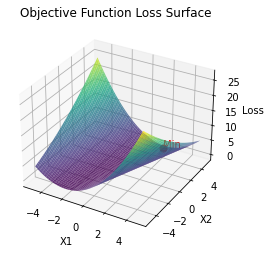

Approximate location of global minimum: x1=1.6666667461395264, x2=4.696969509124756, with fixed x3=1, x4=1


In [1371]:
def objective(x):
    return x.t()@A@x

# Prepare the tensor ranges for two dimensions we want to vary
x1_range = torch.linspace(-5, 5, 100)
x2_range = torch.linspace(-5, 5, 100)

# Convert to a meshgrid
x1, x2 = torch.meshgrid(x1_range, x2_range, indexing='ij')

# Initialize a tensor to hold the loss values
loss = torch.zeros_like(x1)

# Fixed values for the other dimensions
x3_fixed = 1
x4_fixed = 1

# Calculate the loss for each combination of x1 and x2
for i in range(x1.size(0)):
    for j in range(x2.size(1)):
        x_input = torch.tensor([x1[i, j], x2[i, j], x3_fixed, x4_fixed], dtype=torch.float)
        loss[i, j] = objective(x_input)

# Find the indices of the global minimum
min_loss_idx = torch.argmin(loss)
min_x1_idx, min_x2_idx = np.unravel_index(min_loss_idx, loss.shape)
min_x1 = x1[min_x1_idx, min_x2_idx].item()
min_x2 = x2[min_x1_idx, min_x2_idx].item()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1.numpy(), x2.numpy(), loss.numpy(), cmap='viridis', alpha=0.8)
min_point = ax.scatter(min_x1, min_x2, loss[min_x1_idx, min_x2_idx].numpy(), color='r', s=50)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Loss')
ax.set_title('Objective Function Loss Surface')

# Annotate the minimum point
ax.text(min_x1, min_x2, loss[min_x1_idx, min_x2_idx].numpy(), "Min", color='red')

plt.show()

print(f"Approximate location of global minimum: x1={min_x1}, x2={min_x2}, with fixed x3={x3_fixed}, x4={x4_fixed}")

In [1292]:
# H_diff_ = H_diff.detach()

In [1293]:
v = ((torch.randn(4)*2-1)/100).requires_grad_(True)
# v = (torch.zeros(4)+0.0001).requires_grad_(True)

optimizer = Adam([v], lr=0.0001)
# optimizer = SGD([v], lr=0.001, momentum=0.9)

In [1294]:
d = 4
alpha = 0.01
epsilon = 1e-6
max_iterations = 10000

In [1311]:
def loss_fn(v, M):
    return torch.einsum('i,ij,j', v, M , v)**2

In [1353]:
def optimize(loss_fn, M):
    
    v = ((torch.randn(4)*2-1)/100).requires_grad_(True)
    optimizer = Adam([v], lr=0.001)

    for iteration in range(max_iterations):

        optimizer.zero_grad()  # Reset gradients to zero

        loss_ = loss_fn(v, M)  # Objective function

        loss_.backward()  # Compute gradients

        optimizer.step()  # Update v based on gradients

        with torch.no_grad():
            v /= v.norm()


#         if iteration % 1000 == 0:
#             print(f"Iteration {iteration}, Loss: {loss.item()}")

    # Check final solution
    with torch.no_grad():
        print(f"Final v: {v}")
        print(loss_fn(v, M))
    #     print(f"Check if in null space (should be close to 0): ||A(v ⊗ v)|| = {torch.norm(torch.matmul(sigma, torch.kron(v, v)))}")

    return v

In [1388]:
v_ = (torch.randn(4)*2-1)/100

In [1394]:
M = H_diff_[0]
M

tensor([[-2.3842,  7.3709, -0.5509, -0.0272],
        [ 7.3709, 13.3039,  0.7228,  0.9610],
        [-0.5509,  0.7228, -0.8587,  4.6071],
        [-0.0273,  0.9610,  4.6071, -0.4011]])

In [1395]:
sum(lam[i]*torch.outer(V[:,i], V[:,i]) for i in range(4))

tensor([[-2.3842,  7.3709, -0.5509, -0.0273],
        [ 7.3709, 13.3039,  0.7228,  0.9610],
        [-0.5509,  0.7228, -0.8587,  4.6071],
        [-0.0273,  0.9610,  4.6071, -0.4011]])

In [1385]:
lam, V = torch.linalg.eigh(M)
lam,V

(tensor([-5.6174, -5.0034,  3.9782, 16.3025]),
 tensor([[ 0.7221,  0.5776, -0.1096,  0.3646],
         [-0.2808, -0.2422, -0.0405,  0.9278],
         [ 0.5004, -0.5233,  0.6883,  0.0449],
         [-0.3864,  0.5778,  0.7159,  0.0652]]))

In [1392]:
sum(lam[i]*v@torch.outer(V[:,i], V[:,i])@v for i in range(4))

tensor(8.7172e-07, grad_fn=<AddBackward0>)

In [1393]:
for i in range(4):
    print(lam[i]*v@torch.outer(V[:,i], V[:,i])@v)

tensor(-0.8228, grad_fn=<DotBackward0>)
tensor(-1.4367, grad_fn=<DotBackward0>)
tensor(2.2511, grad_fn=<DotBackward0>)
tensor(0.0084, grad_fn=<DotBackward0>)


In [1382]:
A = torch.outer(V[:,0], V[:,0])
A

tensor([[ 0.5215, -0.2028,  0.3613, -0.2790],
        [-0.2028,  0.0788, -0.1405,  0.1085],
        [ 0.3613, -0.1405,  0.2504, -0.1933],
        [-0.2790,  0.1085, -0.1933,  0.1493]])

In [1358]:
for _ in range(20):
    optimize(loss_fn, A)

Final v: tensor([ 0.0500, -0.6789, -0.6740, -0.2869], requires_grad=True)
tensor(2.0694e-14)
Final v: tensor([-0.5098, -0.4013, -0.0632, -0.7583], requires_grad=True)
tensor(1.2591e-09)
Final v: tensor([-0.3041, -0.5026,  0.5878,  0.5563], requires_grad=True)
tensor(2.0835e-13)
Final v: tensor([ 0.3296,  0.4656, -0.6265, -0.5312], requires_grad=True)
tensor(7.3111e-13)
Final v: tensor([ 0.1569, -0.3187,  0.2965,  0.8865], requires_grad=True)
tensor(5.3824e-09)
Final v: tensor([-0.6073, -0.6473,  0.4560, -0.0656], requires_grad=True)
tensor(1.1789e-10)
Final v: tensor([-0.2644, -0.5425, -0.4524, -0.6566], requires_grad=True)
tensor(1.5690e-08)
Final v: tensor([-0.1776, -0.7792, -0.4754, -0.3679], requires_grad=True)
tensor(6.9391e-10)
Final v: tensor([-0.4649, -0.4310, -0.1605, -0.7566], requires_grad=True)
tensor(5.0158e-11)
Final v: tensor([-0.4810, -0.8573,  0.1802, -0.0336], requires_grad=True)
tensor(1.4771e-10)
Final v: tensor([-0.4698,  0.0023, -0.0084, -0.8827], requires_grad=Tr

In [1347]:
torch.outer(torch.linalg.eigh(A)[1][:,3],torch.linalg.eigh(A)[1][:,3])

tensor([[ 0.5215, -0.2028,  0.3613, -0.2790],
        [-0.2028,  0.0788, -0.1405,  0.1085],
        [ 0.3613, -0.1405,  0.2504, -0.1933],
        [-0.2790,  0.1085, -0.1933,  0.1493]])

In [1338]:
for i in range(4):
    print(torch.linalg.eigh(torch.outer(V[:,i], V[:,i])))
    print()

torch.return_types.linalg_eigh(
eigenvalues=tensor([-3.8561e-08, -6.8562e-09,  1.3482e-07,  1.0000e+00]),
eigenvectors=tensor([[ 0.1004, -0.2010,  0.6542,  0.7221],
        [-0.5113,  0.5815,  0.5671, -0.2808],
        [-0.7485,  0.0077, -0.4351,  0.5004],
        [-0.4101, -0.7883,  0.2472, -0.3864]]))

torch.return_types.linalg_eigh(
eigenvalues=tensor([-4.2567e-08, -1.8303e-08,  9.0673e-08,  1.0000e+00]),
eigenvectors=tensor([[-0.6722,  0.0440, -0.4610,  0.5776],
        [ 0.3943,  0.2275, -0.8568, -0.2422],
        [-0.4805,  0.6949,  0.1113, -0.5233],
        [ 0.4021,  0.6807,  0.2025,  0.5778]]))

torch.return_types.linalg_eigh(
eigenvalues=tensor([-1.1996e-07, -1.2241e-08,  7.2593e-08,  1.0000e+00]),
eigenvectors=tensor([[-0.9918,  0.0307, -0.0575,  0.1096],
        [-0.0606, -0.3603,  0.9300,  0.0405],
        [-0.0833, -0.6799, -0.2389, -0.6883],
        [-0.0752,  0.6380,  0.2735, -0.7159]]))

torch.return_types.linalg_eigh(
eigenvalues=tensor([-5.9759e-08, -4.2247e-11,  4.2

In [1320]:
# for _ in range(20):
#     optimize(loss_fn, H_diff_[0])

In [663]:
A_H_diff = H_diff.reshape(-1, 4)
A_H_diff = A_H_diff.numpy()
A_H_diff

array([[  21.272018,   -7.198347,   26.455421,  -45.278168],
       [  -7.198349,  -20.169586,  -13.590012,   55.720245],
       [  26.455421,  -13.590012,  135.03174 ,  473.79715 ],
       ...,
       [  28.108963,  -17.983795, -200.86893 ,  158.70944 ],
       [ 165.42741 , -200.86896 , -670.11633 , 1316.6929  ],
       [-125.438385,  158.70938 , 1316.6926  , -175.91992 ]],
      dtype=float32)

In [666]:
null_space(A_H_diff)

array([], shape=(4, 0), dtype=float32)

In [330]:
torch.rand((d**2, 10), dtype=torch.float32).shape

torch.Size([16, 10])

In [229]:
ns0v = ns[:,1, np.newaxis] #+ ns[:,1, np.newaxis]
ns0v.reshape(4, 4)

array([[ 0.04403839, -0.37557417, -0.8202226 , -0.01583429],
       [ 0.36719134, -0.0010905 , -0.02607253,  0.01872573],
       [ 0.18299073, -0.01312724,  0.00837168,  0.01389938],
       [-0.06383918,  0.09017187,  0.00974324,  0.04364639]],
      dtype=float32)

In [207]:
sigma@ns0v.squeeze

array([[ 8.3923340e-05],
       [ 0.0000000e+00],
       [ 5.7220459e-06],
       [-4.7683716e-06],
       [ 9.5367432e-07],
       [ 7.6293945e-05],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 9.5367432e-06],
       [ 1.8310547e-04],
       [ 1.5258789e-05],
       [-3.8146973e-06],
       [-4.7683716e-06],
       [-3.8146973e-06],
       [ 0.0000000e+00],
       [ 2.3841858e-07]], dtype=float32)

In [149]:
H_bar = np.mean(H_matrices, axis=0)
H_bar

array([[-14.05569   ,  -5.465047  ,   2.6068852 ,  -2.4921746 ],
       [ -5.465045  , -24.278086  ,   4.853015  ,  -3.1555214 ],
       [  2.6068854 ,   4.853015  , -29.305317  ,   0.97690344],
       [ -2.4921746 ,  -3.155522  ,   0.9769045 , -27.897842  ]],
      dtype=float32)

In [148]:
diffs = H_matrices-H_bar
diffs

array([[[  7.499079  ,   4.4851604 ,  -0.34392762,   0.7710898 ],
        [  4.485159  ,  -1.8332195 ,   9.195822  ,  -0.95451975],
        [ -0.34392834,   9.195824  ,   9.869789  ,  -1.8479104 ],
        [  0.7710898 ,  -0.95451903,  -1.8479109 ,   0.3029251 ]],

       [[-11.096089  ,  -4.170373  ,  -1.0795935 ,  -0.36714387],
        [ -4.17037   , -11.690348  , -14.421174  ,  -0.6229186 ],
        [ -1.0795887 , -14.421176  ,   3.4988937 , -12.304499  ],
        [ -0.36714458,  -0.6229174 , -12.304493  ,   2.2370796 ]],

       [[  7.178548  ,   2.0141509 ,   0.09937215,   0.72006226],
        [  2.0141492 ,  -8.269407  ,   7.6053276 ,  -1.8377976 ],
        [  0.09937167,   7.6053257 ,  -6.0269547 ,  -5.260851  ],
        [  0.720062  ,  -1.8377979 ,  -5.260853  ,   1.0626926 ]],

       [[ -7.868081  ,   0.55568075,   0.20778704,  -0.8977442 ],
        [  0.55567646,  23.951899  , -18.161549  ,   4.8603783 ],
        [  0.20778322, -18.16155   , -14.702347  ,  14.682911  ],
    

In [158]:
null_space(H_bar)

array([], shape=(4, 0), dtype=float32)

# Rank Constrained Optimization

In [454]:
optimizer = optim.Adam([G_hat], lr=0.05)

In [455]:
sigma = 1

for step in range(100):
    optimizer.zero_grad()
    loss = objective(G_hat, H_, sigma)
    
    u,s,v = torch.svd(G_hat)
    rank = torch.sum(s > 1e-5).item()
    if rank < num_latent:
        penalty = 1000*(num_latent-rank)
        loss+=penalty
    
    loss.backward(retain_graph=True)
    optimizer.step()
    sigma*=0.5
    
    if step%10==0:
        print(f"Step {step}, Loss: {loss.item()}, Rank: {rank}")
        print(G_hat)
        print('---------------------')

Step 0, Loss: -3.99831223487854, Rank: 4
tensor([[ 0.0304, -0.0342, -0.0653, -0.0491],
        [ 0.0035, -0.0181, -0.0396, -0.0139],
        [-0.0034,  0.0091,  0.0403, -0.0282],
        [ 0.0052, -0.0040,  0.0518,  0.0214]], requires_grad=True)
---------------------
Step 10, Loss: -3.9995839595794678, Rank: 4
tensor([[ 0.0035,  0.0032,  0.0203, -0.0324],
        [ 0.0105, -0.0153,  0.0070, -0.0213],
        [ 0.0115, -0.0041, -0.0195,  0.0022],
        [-0.0195,  0.0579, -0.0387,  0.0207]], requires_grad=True)
---------------------
Step 20, Loss: -3.4546260833740234, Rank: 4
tensor([[-7.2268e-03, -1.1233e-02, -3.2984e-02,  5.4947e-02],
        [ 1.3924e-05, -1.1789e-02, -2.4224e-02, -5.0934e-03],
        [ 1.2434e-02,  1.9175e-03,  3.4148e-02, -1.2302e-02],
        [ 1.0970e-02,  4.3306e-03,  2.0542e-02,  6.9833e-03]],
       requires_grad=True)
---------------------
Step 30, Loss: -0.0, Rank: 4
tensor([[-0.0614, -0.0011,  0.0595, -0.1443],
        [ 0.0906,  0.0371,  0.0725, -0.0218]

In [293]:
torch.inverse(G)

tensor([[ 1.0705, -1.1643, -1.2469,  0.4581],
        [-0.4852,  0.6180,  1.8086, -0.3636],
        [-0.4784, -0.1914,  0.4940, -0.5688],
        [ 1.0384, -0.0231, -0.0147, -0.9327]], grad_fn=<InverseBackward0>)

In [294]:
G_hat

tensor([[ 0.1988, -0.8034,  0.0287, -0.0025],
        [ 0.0960, -0.2877,  0.1580, -0.1699],
        [ 0.0056, -0.0312, -0.1201,  0.1405],
        [-0.1957,  0.7459, -0.1871,  0.1893]], requires_grad=True)

In [295]:
beta = torch.inverse(G)@G_hat
beta

tensor([[ 4.3044e-03, -1.4458e-01, -8.9255e-02,  1.0664e-01],
        [ 4.4228e-02, -1.1549e-01, -6.5399e-02,  8.1484e-02],
        [ 6.4660e-04, -2.8214e-04,  3.1372e-03, -4.5492e-03],
        [ 3.8662e-01, -1.5229e+00,  2.0245e-01, -1.7734e-01]],
       grad_fn=<MmBackward0>)

In [306]:
diag_var(G_hat,H)

tensor([1.1018e+09, 3.1358e+08, 1.2092e+09, 2.7774e+08],
       grad_fn=<VarBackward0>)